## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [6]:
import sys
import os
import gc
import collections
# import hickle as hkl
# import ttictoc as tt

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [7]:
# sys.path.insert(0,'../py-MDNet/modules')
# from sample_generator import *


### For Validation

In [8]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    Qvalues = []
    numTrAllP = []
    pred = []
    gt = []
    
    if db_no == 5:
        imw, imh = (1920,1080)
    else:
        imw, imh = (320,240) #img.size
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        aaa = 1
        Qval_1p= []
        numTr = 0
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        if startIDX > ped.shape[0]:
            continue
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        occ_len = 0.01
        # Make initial state
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        #print (state.size())
        num_steps = 0
        prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())

        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        
        
        while(curr_frame <= ped[-1,1]): # alltime-6):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()
            
            occ_max_val = 12000000
            aaa += 1
            if aaa > 1 and occ_len > occ_max_val:
                c = c #np.array(num_camera-1)
            if occ_len > occ_max_val and aaa%50 == 0:
                aaa = 1
                c = np.array(np.random.randint(num_camera))

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            #if req_inc:
            if inc==1 and y!=num_camera-1:
                # inside a camera
                if req_inc:
                    accP.append((y,y))
                    c = y
                else:
                    accP.append((y,c.item(0)))
            elif inc==0 and y==c.item(0) and y!=num_camera-1:
                # transitioning to second camera
                accP.append((y,c.item(0)))
                inc = 1
                numTr += 1
            elif inc==1 and y==num_camera-1:
                # moving out of a camera FOV
                inc = 0
                accP.append((y,c.item(0)))
            else:
                # Making transition
                accP.append((y,c.item(0)))
                #print ('Another case',y,c.item(0))
                    
            #else:
            #    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                curr_camera = c
                
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                
                ispresent = 1
                prev_rt = rt[0:4]
                    
            else:
                ispresent = 0
                
            #############################################################################
            if c != num_camera-1:
                #bbox_pt = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
                #if bbox_pt_n.shape[0] > 0:
                if ispresent:
                    pred.append([c+1,curr_frame+1,test_pids[p]+1,bbox[0],bbox[1],bbox[2],bbox[3]])
                #else:
                #    pred.append([c+1,curr_frame,p,np.array([0,0,0,0])])
            if y != num_camera-1:
                bbox_gt = ped[ np.logical_and(ped[:,0]==y,ped[:,1]==curr_frame),2:]
                gt.append([y+1,curr_frame+1,test_pids[p]+1,bbox_gt[0][0],bbox_gt[0][1],bbox_gt[0][2],bbox_gt[0][3]])
            
            #############################################################################
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += 1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
                
            if isdebug:
                print ( np.where(rt.ravel()))
                print ( np.where(ch))
                print (c, curr_frame)
                print ('isPresent', ispresent)
                
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # store current reward
            reward_sum += reward
            Qval_1p.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,False,y,c,state.detach().cpu().numpy()))
                        
            #state = next_state
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, enc_history], dim=1)
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        Qvalues.append((np.stack(Qval_1p)))
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        numTrAllP.append(numTr)
        
    return rsT, accT, Qvalues, numTrAllP, pred,gt


### Initialize hyper-parameters

In [9]:
resume = False # resume from previous checkpoint?
render = False


In [10]:
# load dataset
db_no = 2
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
pTest = np.array(pTest)

if db_no == 5:
    fpsc = 6
else:
    fpsc = 2

Total number of person in data set:  (1, 255)
Total number of person in data set:  (1, 255)


In [11]:

d = 10
h_len = 20

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

## Policy Model

In [12]:
# Initialize required parameters
lstm_size = 256
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256

input_size = lstm_size + num_camera+ 4*2 +1

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fco = nn.Linear(hidden_size3, num_camera)
        
        # Activation function 
        self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.relu(self.fch3(x))
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [13]:
# build the model
if use_cuda:
    policy_net = NextCamera().float().cuda()
    criterion = nn.MSELoss().cuda()
    
else:
    policy_net = NextCamera().float()
    criterion = nn.MSELoss()
    
# if use_cuda:
#     target_net = NextCamera().cuda()
#     target_net.float().cuda()
# target_net.load_state_dict(policy_net.state_dict())

# use ADAM as optimizer since we can load the whole data to train
# optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

## AE Model

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = src #self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, dim]
        
        embedded = input #self.dropout(self.embedding(input))
        #embedded[np.arange(embedded.size),a] = 1
        
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.1):
        
        #src = [src len, batch size, dim]
        #trg = [trg len, batch size, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output #.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [15]:
duke_cam = 9
INPUT_DIM = duke_cam
OUTPUT_DIM = duke_cam
ENC_EMB_DIM = duke_cam
DEC_EMB_DIM = duke_cam
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).float().cuda()
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).float().cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).float().to(device)
criterion_ae = nn.CrossEntropyLoss()

In [16]:
# load encoder model
if db_no == 5:
    model.load_state_dict(torch.load('tut1-model_duke_lstmSize128_manyDB_2_old.pt'))  ## use *2_old as model for Duke
else:
    model.load_state_dict(torch.load('tut1-model_duke_lstmSize128_manyDB_2.pt'))  ## use *2_old as model for Duke
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=9, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Run episodes

In [18]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    if db_no == 5:
        imw, imh = (1920,1080)
    else:
        imw, imh = (320,240) #img.size
    hc = np.array(10*np.log(occ_len))
    
    if p:
        rt = np.zeros((8))
        rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
        rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
        rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
        rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
        rt[4] = 0
        rt[5] = 0
        rt[6] = 0
        rt[7] = 0
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        #this_cam = afc.make_one_hot_camera(curr_camera)
        #state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc.ravel()))
        #state = np.concatenate((state, ch.ravel()))
        #state = state.reshape(1,-1)
        #state[state==0] = -10
        #state[state==1] = 10
        
        # make next_state vector
        this_cam = afc.make_one_hot_camera(curr_camera)
        xt = np.concatenate((this_cam, rt.ravel()))
        xt[xt==0] = -10
        xt[xt==1] = 10
        xt = xt.reshape(1,-1)
        
        # make history vector
        c_t = this_cam.reshape(1,-1)
        
        if use_cuda:
            xt = torch.from_numpy(xt).float().cuda()
            c_t = torch.from_numpy(c_t).float().cuda()
            hc = torch.from_numpy(hc.reshape(1,-1)).float().cuda()
        else:
            xt = torch.from_numpy(xt).float()
            c_t = torch.from_numpy(c_t).float()
            hc = torch.from_numpy(hc.reshape(1,-1)).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        xt,h_t = [],[]
    
    return xt,c_t,hc,rt #p,state,rt


In [19]:
def remove_duplicates(arr): 
    final_list = [] 
    gt_tr = []
    final_list.append(arr[0])     
    for i in range(1,arr.shape[0]): 
        if arr[i] != arr[i-1]:
            final_list.append(arr[i])     
            if arr[i] != num_camera-1:
                gt_tr.append(arr[i])
    return final_list, gt_tr

In [20]:
if db_no == 1:
    rand_PIDs = np.array([88,137,182,223,174,71,200,58,1,185,74,168,235,46,17,67,162,100, \
        192,113,140,6,94,81,11,181,159,78,147,22,127,115,68,143,59,212,217,161, \
        92,164,227,206,73,123,125,126,230,233,83,197,231,34,145,26,114,27,138,7,\
        151,8,48,120,166,215,35,85,64,111,156,225,65,171,153,25,45,207,219,178,\
        23,165,50,199,110,203,211,47,152,30,132,102,205,96,89,129,52,107,60,36,\
        216,167,87,149,208,116,213,57,41,214,12,175,163,15,173,144,134,86,194,82,\
        128,186,63,105,122,69,21,183,169,187,222,19,232,108,198,79,141,91,51,150,\
        53,77,5,119,39,33,170,84,229,180,133,40,188,139,54,121,158,55,42,10,9,124,\
        142,90,136,189,226,131,135,13,95,24,209,191,44,29,16,218,20,93,184,130,117,\
        49,204,3,112,146,195,109,62,37,98,154,72,99,157,234,103,56,106,31,66,172,202,\
        38,43,28,101,221,193,177,2,4,160,155,14,210,196,176,97,70,201,228,75,18,104,\
        179,118,148,190,224,220,32,61,80,76])
    test_pids = rand_PIDs[1::2]-1
elif db_no == 2:
    rand_PIDs = range(255)
    test_pids = rand_PIDs
elif db_no == 3:
    rand_PIDs = np.array([9,1,5,2,8,7,6,12,13,11,4,14,10,3])
    test_pids = rand_PIDs[1::2]-1
elif db_no == 4:
    rand_PIDs = np.array([1,46,17,6,11,22,34,26,27,7,8,48,35,25,45,23,47,30,36,41,12,15,21,19,5,39,\
            33,40,42,10,9,13,24,44,29,16,20,49,3,37,31,38,43,28,2,4,14,18,32])
    test_pids = rand_PIDs[1::2]-1
elif db_no == 5:
    randPIDs = spio.loadmat('../data/pALL_DukeDataset_rand.mat')  # load the random PIDs
    randPIDs = randPIDs['pALL']-1
    test_pids = randPIDs[0,1::2] 

In [21]:
#policy_net = torch.load('./EpData/policy_db4_3rep_del_rareFreq_ep5k_1201')
if db_no == 1 or db_no == 2:
    policy_net.load_state_dict(torch.load('./models/policy_ECCV_db1_pretrDukeAE256_seq20_rp20K_901')['state_dict'])
elif db_no == 3:
    policy_net.load_state_dict(torch.load('./models/policy_ECCV_db3_pretrDukeAE256_seq20_rp20K_4251')['state_dict'])
elif db_no == 4:
    policy_net.load_state_dict(torch.load('./models/policy_ECCV_db4_pretrDukeAE256_seq20_rp20K_2801')['state_dict'])
elif db_no == 5: 
    policy_net.load_state_dict(torch.load('./models/policy_ECCV_duke_pretrAE256_seq20_rp20K_21')['state_dict'])
    

In [22]:
# previous policy training on same script [BEST TILL NOW]
policy_net.eval()
req_inc = 0
_,acc,_,numTR,rp,rg = test_func(pTest,iloc='fix',eloc='last', fixLoc=0, isdebug=0, req_inc=req_inc)
resMat = {}
resMat['MCT_pr'] = rp
resMat['MCT_gt'] = rg
sel_matrix = np.vstack(acc)
resMat['Sel_pr'] = sel_matrix[:,1]
resMat['Sel_gt'] = sel_matrix[:,0]
resMat['accAllP'] = acc
resMat['numTR'] = numTR

# experiment number, only ICT: exp1, ICT+SCT: exp2
if req_inc == 0:   # performing ICT+SCT
    expNo = 2
else:    # performing only ICT
    expNo = 1  
    
if db_no == 1:
    saveFilePath = './results/results_MM_db1_exp'+str(expNo)+'_gt.mat'
elif db_no == 2:
    saveFilePath = './results/results_MM_db2_exp'+str(expNo)+'_gt.mat'
elif db_no == 3:
    saveFilePath = './results/results_MM_db3_exp'+str(expNo)+'_gt.mat'
elif db_no == 4:
    saveFilePath = './results/results_MM_db4_exp'+str(expNo)+'_gt.mat'
elif db_no == 5:
    saveFilePath = './results/results_MM_duke_exp'+str(expNo)+'_gt.mat'


Initial position:  [ 0 17 77  1 20 52]
Initial position:  [  0  26 103   1  23  57]
Initial position:  [  0 156  90   2  25  52]
Initial position:  [  0 279 112   1  22  54]
Initial position:  [  0 311  64   1  24  55]
Initial position:  [  0 420 223 175  24  62]
Initial position:  [  0 510 217 179  26  60]
Initial position:  [  0 656 104   1  19  57]
Initial position:  [  0 695  37   1  26  54]
Initial position:  [  0 816  69   1  24  55]
Initial position:  [  0 913  71   1  19  52]
Initial position:  [   0 1196   43    1   21   60]
Initial position:  [   0 1659   78    1   25   61]
Initial position:  [   0 1923  171   29   31   55]
Initial position:  [   0 2086   35    1   22   56]
Initial position:  [   0 2391   69    1   26   62]
Initial position:  [   0 2698   87    1   24   57]
Initial position:  [   0 3678   46    1   24   58]
Initial position:  [   0 3710  103    1   26   56]
Initial position:  [   0 4020   57    1   28   58]
Initial position:  [   0 4112  124    1   24   53]
I

Initial position:  [   2 4640  189   35   22   87]
Initial position:  [   2 4886  282   45   36   69]
Initial position:  [   2 5113  284   45   34   79]
Initial position:  [   2 6108  283   43   35   95]
Initial position:  [   2 6131  281   40   38   95]
Initial position:  [   2 6241  284   40   34   94]
Initial position:  [   2 6323  291   42   26   84]
Initial position:  [   2 6670  266  107   51  118]
Initial position:  [   2 6857   80   11   23   70]
Initial position:  [   2 8142  287   47   30   91]
Initial position:  [   2 8264   77   20   25   59]
Initial position:  [   2 8628  290   41   28   83]
Initial position:  [   2 9106   87  119   43  117]
Initial position:  [   2 9139  283   77   35  102]
Initial position:  [   2 9751  278   40   40   84]
Initial position:  [    2 10212   248   110    57   127]
Initial position:  [    2 10403   109   115    64   120]
Initial position:  [    2 10414   287    32    31    79]
Initial position:  [    2 10525   291    27    27    79]
Initial

In [40]:
resMat['accAllP'][0]

TypeError: list indices must be integers or slices, not tuple

Person:  0
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


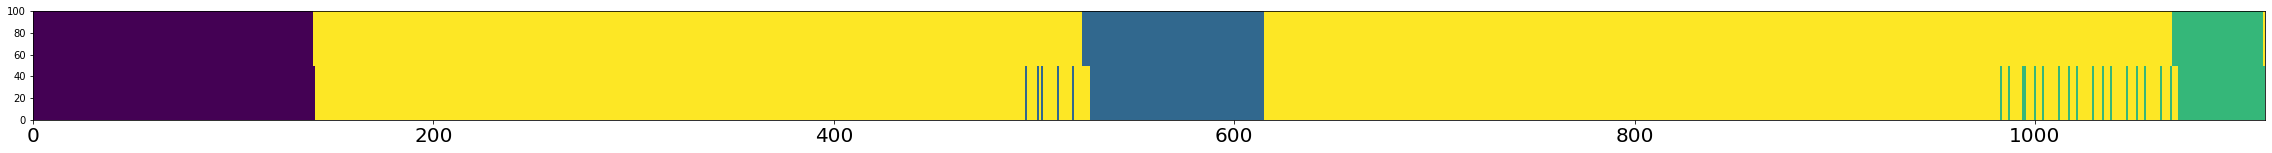

A,P,R:  0.9721973094170404 0.9180887372013652 0.9746376811594203
Num frames:  (293, 24)
Accuracy:  0.9721973094170404
Person:  1
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


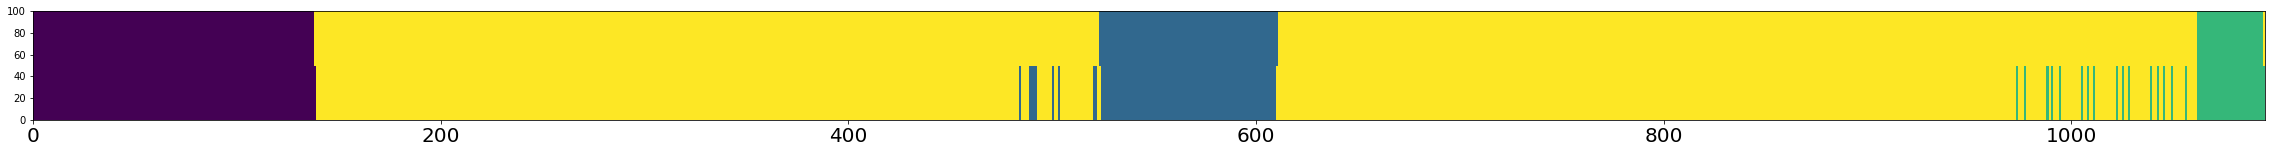

A,P,R:  0.9735159817351599 0.9045936395759717 0.9922480620155039
Num frames:  (283, 27)
Accuracy:  0.9735159817351599
Person:  2
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


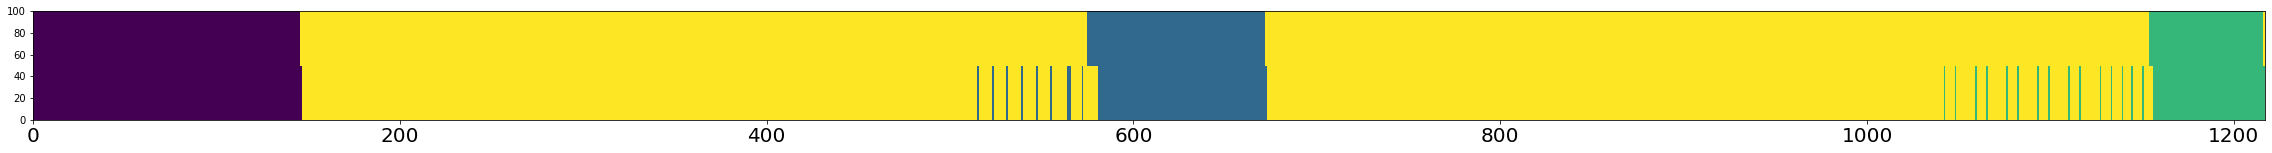

A,P,R:  0.971240755957272 0.9166666666666666 0.9737704918032787
Num frames:  (324, 27)
Accuracy:  0.971240755957272
Person:  3
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


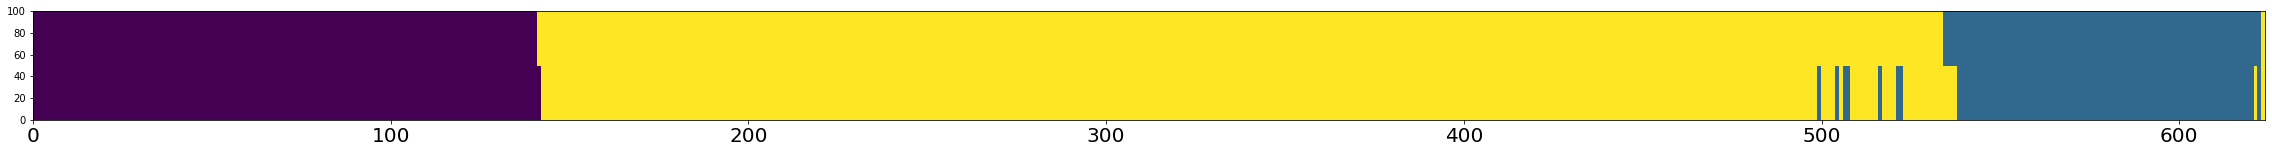

A,P,R:  0.9791666666666666 0.9656652360515021 0.9782608695652174
Num frames:  (233, 8)
Accuracy:  0.9791666666666666
Person:  4
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


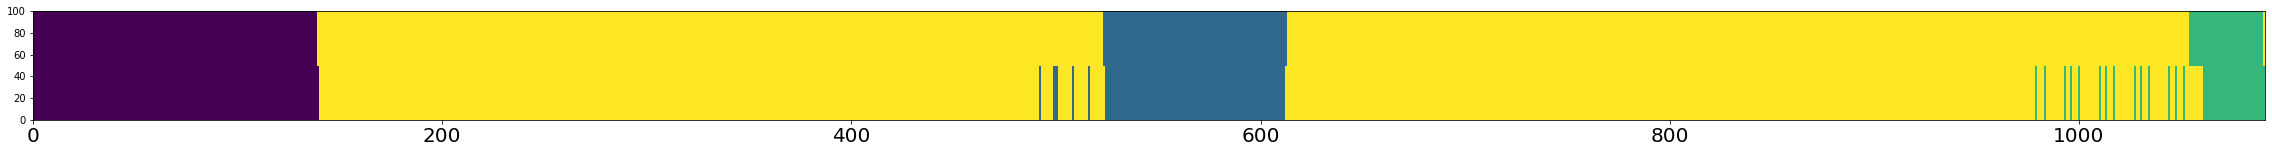

A,P,R:  0.9725022914757103 0.924187725631769 0.9660377358490566
Num frames:  (277, 21)
Accuracy:  0.9725022914757103
Person:  5
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



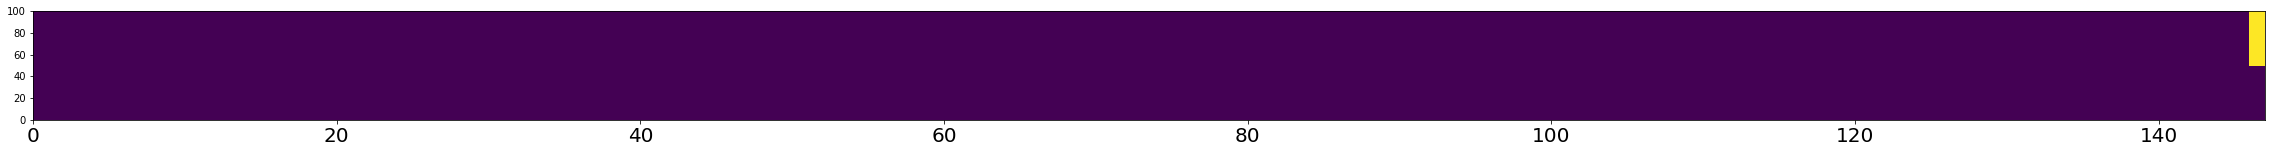

A,P,R:  0.9931972789115646 0.9931972789115646 1.0
Num frames:  (147, 1)
Accuracy:  0.9931972789115646
Person:  6
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



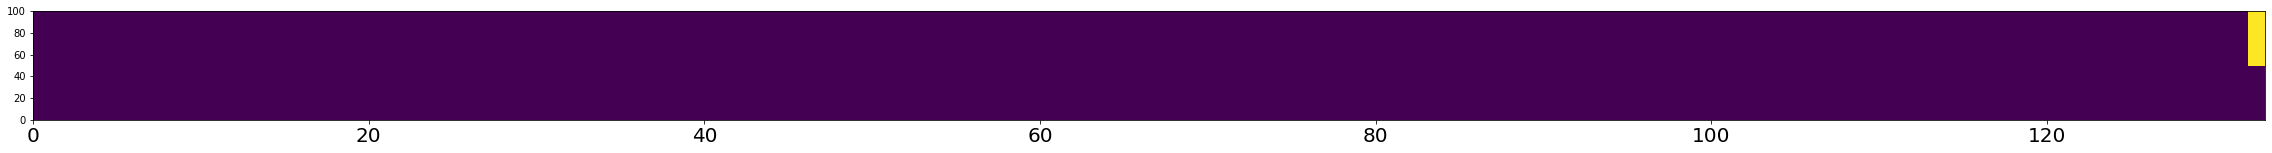

A,P,R:  0.9924812030075187 0.9924812030075187 1.0
Num frames:  (133, 1)
Accuracy:  0.9924812030075187
Person:  7
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


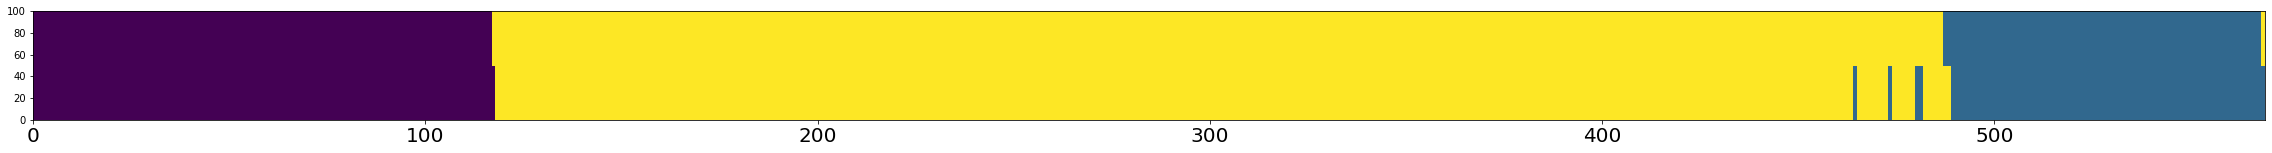

A,P,R:  0.9859402460456942 0.9702970297029703 0.98989898989899
Num frames:  (202, 6)
Accuracy:  0.9859402460456942
Person:  8
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


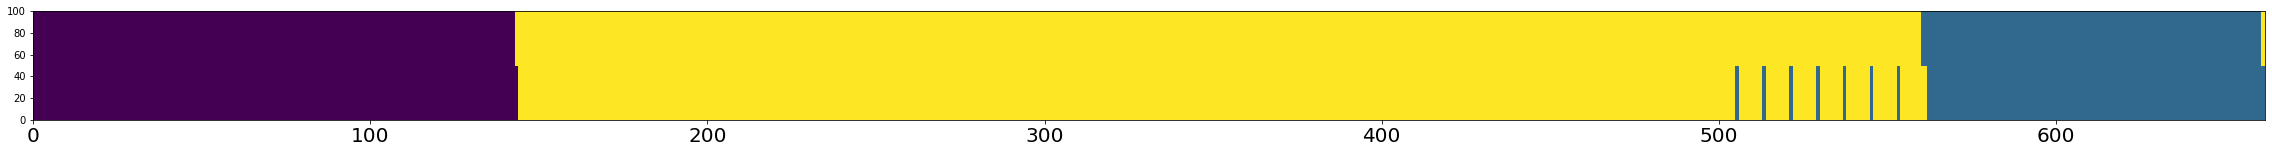

A,P,R:  0.9833836858006042 0.9641434262948207 0.9918032786885246
Num frames:  (251, 9)
Accuracy:  0.9833836858006042
Person:  9
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


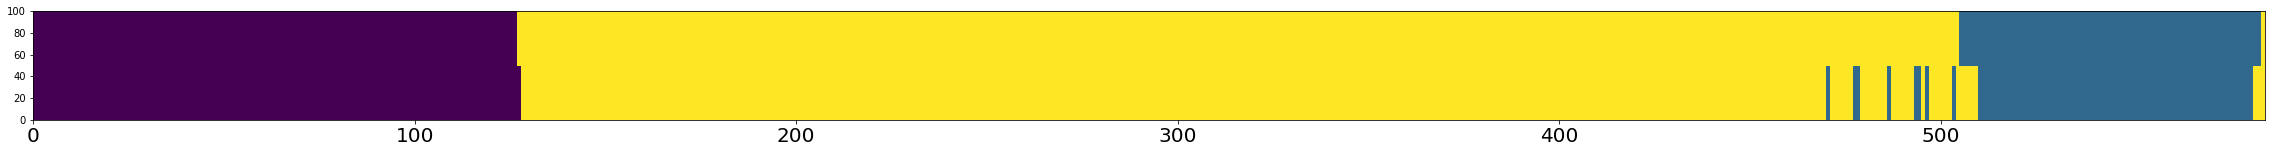

A,P,R:  0.9726495726495726 0.9567307692307693 0.9660194174757282
Num frames:  (208, 9)
Accuracy:  0.9726495726495726
Person:  10
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


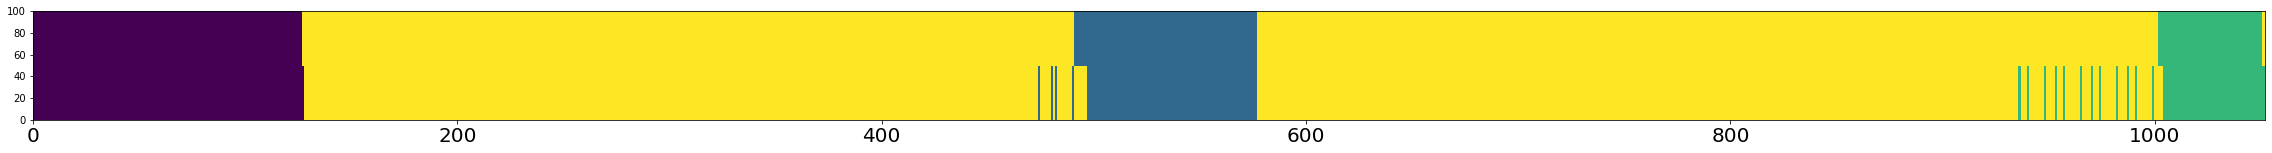

A,P,R:  0.9752851711026616 0.9338235294117647 0.9694656488549618
Num frames:  (272, 18)
Accuracy:  0.9752851711026616
Person:  11
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


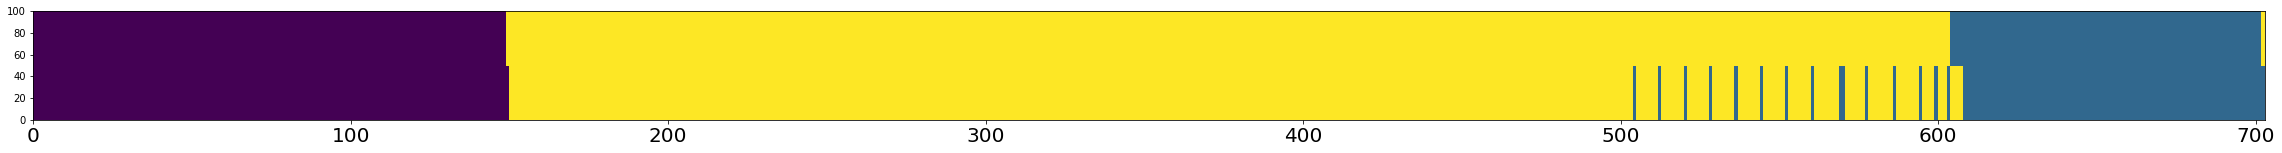

A,P,R:  0.9701280227596017 0.9346153846153846 0.9838056680161943
Num frames:  (260, 17)
Accuracy:  0.9701280227596017
Person:  12
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


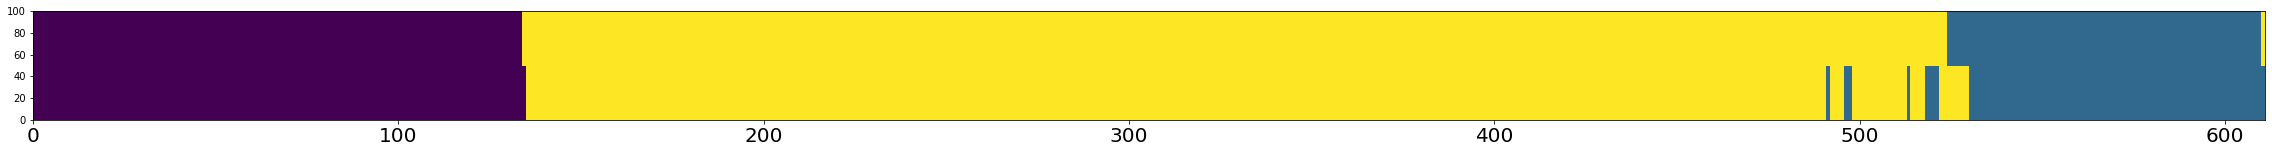

A,P,R:  0.9738134206219312 0.9553571428571429 0.9727272727272728
Num frames:  (224, 10)
Accuracy:  0.9738134206219312
Person:  13
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



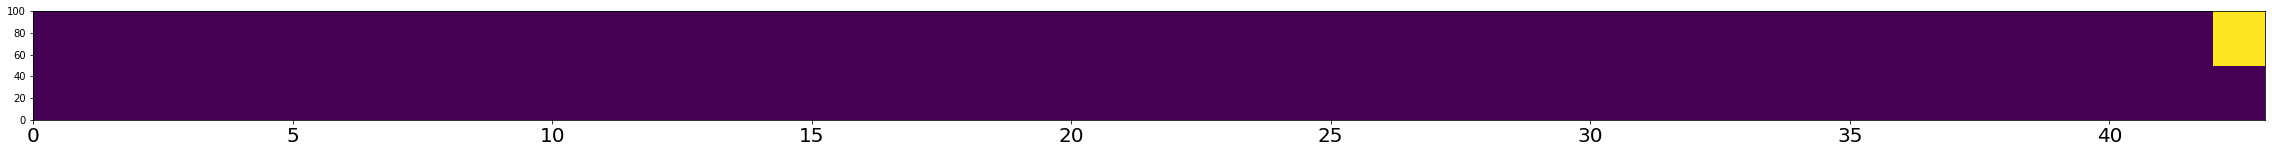

A,P,R:  0.9767441860465116 0.9767441860465116 1.0
Num frames:  (43, 1)
Accuracy:  0.9767441860465116
Person:  14
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


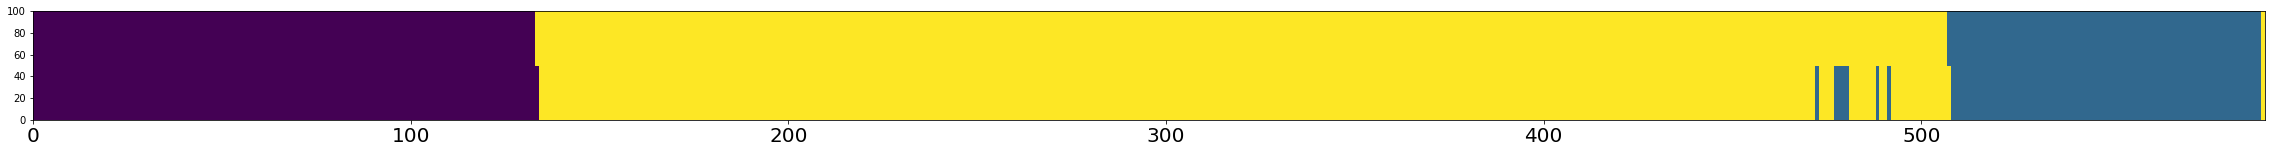

A,P,R:  0.9847715736040609 0.9641255605381166 0.9953703703703703
Num frames:  (223, 8)
Accuracy:  0.9847715736040609
Person:  15
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


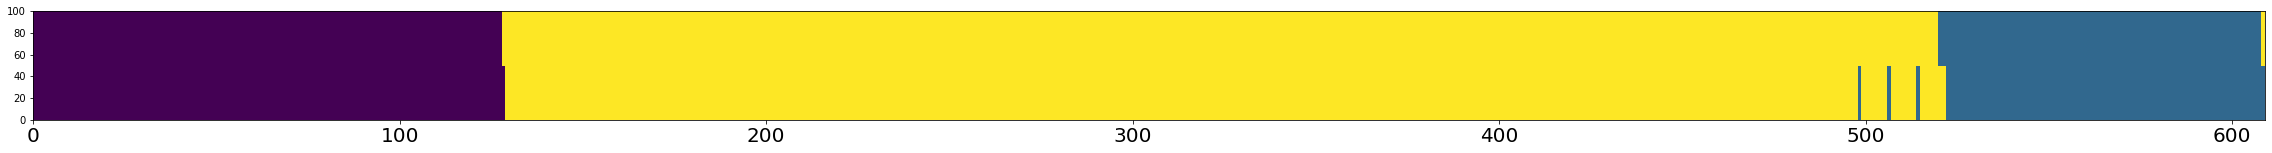

A,P,R:  0.9885057471264368 0.9771689497716894 0.9907407407407407
Num frames:  (219, 5)
Accuracy:  0.9885057471264368
Person:  16
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


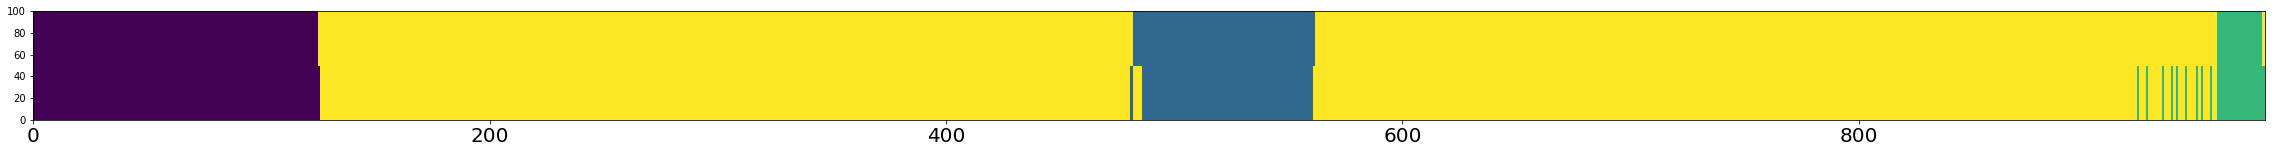

A,P,R:  0.9826175869120655 0.9482758620689655 0.9777777777777777
Num frames:  (232, 12)
Accuracy:  0.9826175869120655
Person:  17
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


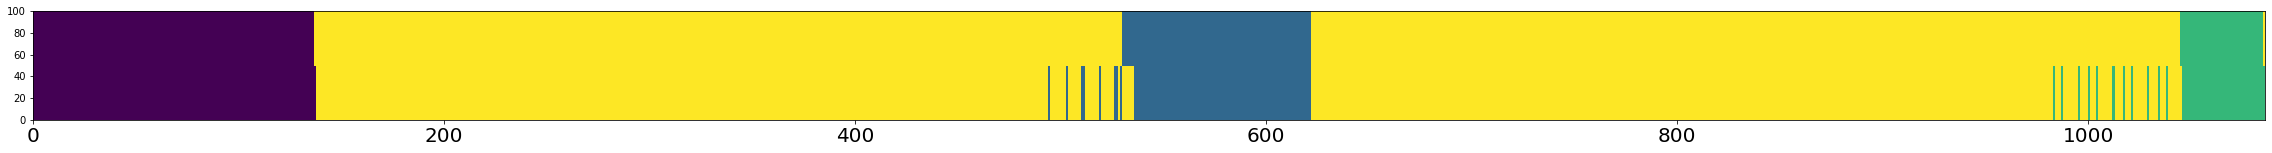

A,P,R:  0.9742173112338858 0.9257950530035336 0.9739776951672863
Num frames:  (283, 21)
Accuracy:  0.9742173112338858
Person:  18
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


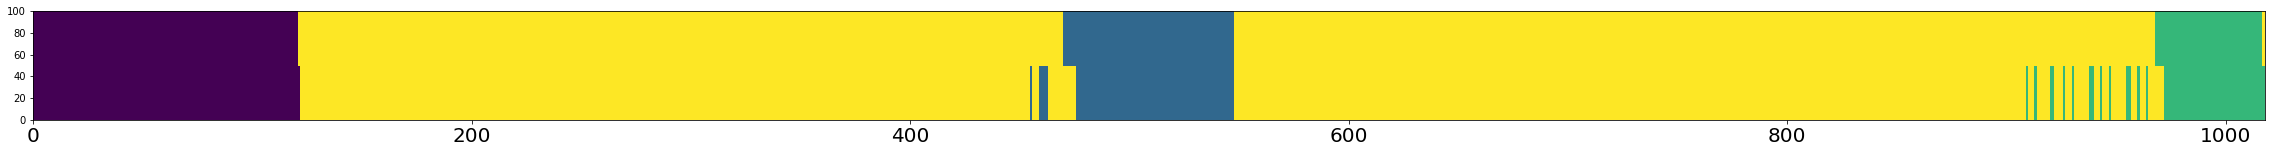

A,P,R:  0.9695481335952849 0.918918918918919 0.9596774193548387
Num frames:  (259, 21)
Accuracy:  0.9695481335952849
Person:  19
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


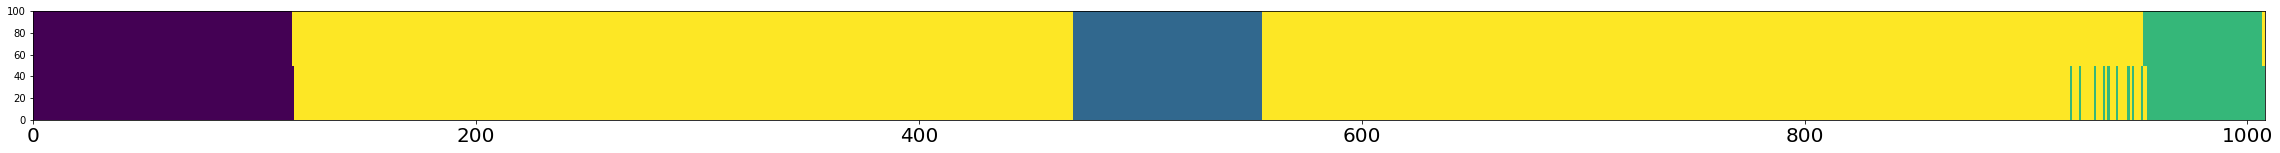

A,P,R:  0.9871031746031746 0.9584905660377359 0.9921875
Num frames:  (265, 11)
Accuracy:  0.9871031746031746
Person:  20
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


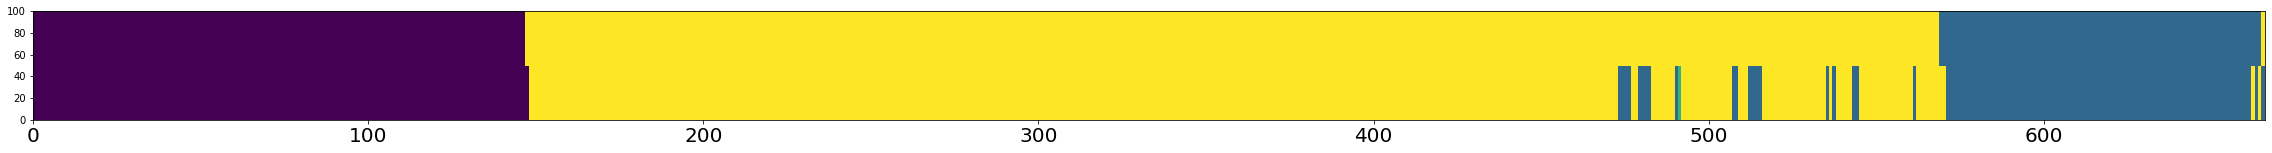

A,P,R:  0.9594594594594594 0.9122137404580153 0.9835390946502057
Num frames:  (262, 23)
Accuracy:  0.9594594594594594
Person:  21
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


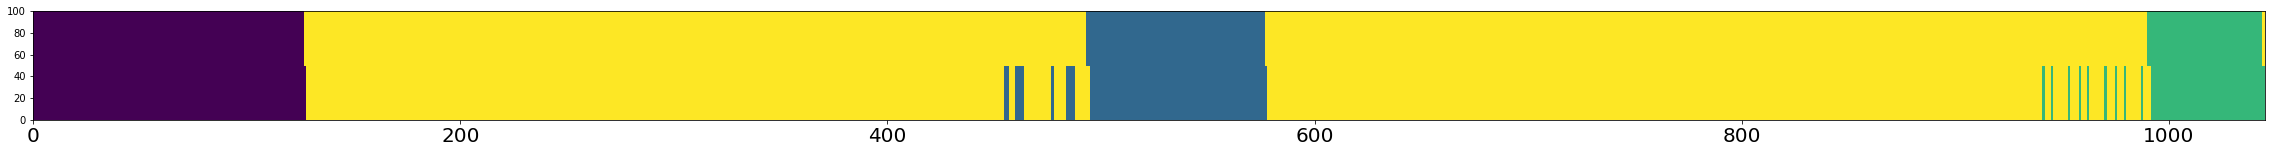

A,P,R:  0.9741626794258373 0.9190140845070423 0.9849056603773585
Num frames:  (284, 23)
Accuracy:  0.9741626794258373
Person:  22
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


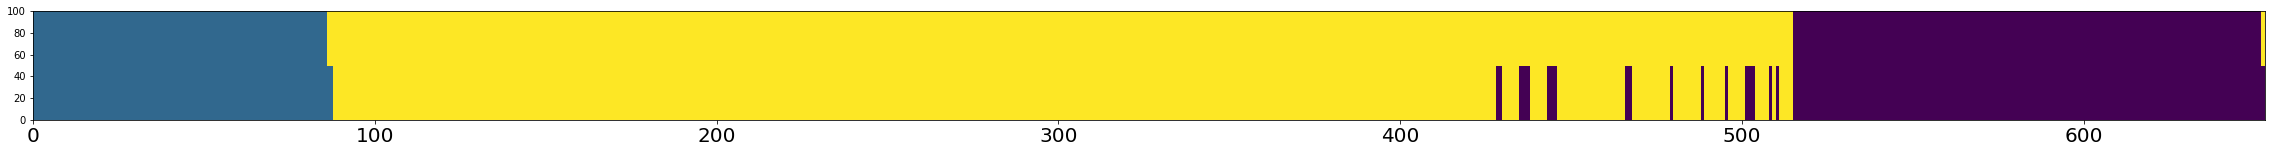

A,P,R:  0.9678407350689127 0.9139344262295082 1.0
Num frames:  (244, 21)
Accuracy:  0.9678407350689127
Person:  23
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


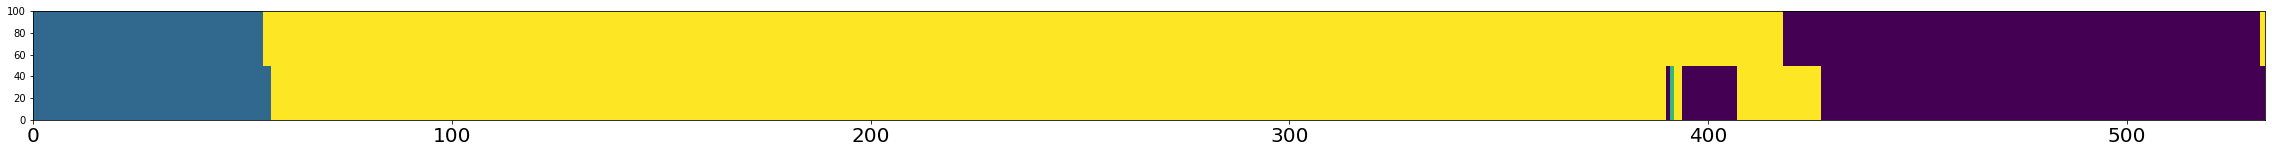

A,P,R:  0.949343339587242 0.898876404494382 0.9467455621301775
Num frames:  (178, 18)
Accuracy:  0.949343339587242
Person:  24
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


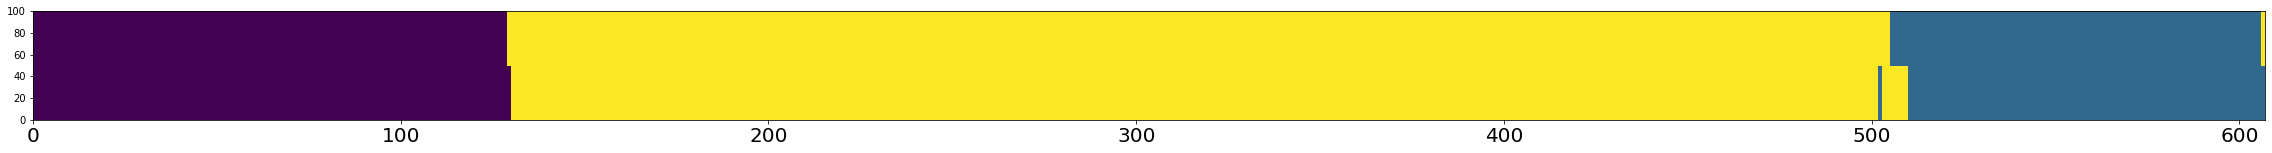

A,P,R:  0.9868204283360791 0.9868421052631579 0.9782608695652174
Num frames:  (228, 3)
Accuracy:  0.9868204283360791
Person:  25
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


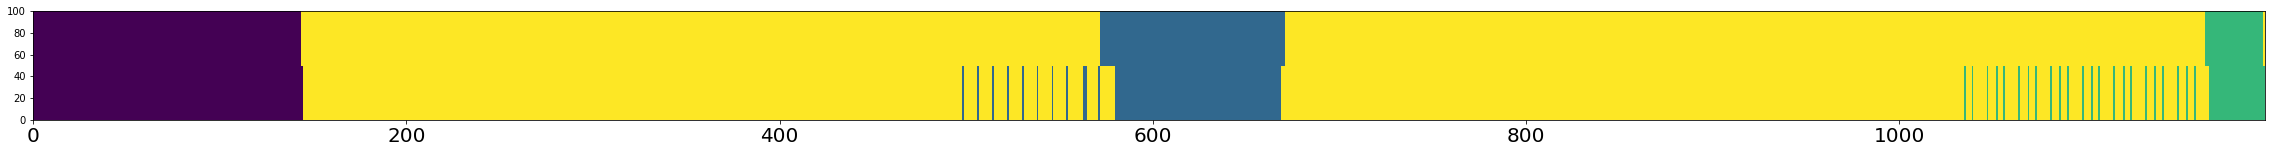

A,P,R:  0.959866220735786 0.8791946308724832 0.9562043795620438
Num frames:  (298, 36)
Accuracy:  0.959866220735786
Person:  26
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


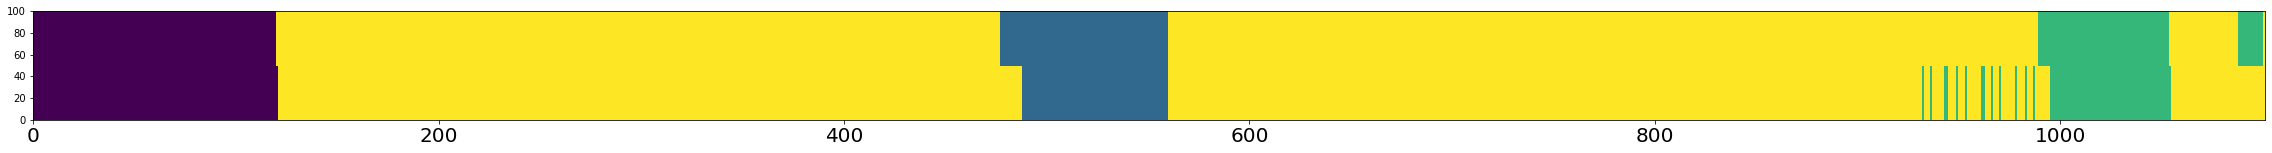

A,P,R:  0.9600363306085377 0.943609022556391 0.8964285714285715
Num frames:  (266, 15)
Accuracy:  0.9600363306085377
Person:  27
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


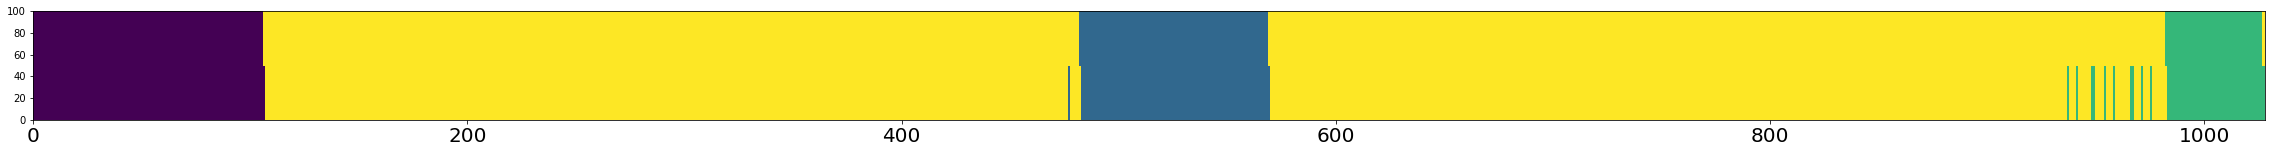

A,P,R:  0.9844357976653697 0.944 0.9915966386554622
Num frames:  (250, 14)
Accuracy:  0.9844357976653697
Person:  28
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


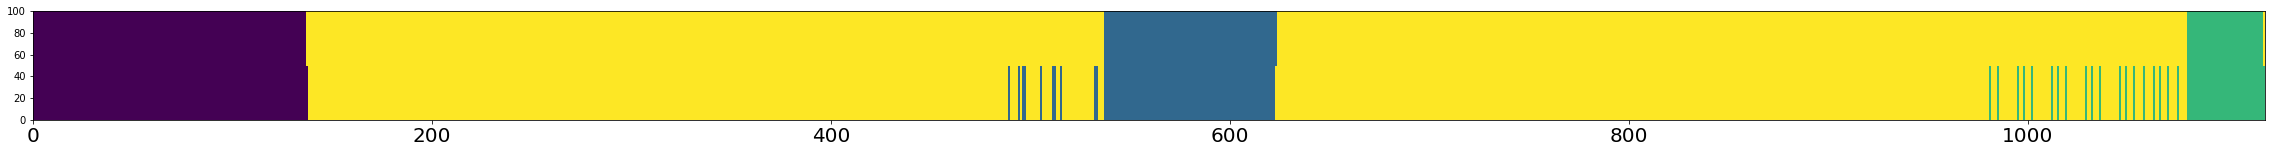

A,P,R:  0.9714030384271671 0.8938356164383562 0.9961832061068703
Num frames:  (292, 31)
Accuracy:  0.9714030384271671
Person:  29
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


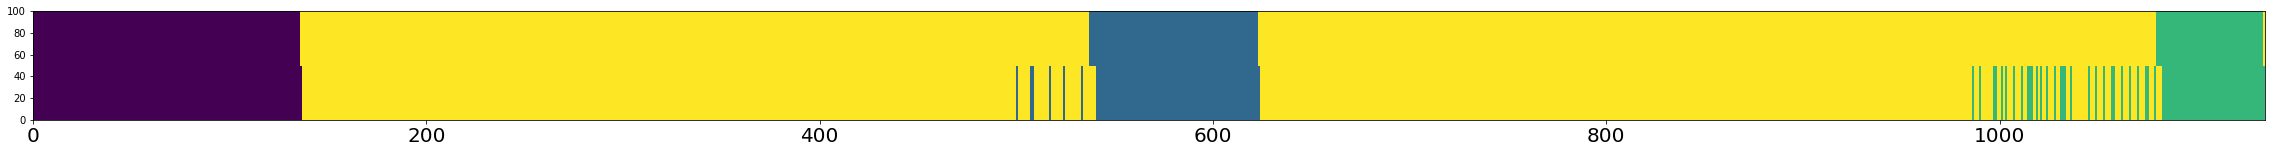

A,P,R:  0.9594713656387666 0.8733766233766234 0.9746376811594203
Num frames:  (308, 39)
Accuracy:  0.9594713656387666
Person:  30
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


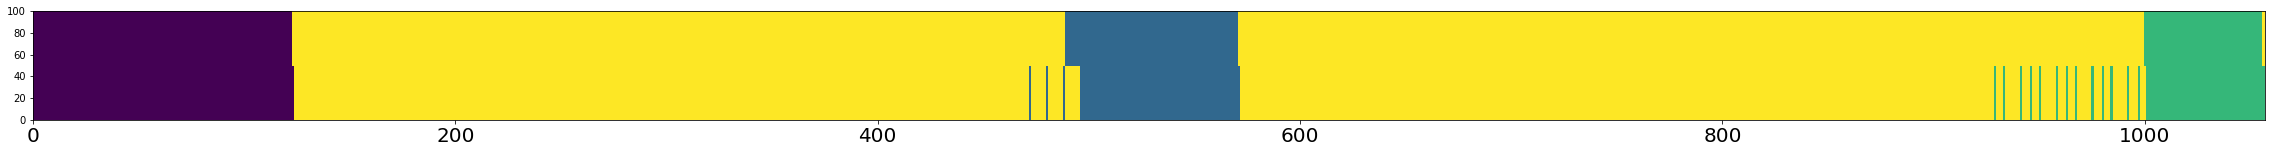

A,P,R:  0.9744560075685903 0.9301470588235294 0.9693486590038314
Num frames:  (272, 19)
Accuracy:  0.9744560075685903
Person:  31
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


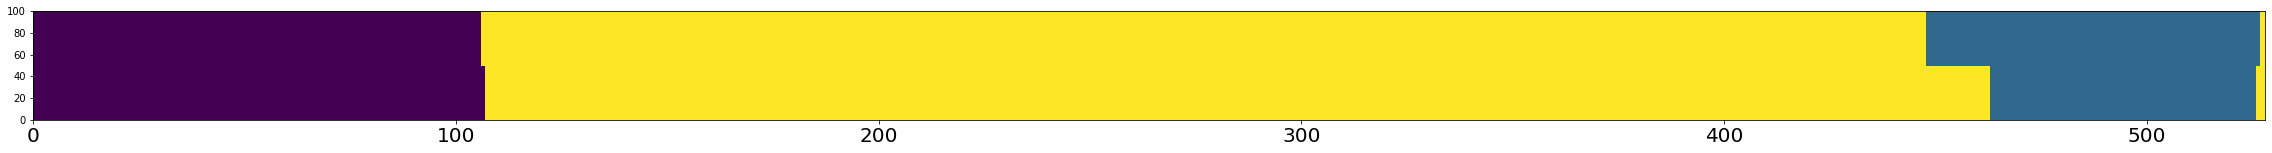

A,P,R:  0.9678030303030303 0.9941176470588236 0.9135135135135135
Num frames:  (170, 1)
Accuracy:  0.9678030303030303
Person:  32
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


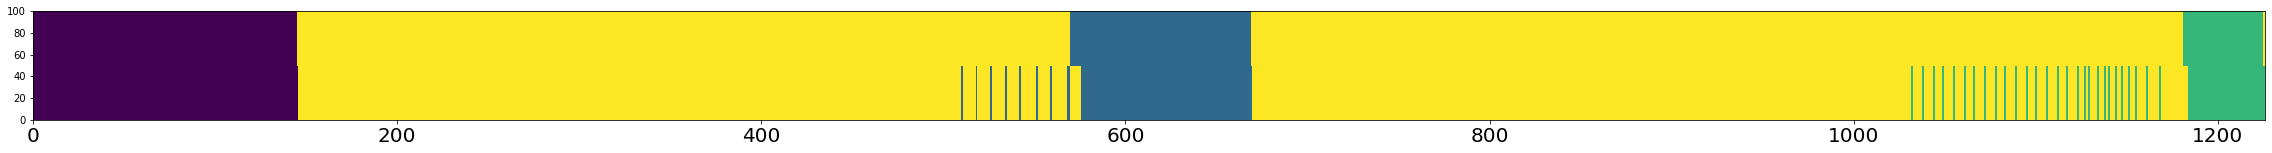

A,P,R:  0.9600326264274062 0.8746081504702194 0.96875
Num frames:  (319, 40)
Accuracy:  0.9600326264274062
Person:  33
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


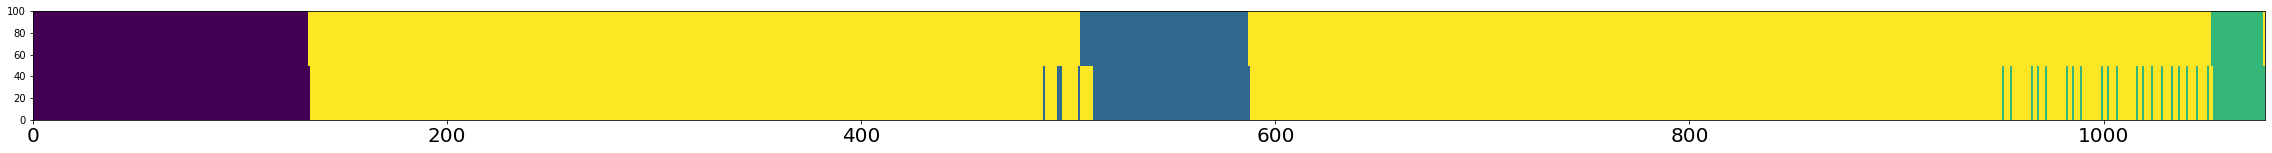

A,P,R:  0.9684601113172542 0.8957528957528957 0.9707112970711297
Num frames:  (259, 27)
Accuracy:  0.9684601113172542
Person:  34
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


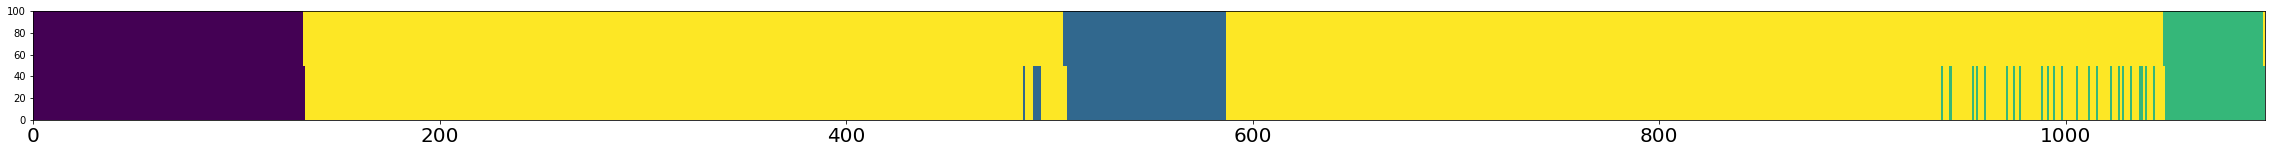

A,P,R:  0.9699453551912568 0.8961937716262975 0.9885496183206107
Num frames:  (289, 30)
Accuracy:  0.9699453551912568
Person:  35
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


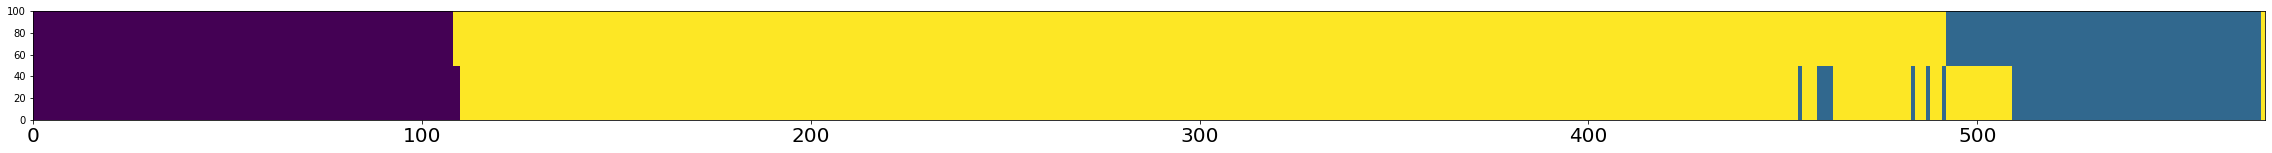

A,P,R:  0.9529616724738676 0.945054945054945 0.91005291005291
Num frames:  (182, 10)
Accuracy:  0.9529616724738676
Person:  36
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  3


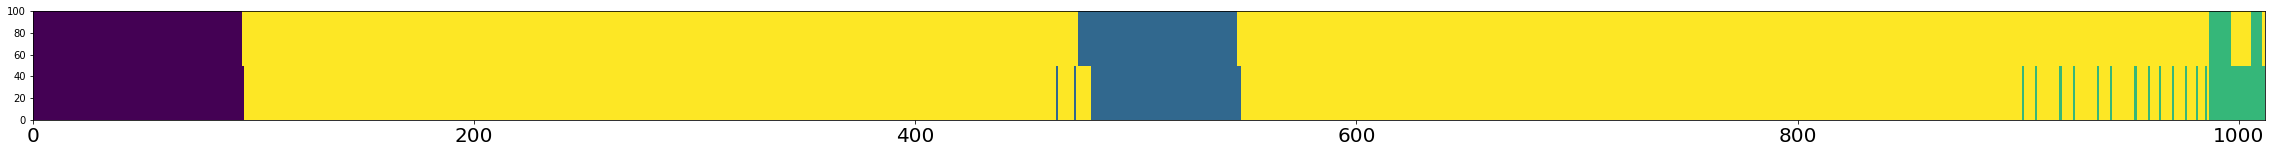

A,P,R:  0.9664031620553359 0.8627450980392157 0.967032967032967
Num frames:  (204, 28)
Accuracy:  0.9664031620553359
Person:  37
Transitions:  [0, 3, 0, 3, 1, 3]
GT transitions:  2
Transitions captured:  2


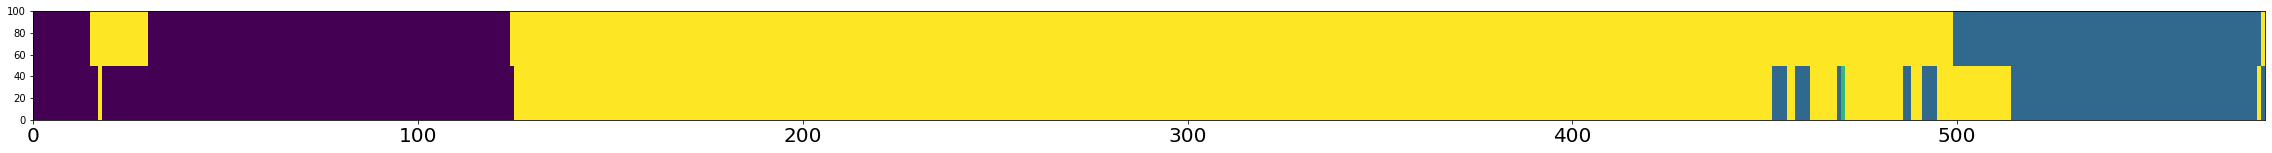

A,P,R:  0.9172413793103448 0.8439024390243902 0.9153439153439153
Num frames:  (205, 32)
Accuracy:  0.9172413793103448
Person:  38
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


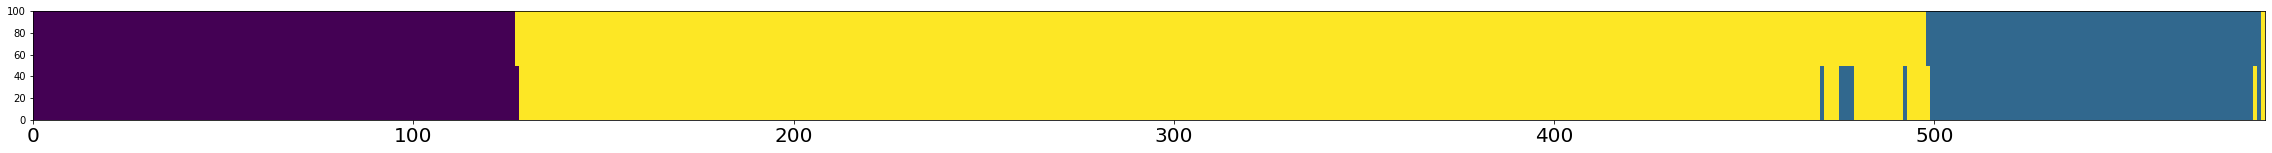

A,P,R:  0.9846678023850085 0.9681818181818181 0.9906976744186047
Num frames:  (220, 7)
Accuracy:  0.9846678023850085
Person:  39
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


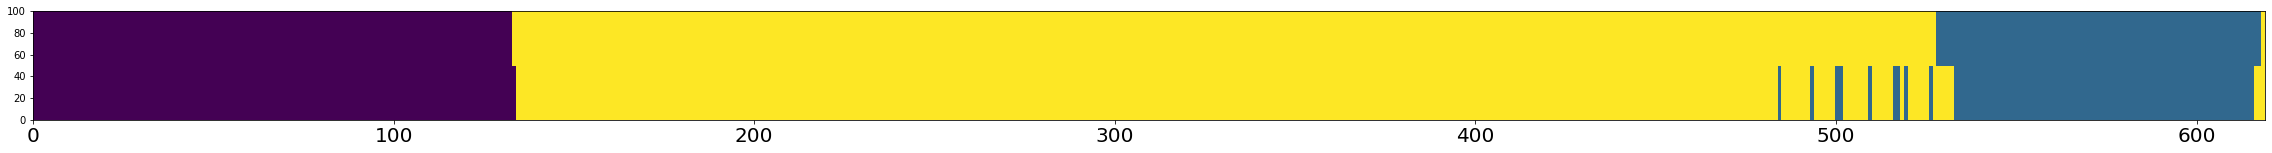

A,P,R:  0.9725363489499192 0.9557522123893806 0.968609865470852
Num frames:  (226, 10)
Accuracy:  0.9725363489499192
Person:  40
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  4
Transitions captured:  3


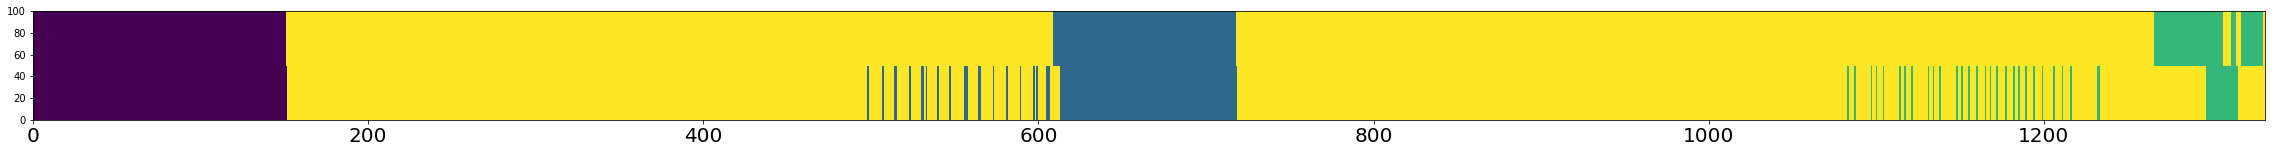

A,P,R:  0.9204204204204204 0.8226299694189603 0.8485804416403786
Num frames:  (327, 58)
Accuracy:  0.9204204204204204
Person:  41
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


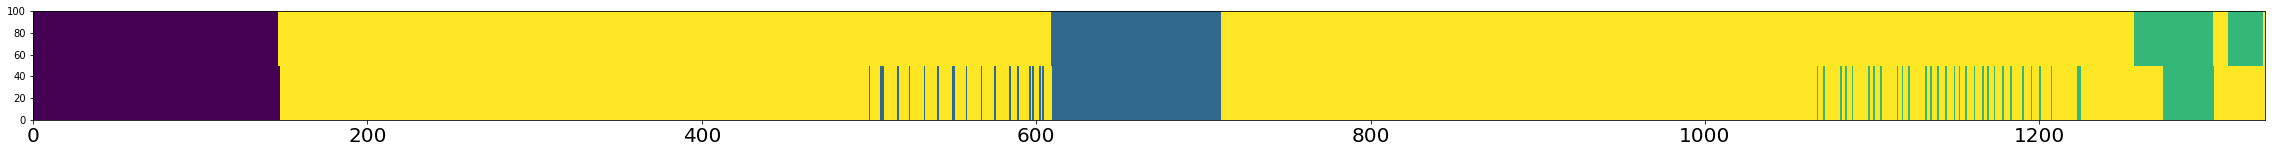

A,P,R:  0.9333333333333333 0.8475609756097561 0.8769716088328076
Num frames:  (328, 50)
Accuracy:  0.9333333333333333
Person:  42
Transitions:  [0, 3, 0, 3, 1, 3]
GT transitions:  2
Transitions captured:  2


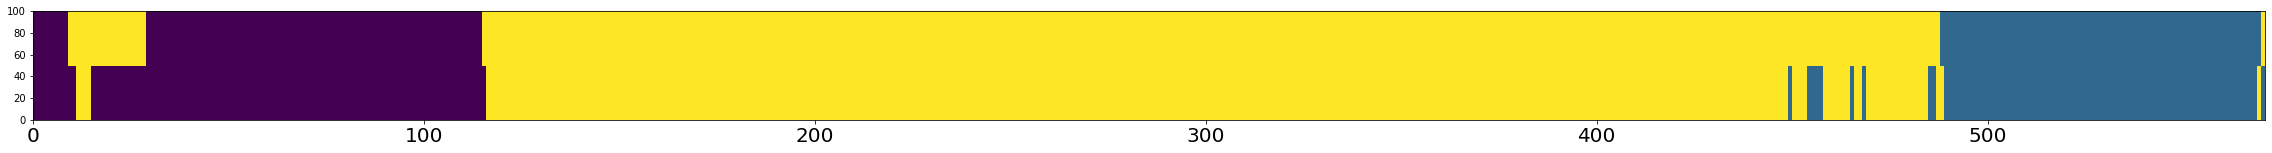

A,P,R:  0.9492119089316988 0.8663366336633663 0.9887005649717514
Num frames:  (202, 27)
Accuracy:  0.9492119089316988
Person:  43
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


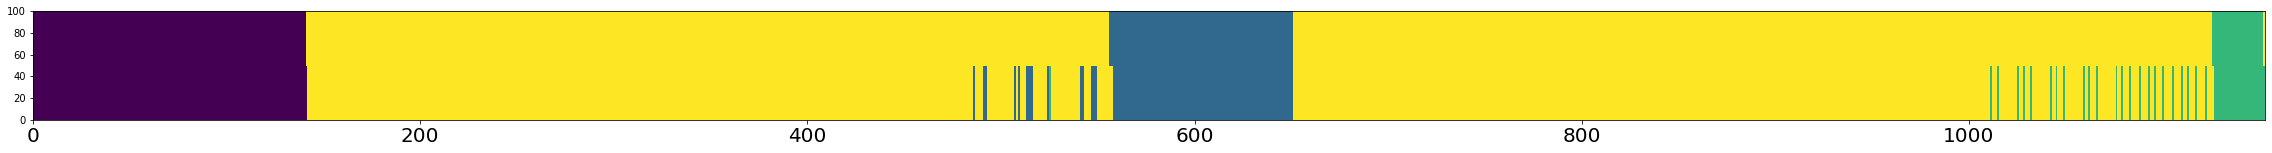

A,P,R:  0.9618386816999133 0.8633333333333333 0.9885496183206107
Num frames:  (300, 41)
Accuracy:  0.9618386816999133
Person:  44
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


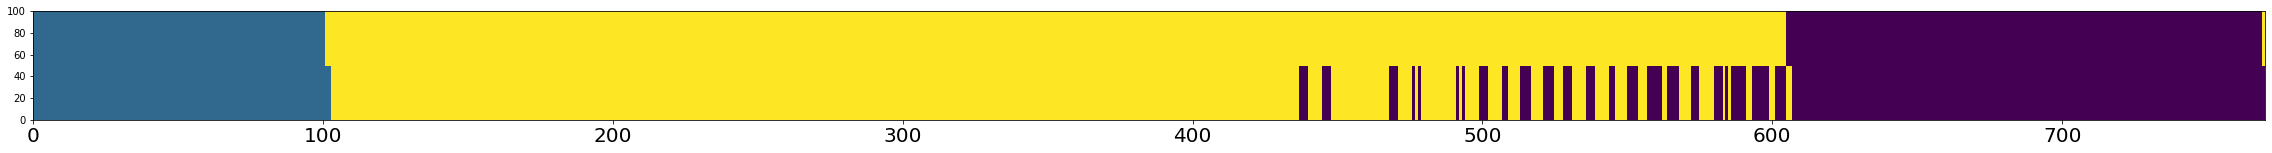

A,P,R:  0.9038961038961039 0.7850746268656716 0.9924528301886792
Num frames:  (335, 72)
Accuracy:  0.9038961038961039
Person:  45
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


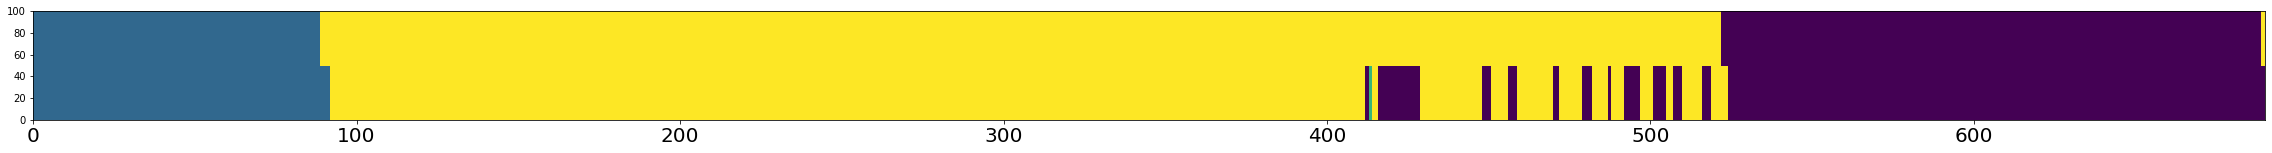

A,P,R:  0.9304347826086956 0.8466666666666667 0.9921875
Num frames:  (300, 46)
Accuracy:  0.9304347826086956
Person:  46
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


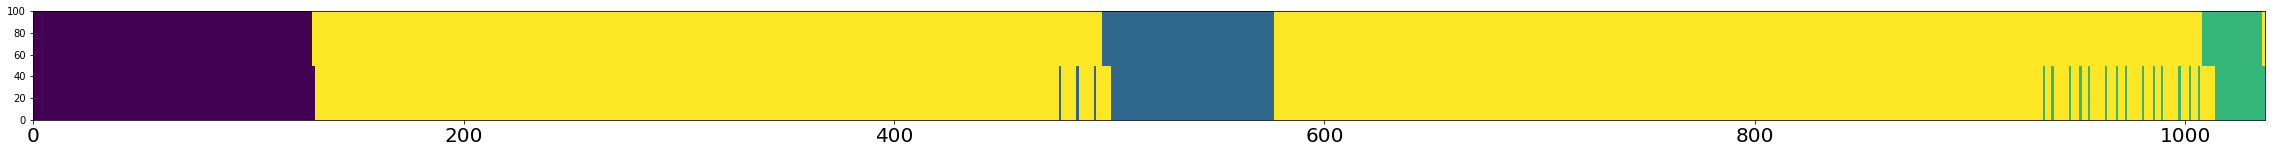

A,P,R:  0.9720347155255545 0.9230769230769231 0.957983193277311
Num frames:  (247, 19)
Accuracy:  0.9720347155255545
Person:  47
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


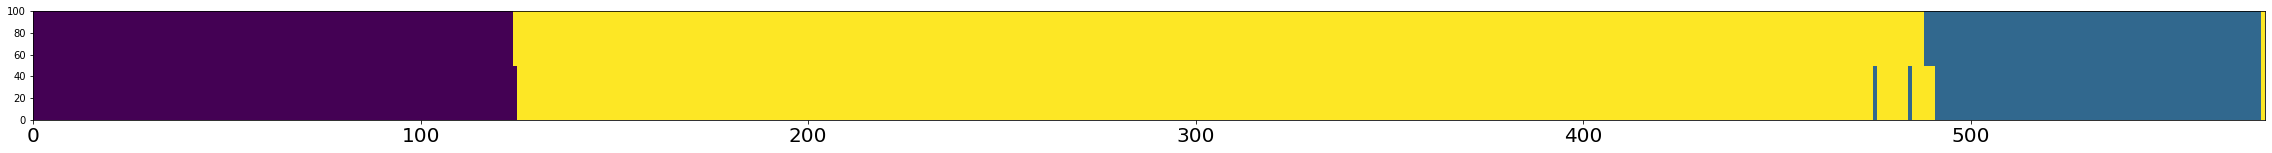

A,P,R:  0.9895833333333334 0.985781990521327 0.985781990521327
Num frames:  (211, 3)
Accuracy:  0.9895833333333334
Person:  48
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


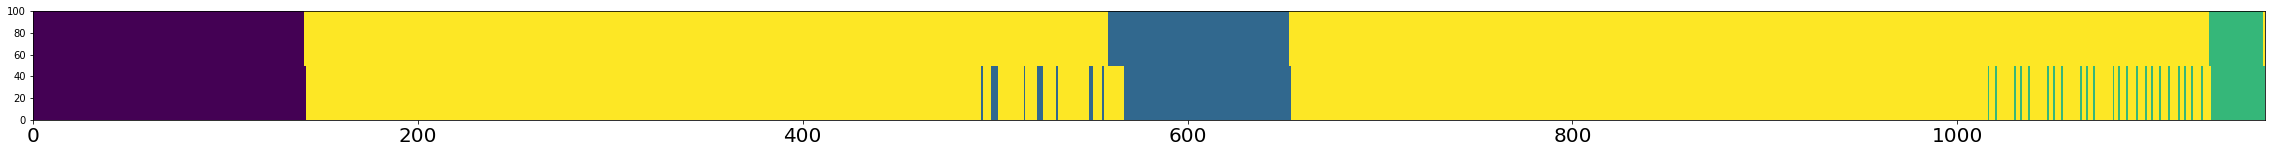

A,P,R:  0.9586206896551724 0.8668941979522184 0.9657794676806084
Num frames:  (293, 39)
Accuracy:  0.9586206896551724
Person:  49
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


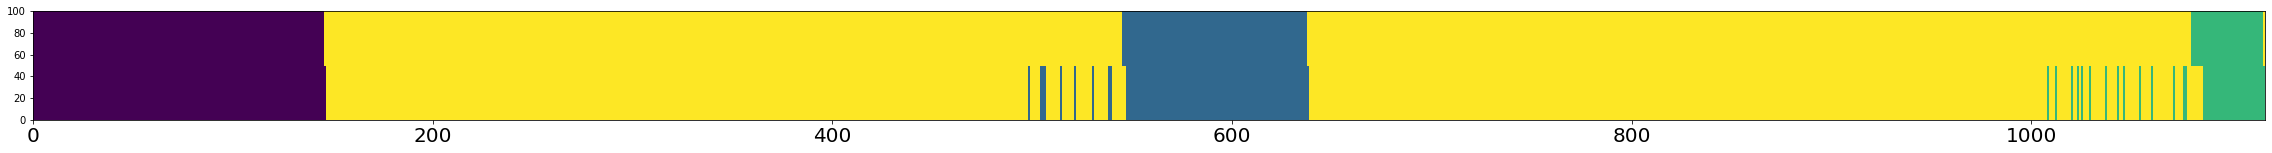

A,P,R:  0.9695613249776186 0.9112627986348123 0.9709090909090909
Num frames:  (293, 26)
Accuracy:  0.9695613249776186
Person:  50
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


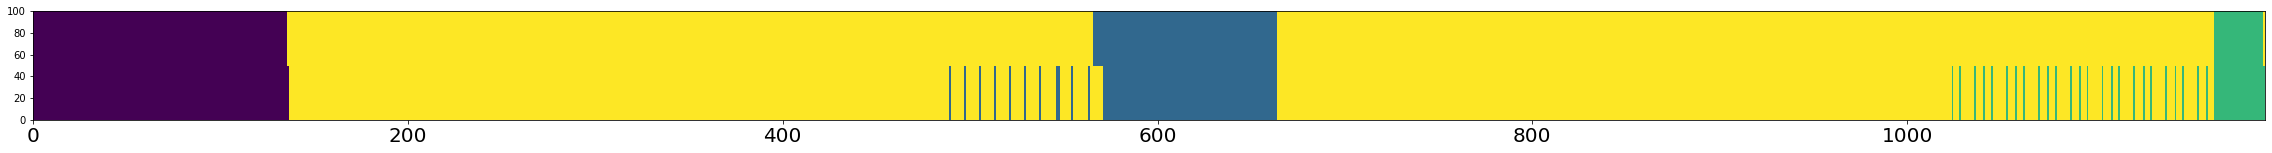

A,P,R:  0.9638958858102435 0.8703071672354948 0.9807692307692307
Num frames:  (293, 38)
Accuracy:  0.9638958858102435
Person:  51
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


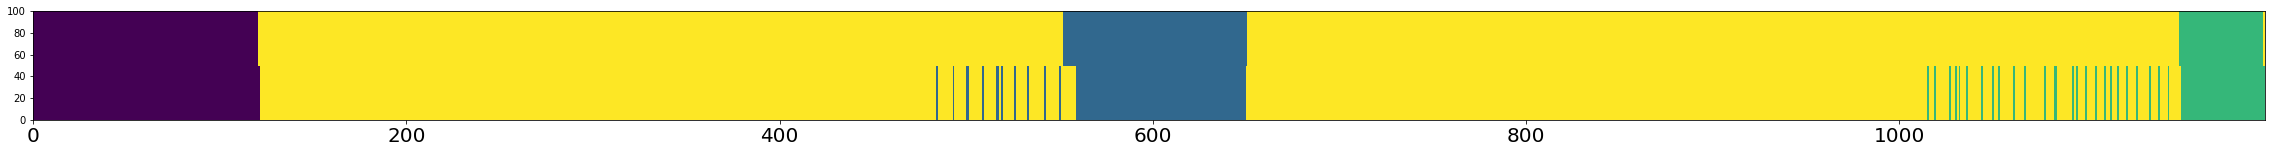

A,P,R:  0.9590301003344481 0.8648648648648649 0.9660377358490566
Num frames:  (296, 40)
Accuracy:  0.9590301003344481
Person:  52
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


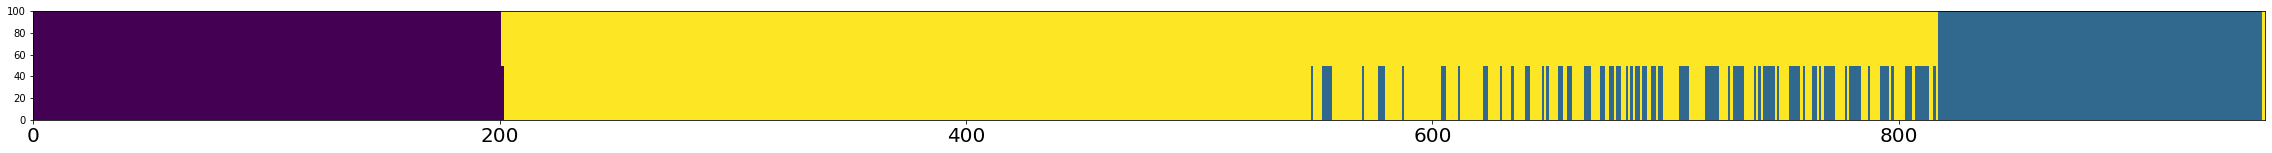

A,P,R:  0.890282131661442 0.7640449438202247 1.0
Num frames:  (445, 105)
Accuracy:  0.890282131661442
Person:  53
Transitions:  [0, 3, 0, 3, 1, 3]
GT transitions:  2
Transitions captured:  2


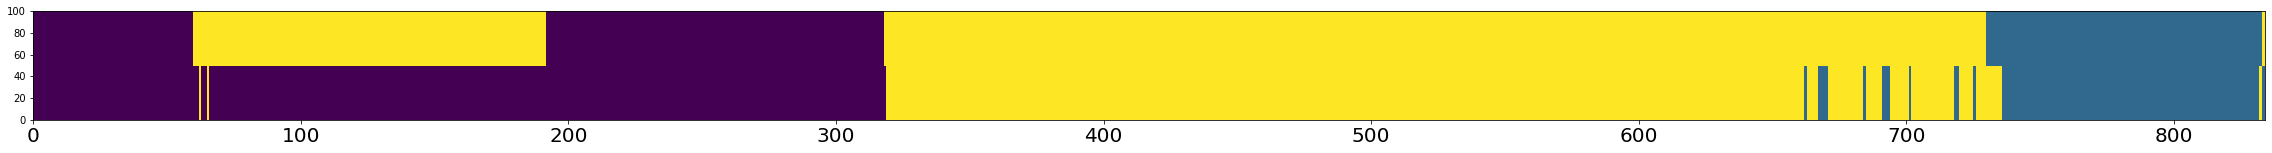

A,P,R:  0.8177458033573142 0.6604215456674473 0.9757785467128027
Num frames:  (427, 145)
Accuracy:  0.8177458033573142
Person:  54
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


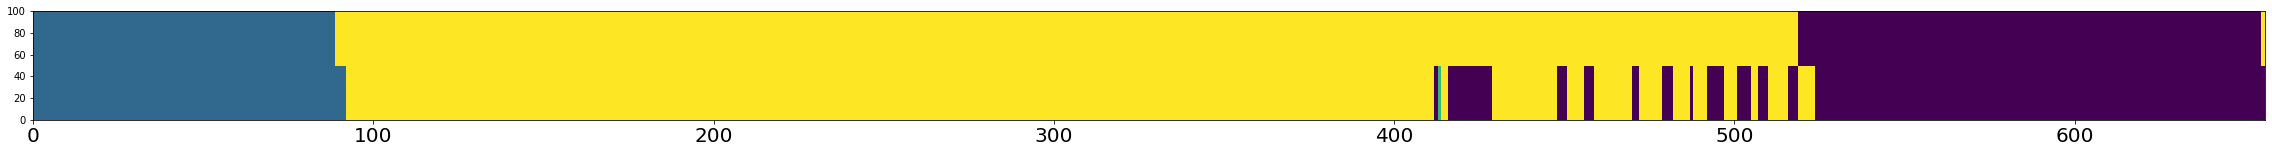

A,P,R:  0.9222560975609756 0.8270676691729323 0.9777777777777777
Num frames:  (266, 46)
Accuracy:  0.9222560975609756
Person:  55
Transitions:  [1, 3, 0, 3, 0, 3]
GT transitions:  2
Transitions captured:  2


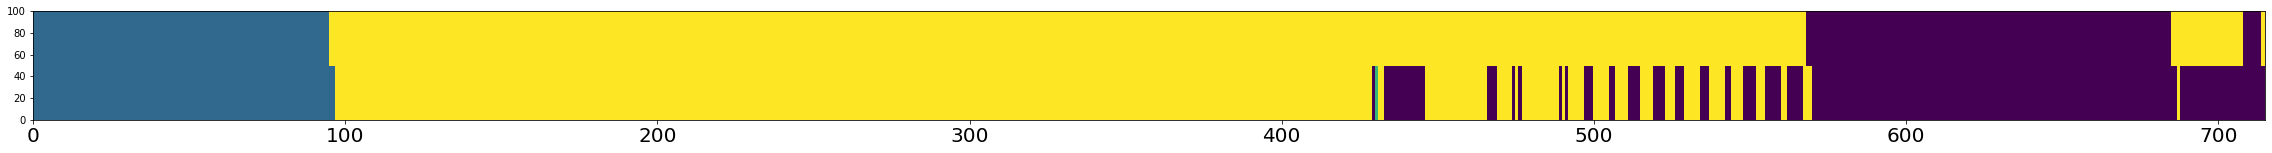

A,P,R:  0.8825174825174825 0.7248322147651006 0.9908256880733946
Num frames:  (298, 82)
Accuracy:  0.8825174825174825
Person:  56
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


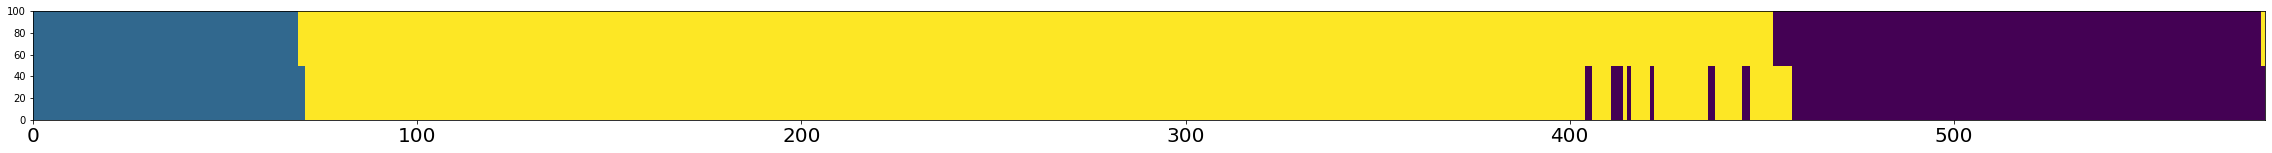

A,P,R:  0.9672977624784854 0.9317073170731708 0.9744897959183674
Num frames:  (205, 14)
Accuracy:  0.9672977624784854
Person:  57
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  1


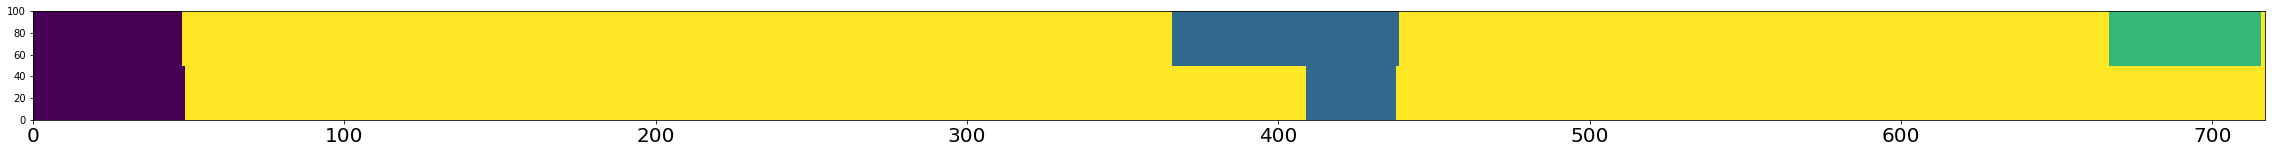

A,P,R:  0.8688981868898187 0.9871794871794872 0.45294117647058824
Num frames:  (78, 1)
Accuracy:  0.8688981868898187
Person:  58
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


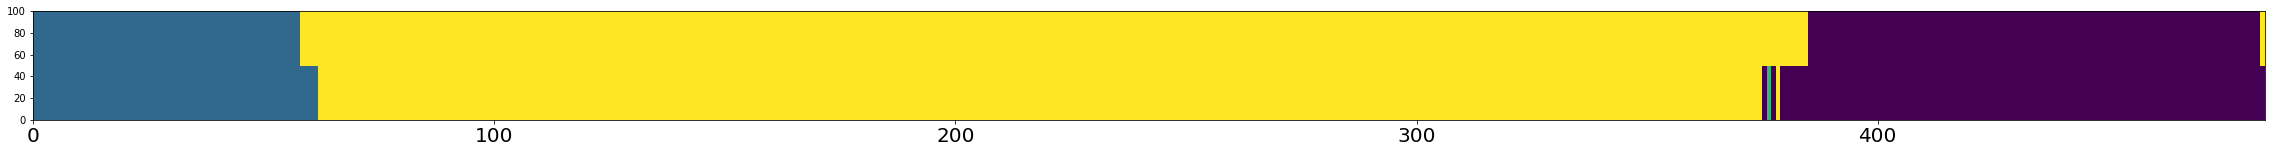

A,P,R:  0.9710743801652892 0.9176470588235294 1.0
Num frames:  (170, 14)
Accuracy:  0.9710743801652892
Person:  59
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


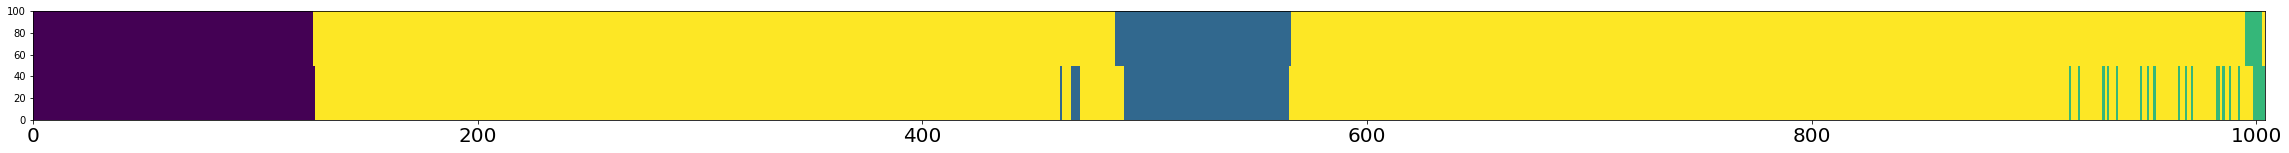

A,P,R:  0.9681274900398407 0.8986784140969163 0.9577464788732394
Num frames:  (227, 23)
Accuracy:  0.9681274900398407
Person:  60
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


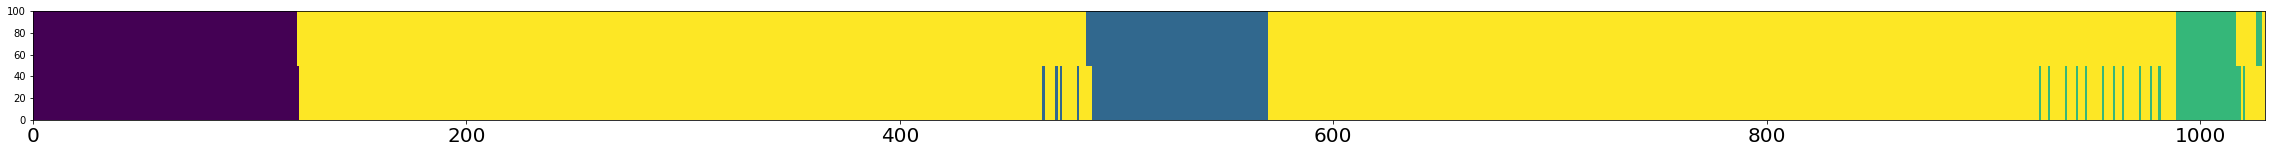

A,P,R:  0.9757281553398058 0.924 0.9746835443037974
Num frames:  (250, 19)
Accuracy:  0.9757281553398058
Person:  61
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


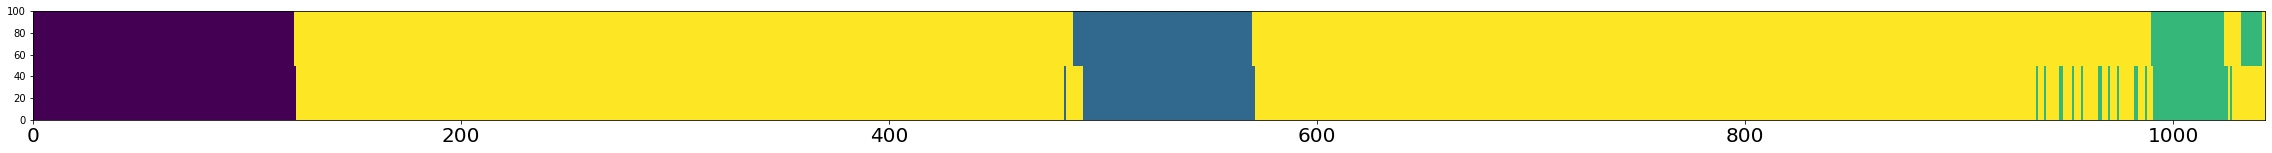

A,P,R:  0.9664429530201343 0.924901185770751 0.936
Num frames:  (253, 19)
Accuracy:  0.9664429530201343
Person:  62
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


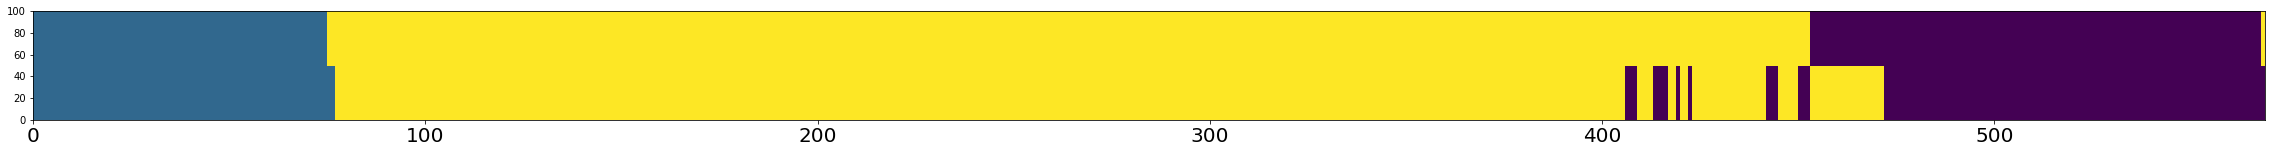

A,P,R:  0.9349736379613357 0.9047619047619048 0.9
Num frames:  (189, 18)
Accuracy:  0.9349736379613357
Person:  63
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


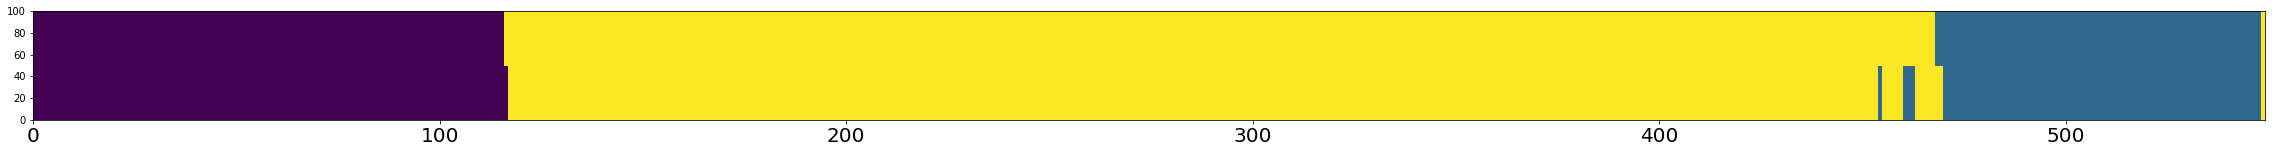

A,P,R:  0.9872495446265938 0.9748743718592965 0.9897959183673469
Num frames:  (199, 5)
Accuracy:  0.9872495446265938
Person:  64
Transitions:  [0, 3, 0, 3, 1, 3]
GT transitions:  2
Transitions captured:  2


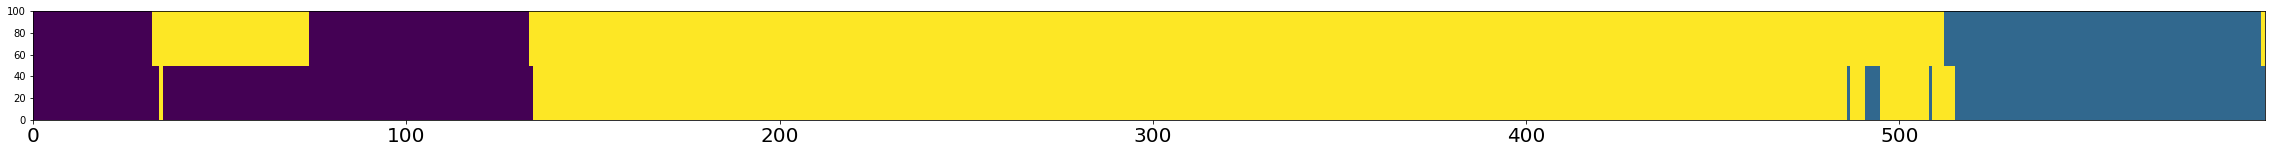

A,P,R:  0.9130434782608695 0.7792792792792793 0.9829545454545454
Num frames:  (222, 49)
Accuracy:  0.9130434782608695
Person:  65
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


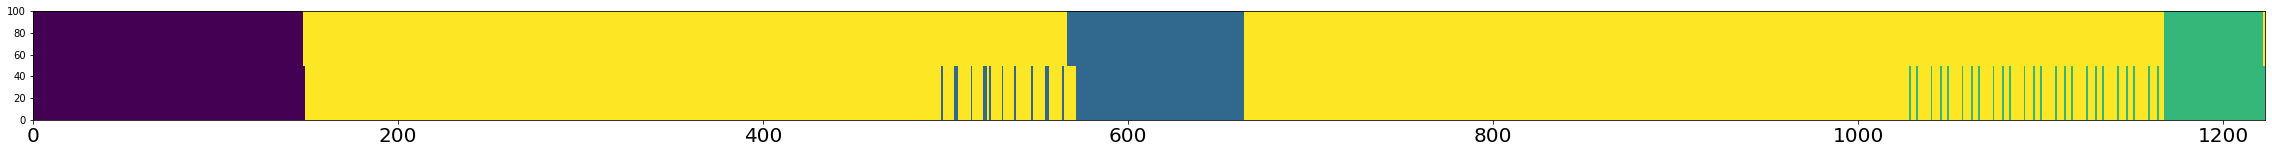

A,P,R:  0.9632052330335241 0.8802395209580839 0.9832775919732442
Num frames:  (334, 40)
Accuracy:  0.9632052330335241
Person:  66
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


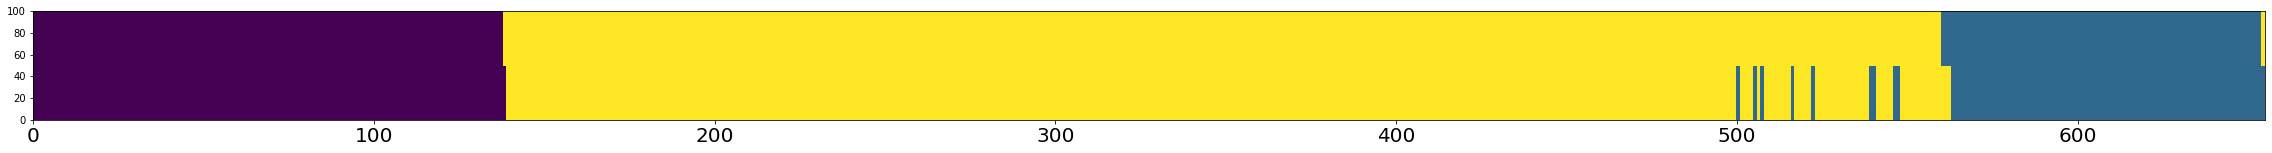

A,P,R:  0.9786259541984733 0.9541666666666667 0.9870689655172413
Num frames:  (240, 11)
Accuracy:  0.9786259541984733
Person:  67
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


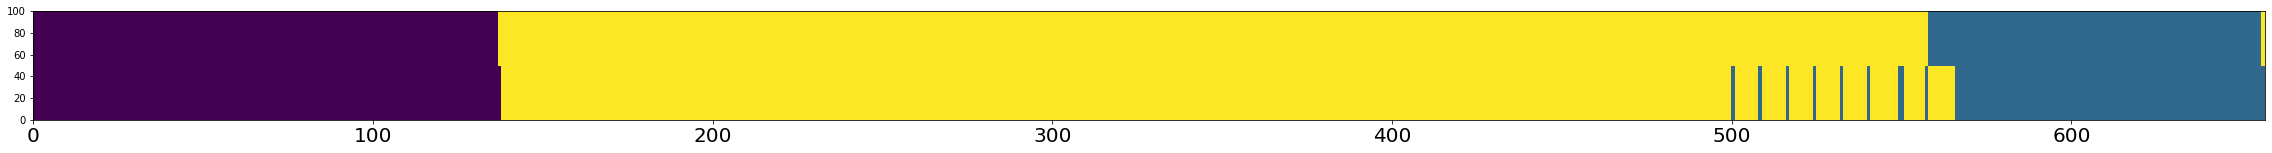

A,P,R:  0.9710806697108066 0.9537815126050421 0.9659574468085106
Num frames:  (238, 11)
Accuracy:  0.9710806697108066
Person:  68
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  1


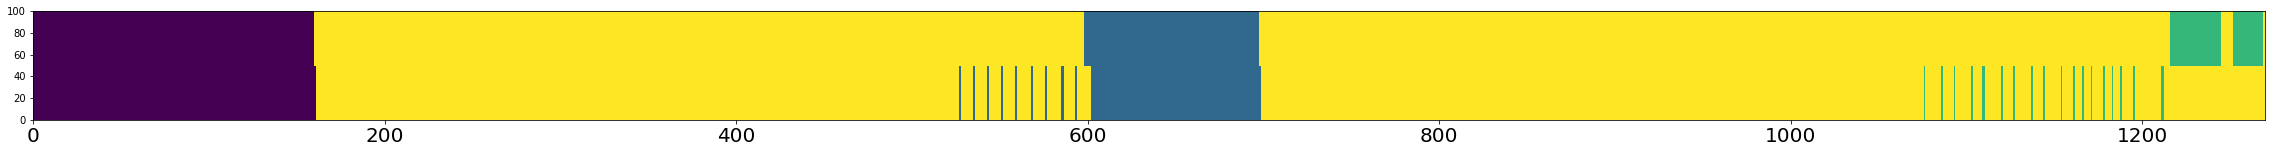

A,P,R:  0.9354330708661417 0.8888888888888888 0.8366013071895425
Num frames:  (288, 32)
Accuracy:  0.9354330708661417
Person:  69
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


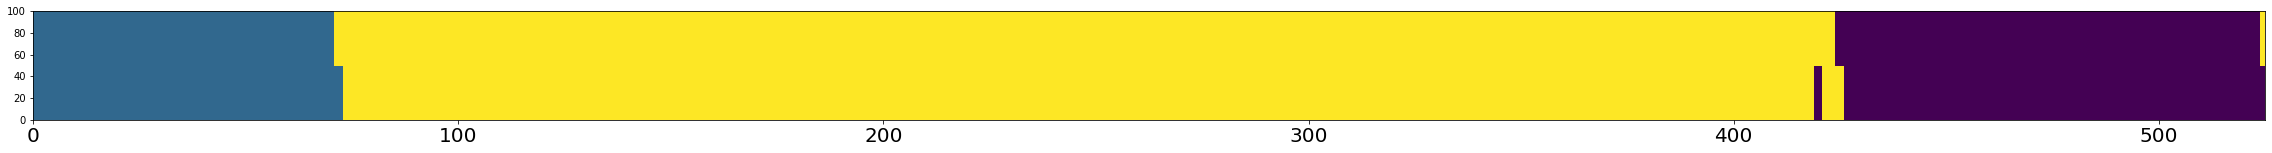

A,P,R:  0.9866666666666667 0.9712643678160919 0.9883040935672515
Num frames:  (174, 5)
Accuracy:  0.9866666666666667
Person:  70
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


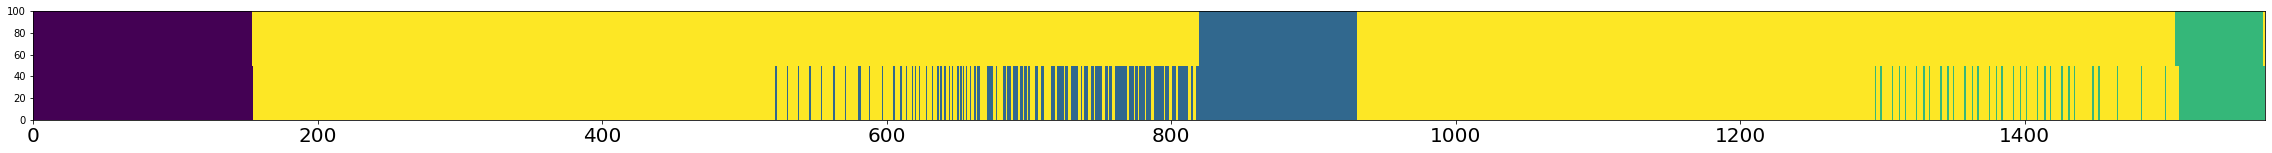

A,P,R:  0.8948374760994264 0.6666666666666666 0.9908256880733946
Num frames:  (486, 162)
Accuracy:  0.8948374760994264
Person:  71
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


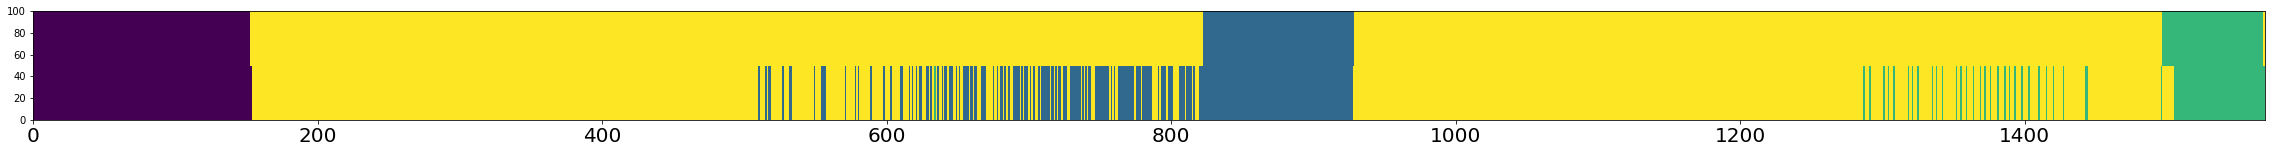

A,P,R:  0.8789037603569152 0.6394422310756972 0.9727272727272728
Num frames:  (502, 181)
Accuracy:  0.8789037603569152
Person:  72
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


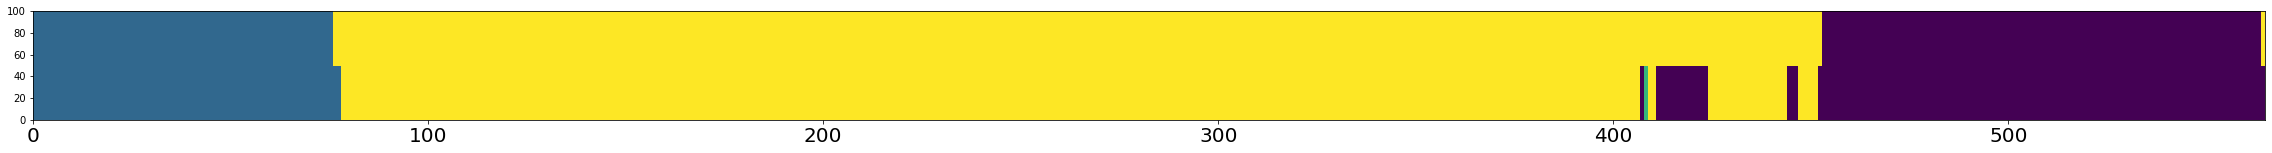

A,P,R:  0.9610619469026549 0.8947368421052632 1.0
Num frames:  (209, 22)
Accuracy:  0.9610619469026549
Person:  73
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


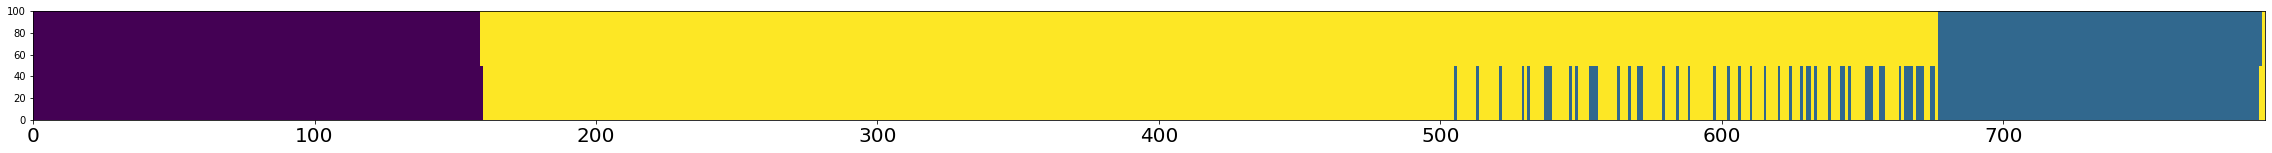

A,P,R:  0.935687263556116 0.8452012383900929 0.9963503649635036
Num frames:  (323, 50)
Accuracy:  0.935687263556116
Person:  74
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


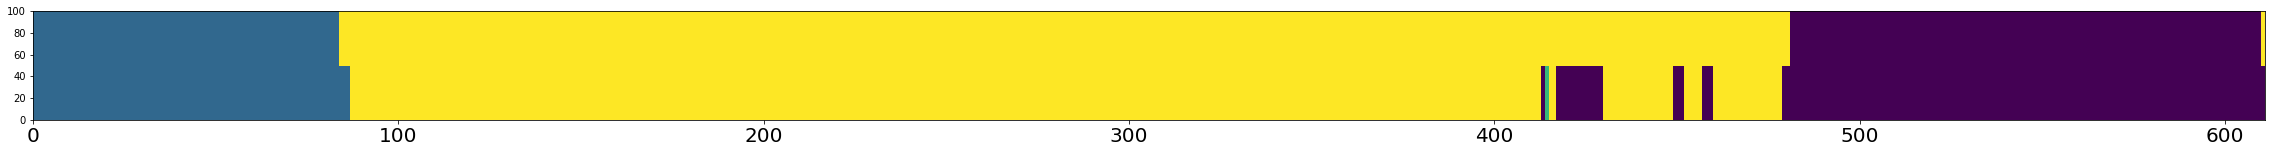

A,P,R:  0.955810147299509 0.8875 1.0
Num frames:  (240, 27)
Accuracy:  0.955810147299509
Person:  75
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


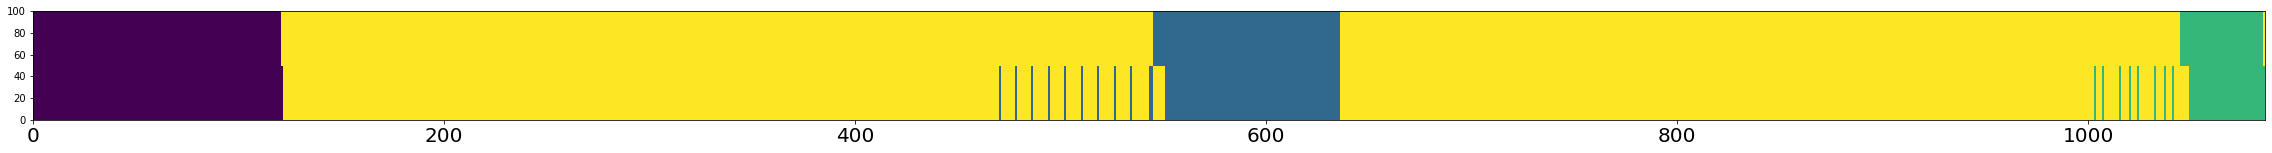

A,P,R:  0.9714548802946593 0.9201520912547528 0.9603174603174603
Num frames:  (263, 21)
Accuracy:  0.9714548802946593
Person:  76
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


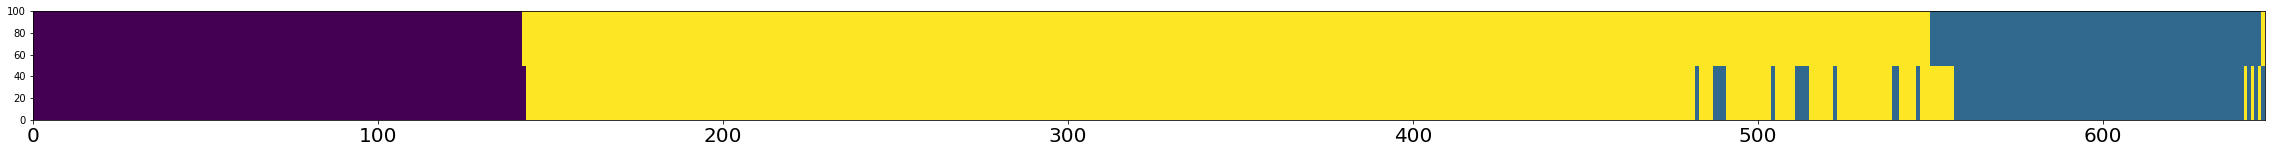

A,P,R:  0.9598145285935085 0.9344262295081968 0.957983193277311
Num frames:  (244, 16)
Accuracy:  0.9598145285935085
Person:  77
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


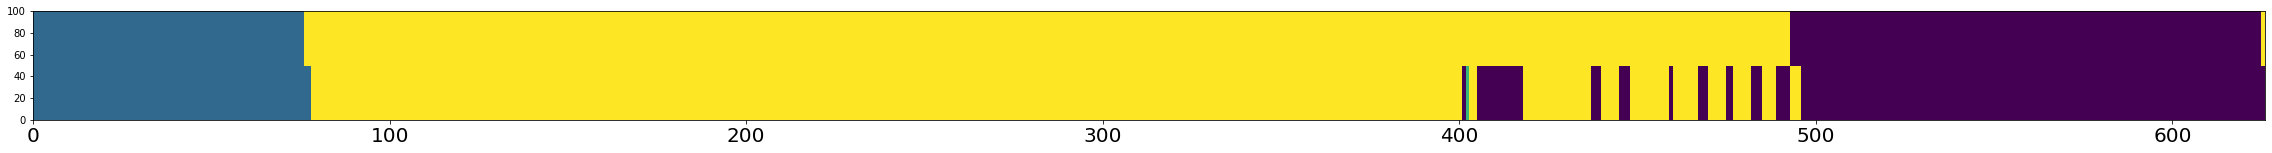

A,P,R:  0.9361022364217252 0.8471074380165289 0.9855769230769231
Num frames:  (242, 37)
Accuracy:  0.9361022364217252
Person:  78
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


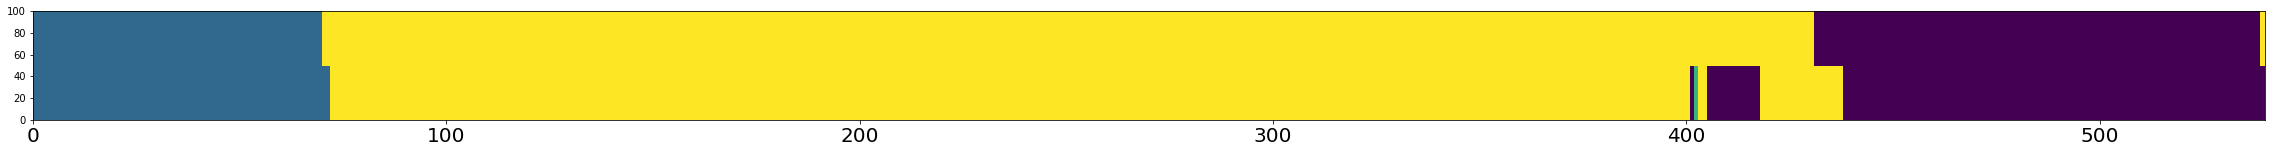

A,P,R:  0.9537037037037037 0.9047619047619048 0.9606741573033708
Num frames:  (189, 18)
Accuracy:  0.9537037037037037
Person:  79
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


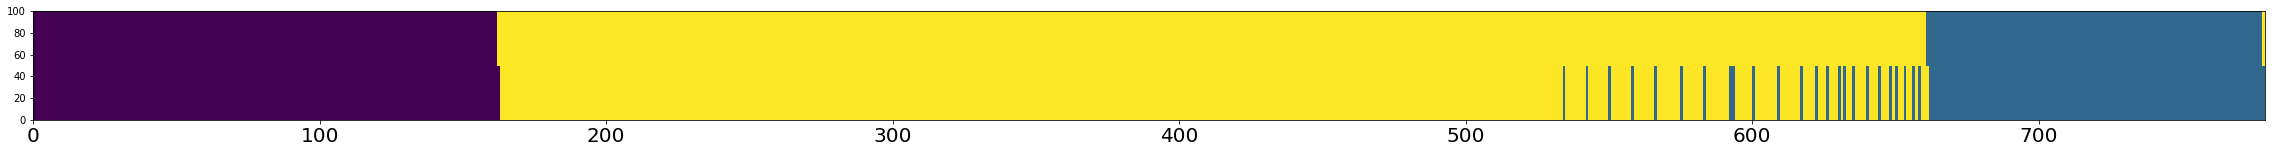

A,P,R:  0.9653401797175867 0.9144736842105263 0.996415770609319
Num frames:  (304, 26)
Accuracy:  0.9653401797175867
Person:  80
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


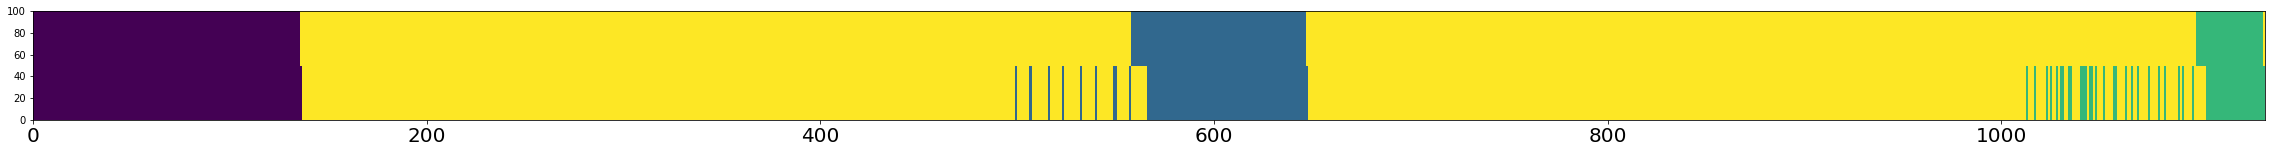

A,P,R:  0.9523809523809523 0.8571428571428571 0.9498069498069498
Num frames:  (287, 41)
Accuracy:  0.9523809523809523
Person:  81
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


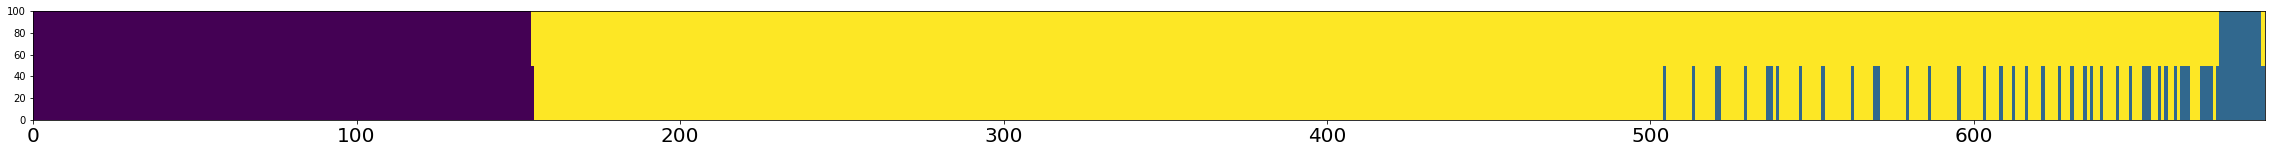

A,P,R:  0.936231884057971 0.7914691943127962 1.0
Num frames:  (211, 44)
Accuracy:  0.936231884057971
Person:  82
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


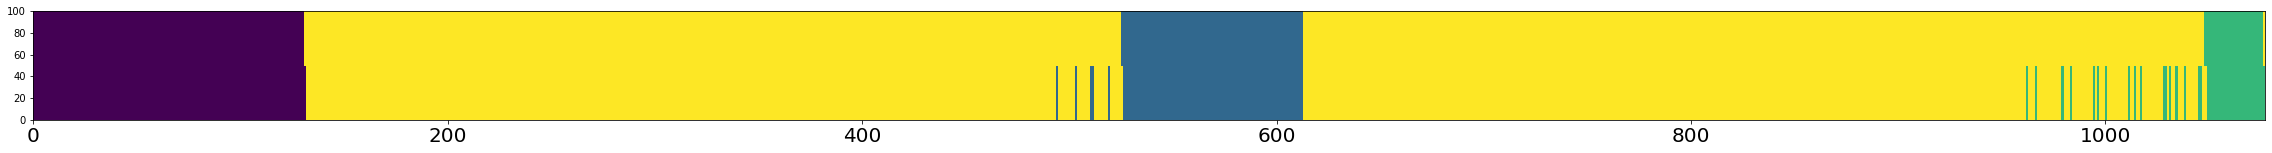

A,P,R:  0.9758588672237697 0.9107806691449815 0.9919028340080972
Num frames:  (269, 24)
Accuracy:  0.9758588672237697
Person:  83
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  3


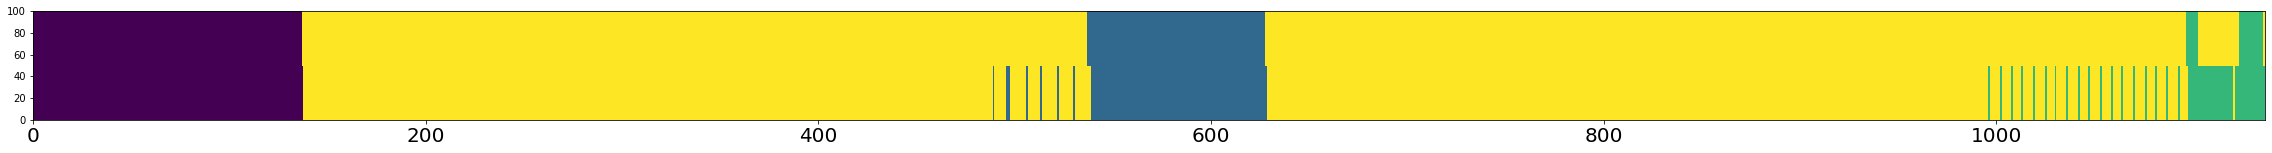

A,P,R:  0.9551451187335093 0.8350515463917526 0.9878048780487805
Num frames:  (291, 48)
Accuracy:  0.9551451187335093
Person:  84
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


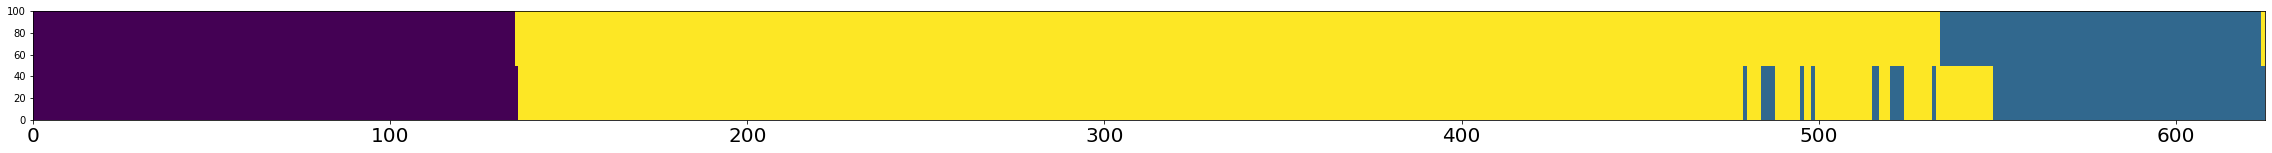

A,P,R:  0.9504 0.9292035398230089 0.9333333333333333
Num frames:  (226, 16)
Accuracy:  0.9504
Person:  85
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


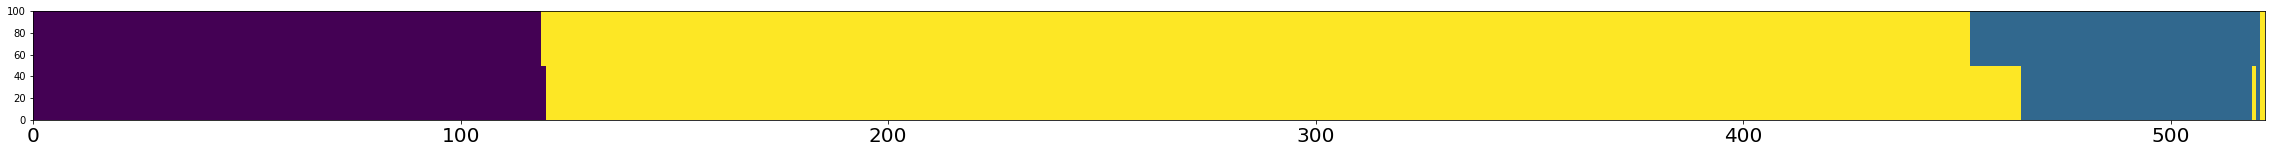

A,P,R:  0.9731800766283525 0.9942857142857143 0.93048128342246
Num frames:  (175, 1)
Accuracy:  0.9731800766283525
Person:  86
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


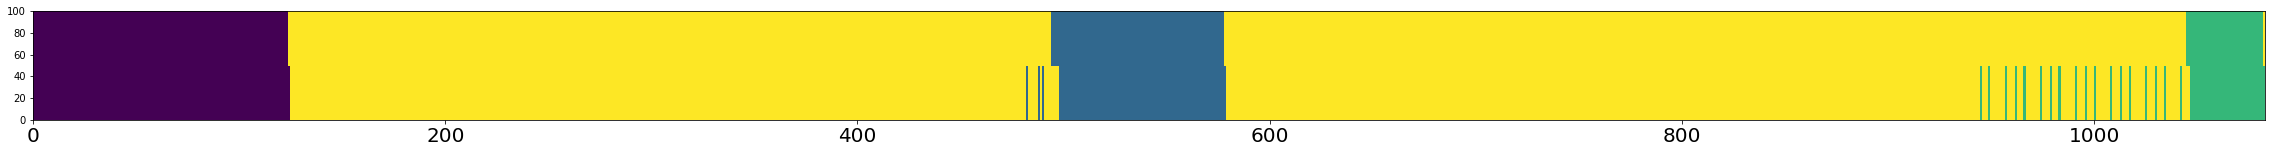

A,P,R:  0.9722991689750693 0.908745247148289 0.9755102040816327
Num frames:  (263, 24)
Accuracy:  0.9722991689750693
Person:  87
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


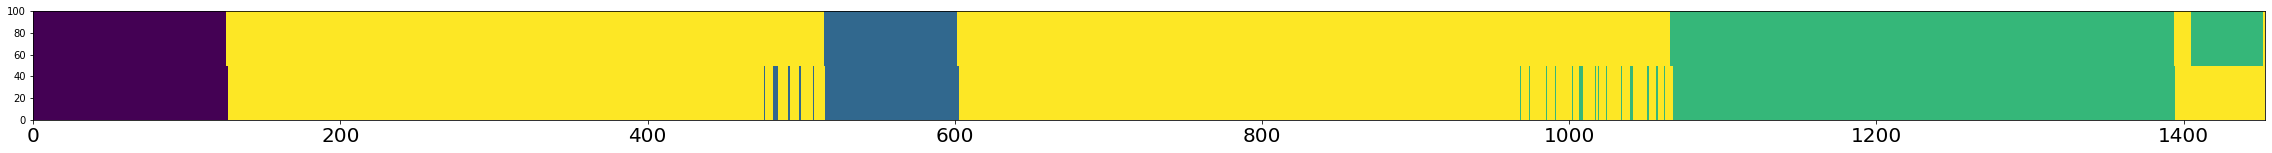

A,P,R:  0.9476944253269098 0.9539007092198581 0.9149659863945578
Num frames:  (564, 26)
Accuracy:  0.9476944253269098
Person:  88
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


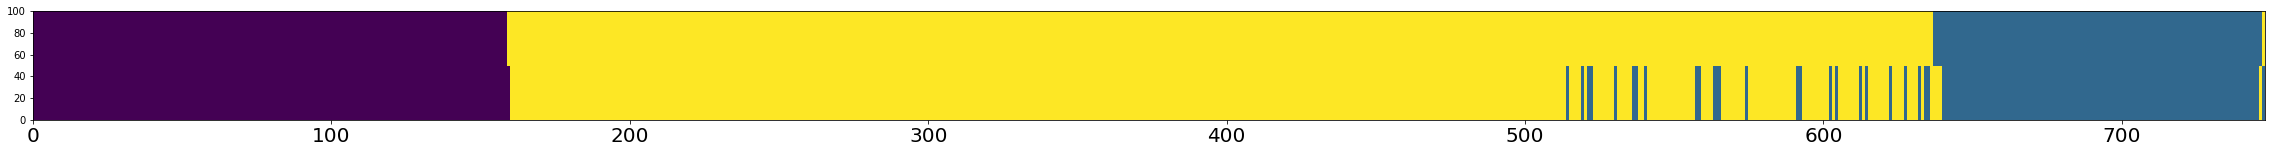

A,P,R:  0.9585561497326203 0.9075342465753424 0.9851301115241635
Num frames:  (292, 27)
Accuracy:  0.9585561497326203
Person:  89
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


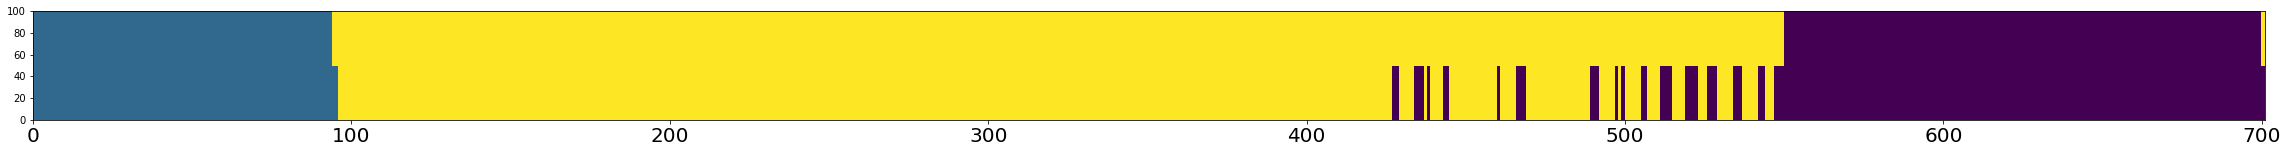

A,P,R:  0.9415121255349501 0.856140350877193 1.0
Num frames:  (285, 41)
Accuracy:  0.9415121255349501
Person:  90
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


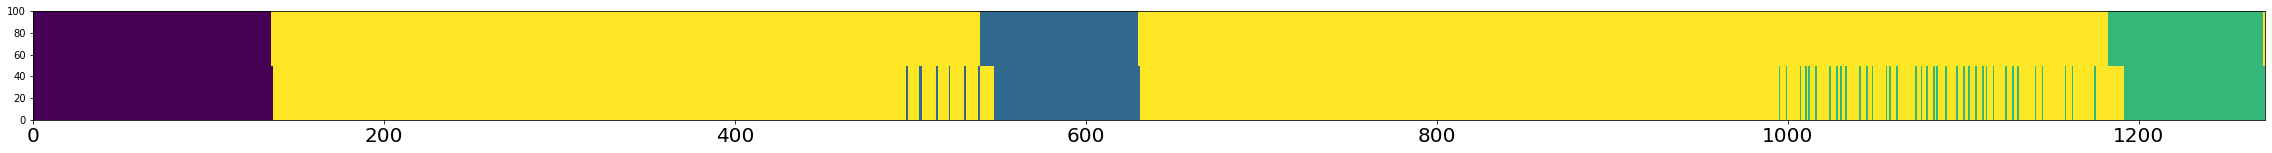

A,P,R:  0.949685534591195 0.8633720930232558 0.945859872611465
Num frames:  (344, 47)
Accuracy:  0.949685534591195
Person:  91
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


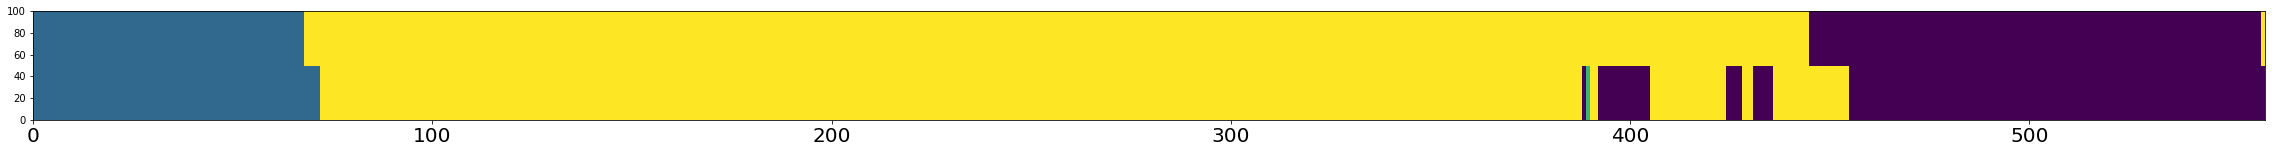

A,P,R:  0.9302325581395349 0.855 0.9447513812154696
Num frames:  (200, 29)
Accuracy:  0.9302325581395349
Person:  92
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


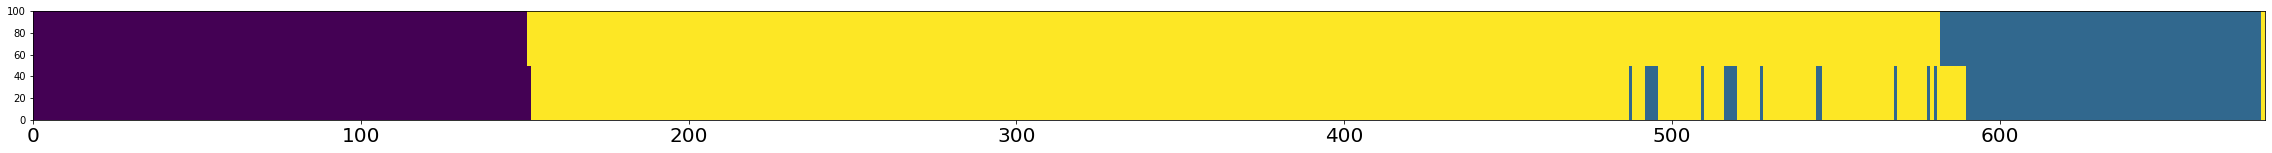

A,P,R:  0.9632892804698973 0.9341085271317829 0.9678714859437751
Num frames:  (258, 17)
Accuracy:  0.9632892804698973
Person:  93
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


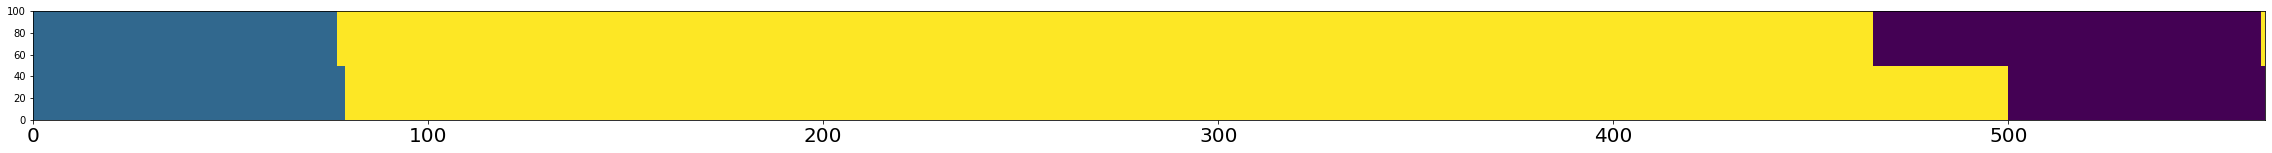

A,P,R:  0.9345132743362832 0.9791666666666666 0.8057142857142857
Num frames:  (144, 3)
Accuracy:  0.9345132743362832
Person:  94
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


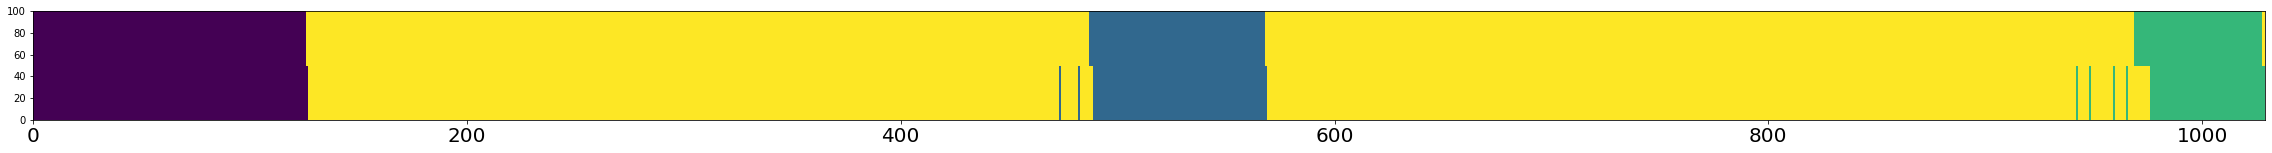

A,P,R:  0.9825072886297376 0.9661654135338346 0.9661654135338346
Num frames:  (266, 9)
Accuracy:  0.9825072886297376
Person:  95
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


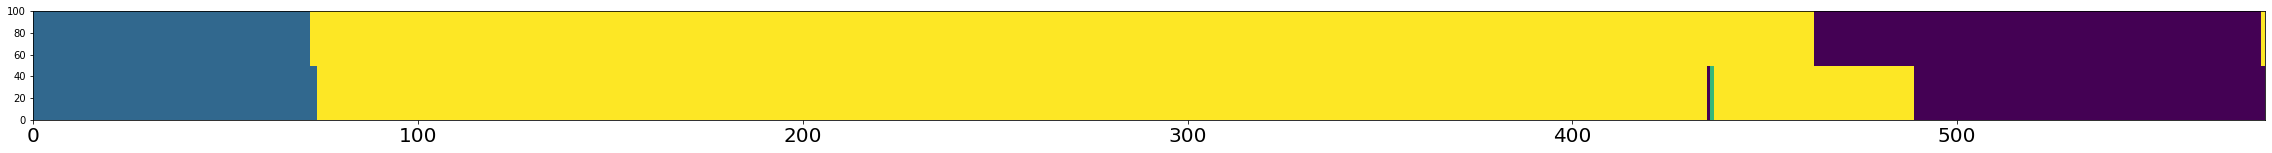

A,P,R:  0.946551724137931 0.9700598802395209 0.8617021276595744
Num frames:  (167, 5)
Accuracy:  0.946551724137931
Person:  96
Transitions:  [0, 3, 1, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


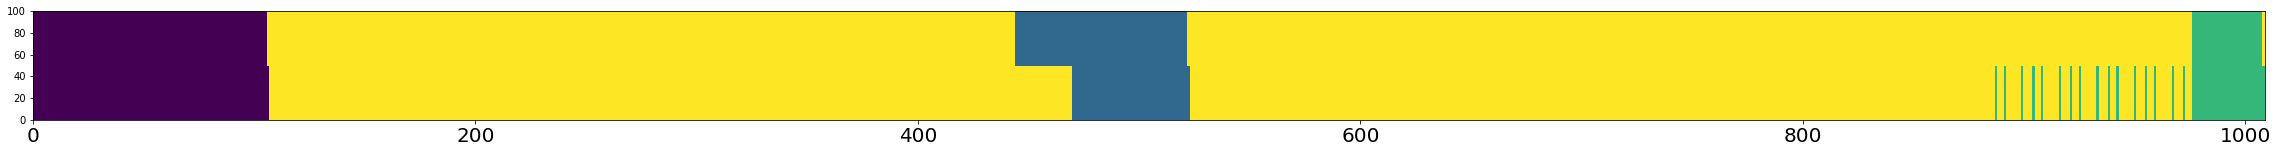

A,P,R:  0.9554013875123885 0.9090909090909091 0.8796296296296297
Num frames:  (209, 19)
Accuracy:  0.9554013875123885
Person:  97
Transitions:  [0, 3, 1, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  3


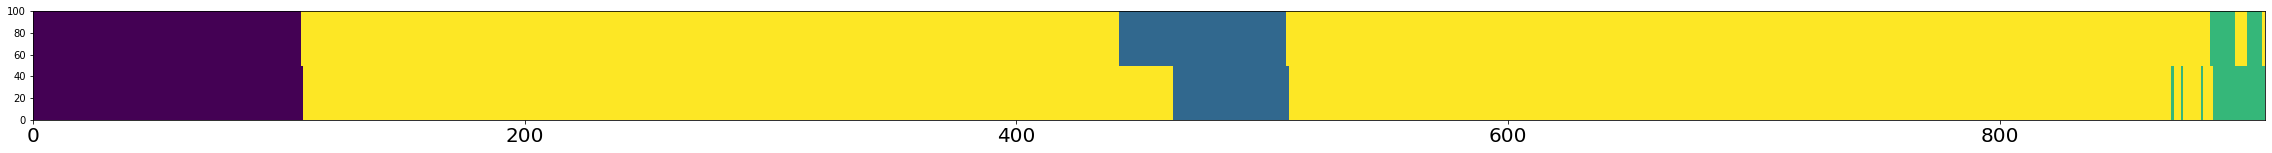

A,P,R:  0.9625550660792952 0.9392265193370166 0.8808290155440415
Num frames:  (181, 11)
Accuracy:  0.9625550660792952
Person:  98
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


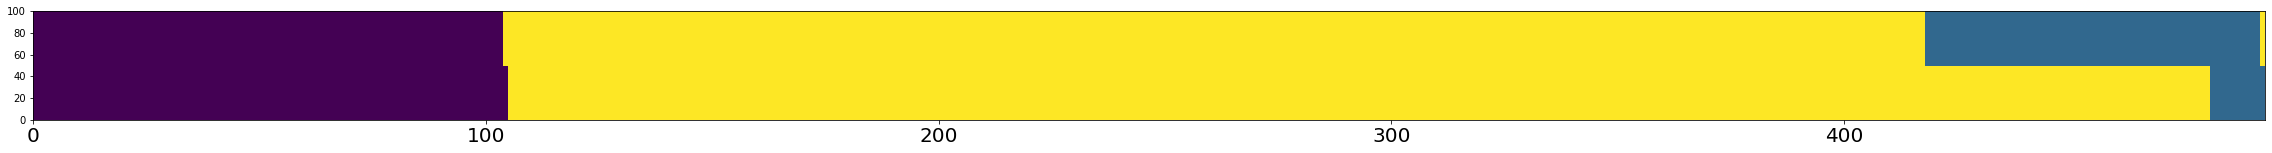

A,P,R:  0.8681541582150102 0.9829059829059829 0.6460674157303371
Num frames:  (117, 2)
Accuracy:  0.8681541582150102
Person:  99
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


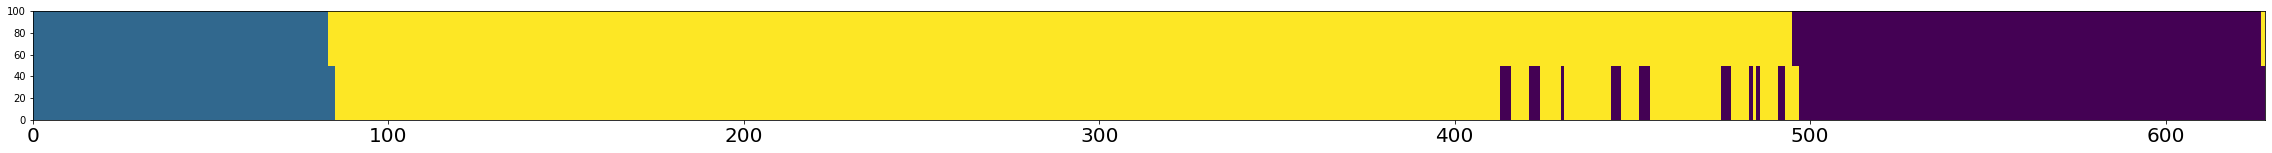

A,P,R:  0.9601910828025477 0.902542372881356 0.9906976744186047
Num frames:  (236, 23)
Accuracy:  0.9601910828025477
Person:  100
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


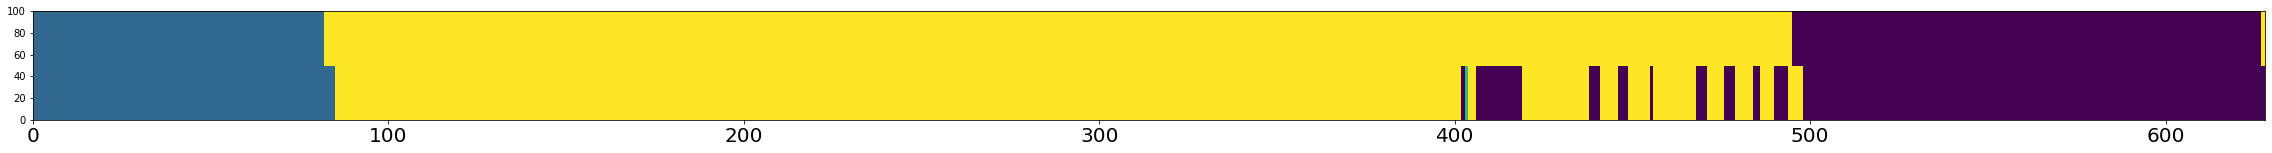

A,P,R:  0.9347133757961783 0.8473895582329317 0.985981308411215
Num frames:  (249, 38)
Accuracy:  0.9347133757961783
Person:  101
Transitions:  [1, 3, 0, 3, 0, 3]
GT transitions:  2
Transitions captured:  2


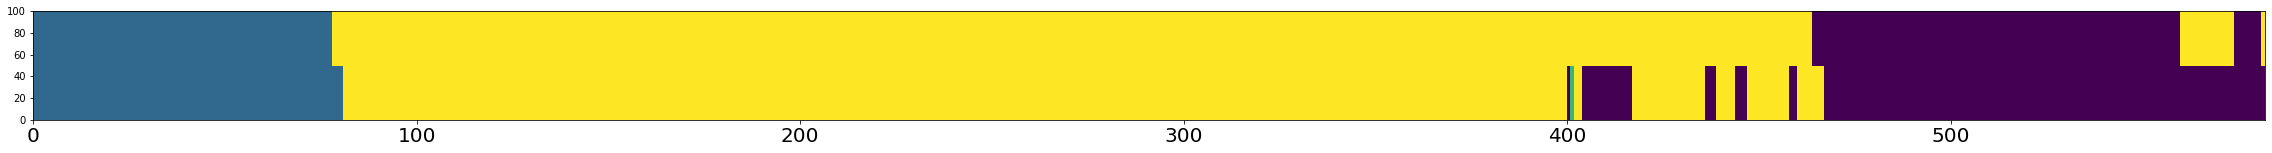

A,P,R:  0.9243986254295533 0.8127853881278538 0.9834254143646409
Num frames:  (219, 41)
Accuracy:  0.9243986254295533
Person:  102
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


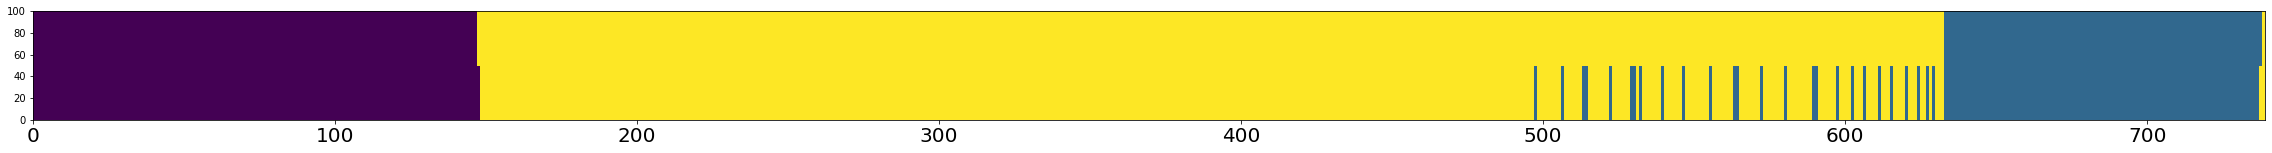

A,P,R:  0.9621109607577808 0.9028776978417267 0.996031746031746
Num frames:  (278, 27)
Accuracy:  0.9621109607577808
Person:  103
Transitions:  [1, 3, 1, 3, 0, 3]
GT transitions:  2
Transitions captured:  2


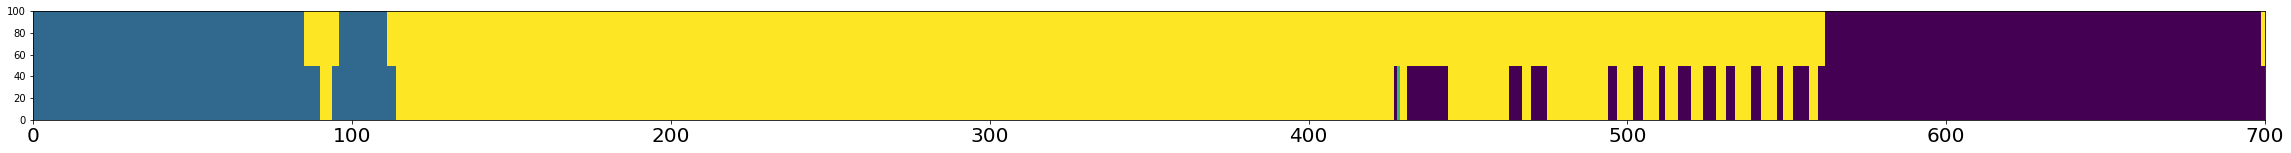

A,P,R:  0.9057142857142857 0.7821782178217822 1.0
Num frames:  (303, 66)
Accuracy:  0.9057142857142857
Person:  104
Transitions:  [1, 3, 1, 3, 0, 3]
GT transitions:  2
Transitions captured:  1


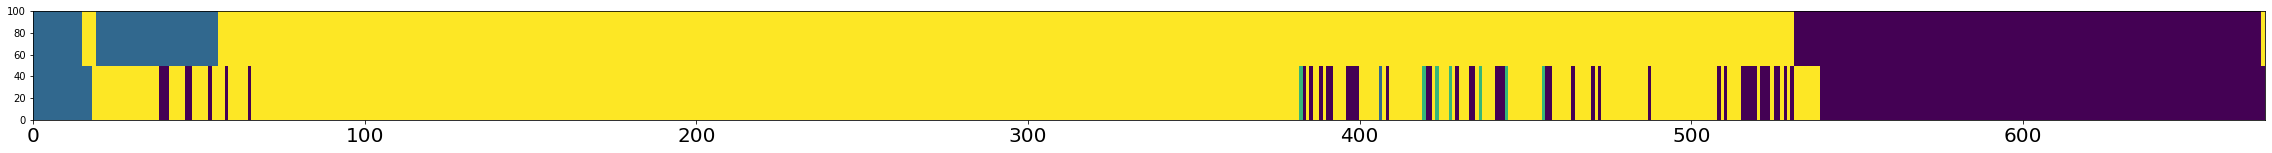

A,P,R:  0.8558692421991084 0.7184466019417476 0.7668393782383419
Num frames:  (206, 52)
Accuracy:  0.8558692421991084
Person:  105
Transitions:  [1, 3, 1, 3, 0, 3]
GT transitions:  2
Transitions captured:  2


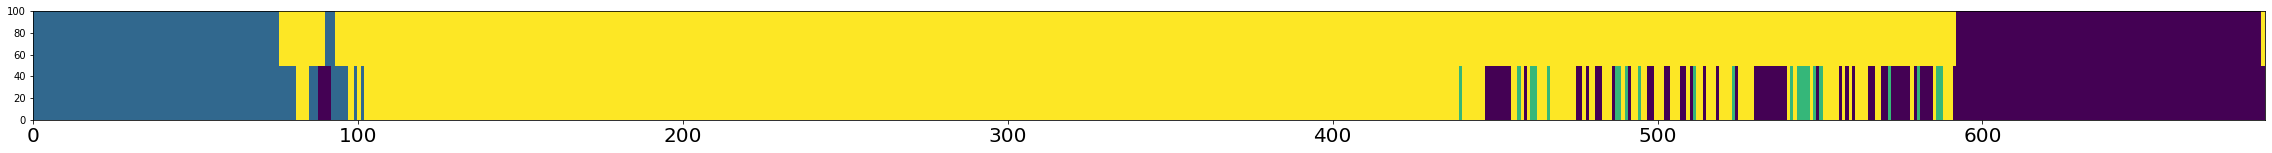

A,P,R:  0.858806404657933 0.6380597014925373 0.9884393063583815
Num frames:  (268, 95)
Accuracy:  0.858806404657933
Person:  106
Transitions:  [1, 3, 0, 3, 0, 3]
GT transitions:  2
Transitions captured:  1


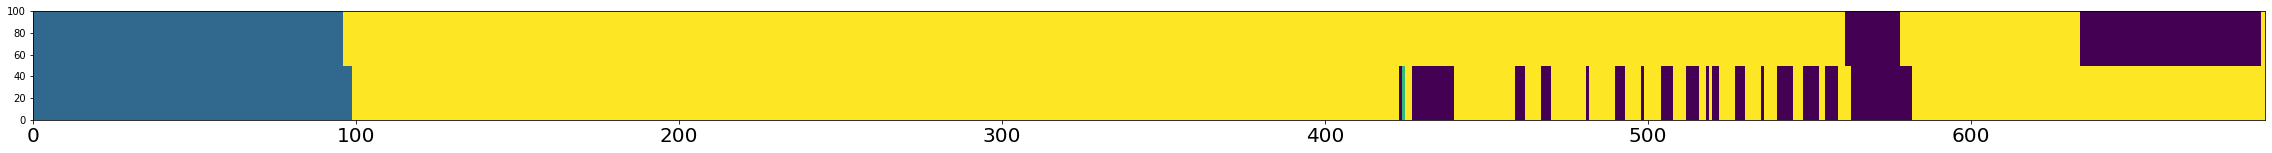

A,P,R:  0.8263386396526773 0.6416184971098265 0.6568047337278107
Num frames:  (173, 62)
Accuracy:  0.8263386396526773
Person:  107
Transitions:  [1, 3, 0, 3]
GT transitions:  1
Transitions captured:  1


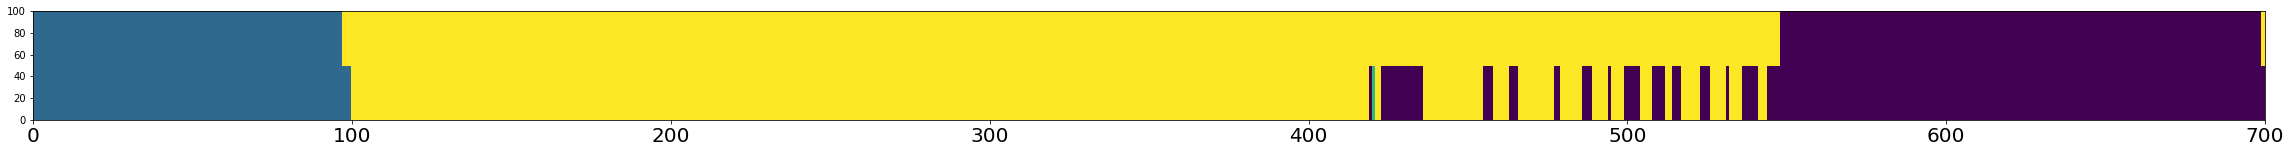

A,P,R:  0.92 0.8157894736842105 1.0
Num frames:  (304, 56)
Accuracy:  0.92
Person:  108
Transitions:  [0, 3, 1, 3]
GT transitions:  1
Transitions captured:  1


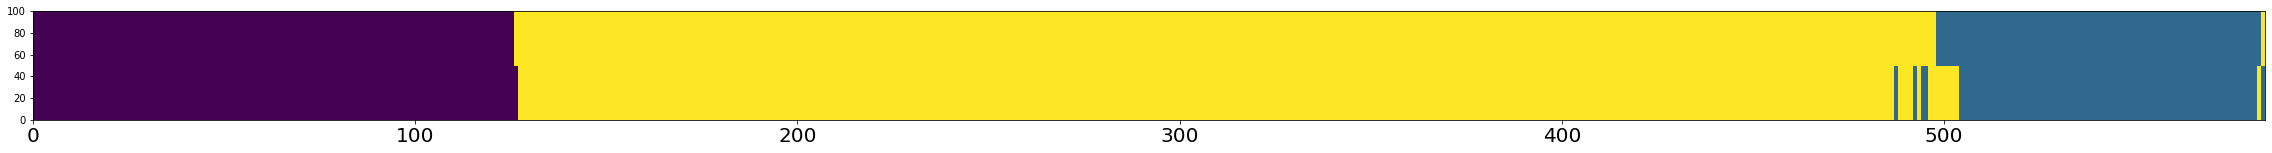

A,P,R:  0.9777397260273972 0.9714285714285714 0.966824644549763
Num frames:  (210, 6)
Accuracy:  0.9777397260273972
Person:  109
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



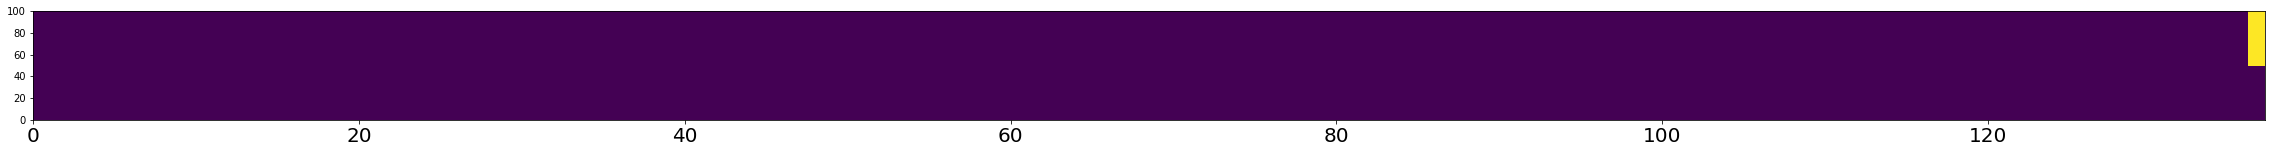

A,P,R:  0.9927007299270073 0.9927007299270073 1.0
Num frames:  (137, 1)
Accuracy:  0.9927007299270073
Person:  110
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



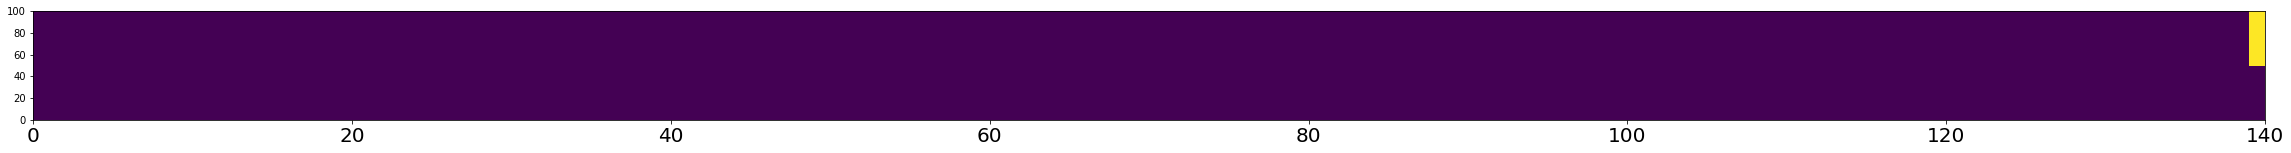

A,P,R:  0.9928571428571429 0.9928571428571429 1.0
Num frames:  (140, 1)
Accuracy:  0.9928571428571429
Person:  111
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



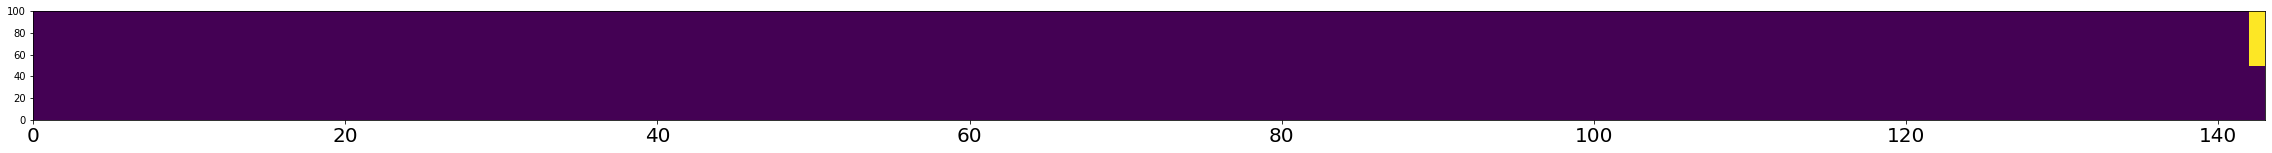

A,P,R:  0.993006993006993 0.993006993006993 1.0
Num frames:  (143, 1)
Accuracy:  0.993006993006993
Person:  112
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



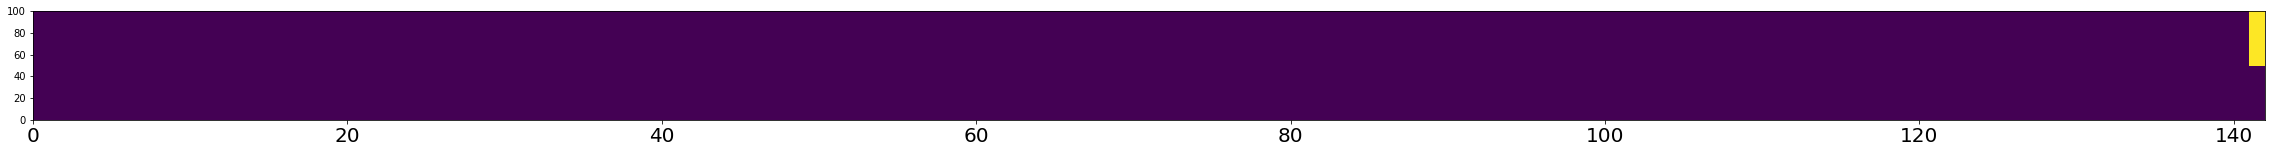

A,P,R:  0.9929577464788732 0.9929577464788732 1.0
Num frames:  (142, 1)
Accuracy:  0.9929577464788732
Person:  113
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



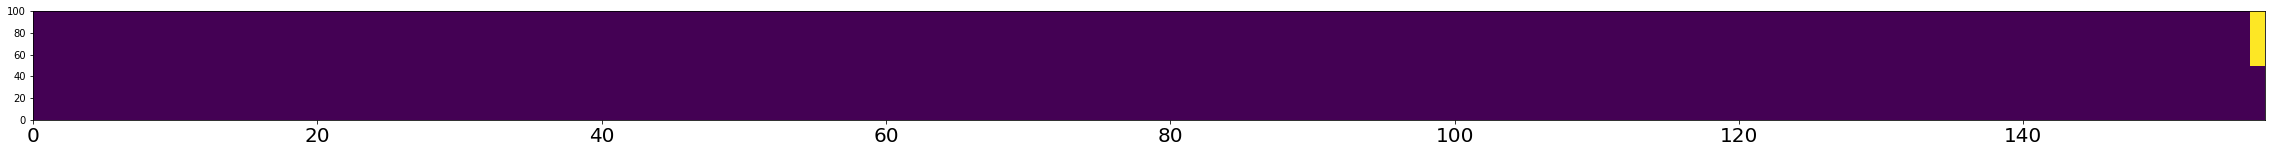

A,P,R:  0.9936305732484076 0.9936305732484076 1.0
Num frames:  (157, 1)
Accuracy:  0.9936305732484076
Person:  114
Transitions:  [0, 3]
GT transitions:  0
Transitions captured:  0



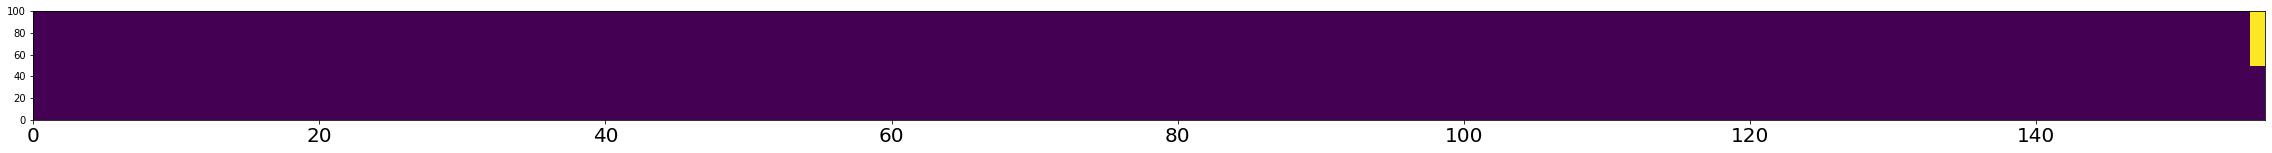

A,P,R:  0.9935897435897436 0.9935897435897436 1.0
Num frames:  (156, 1)
Accuracy:  0.9935897435897436
Person:  115
Transitions:  [1, 3]
GT transitions:  0
Transitions captured:  0



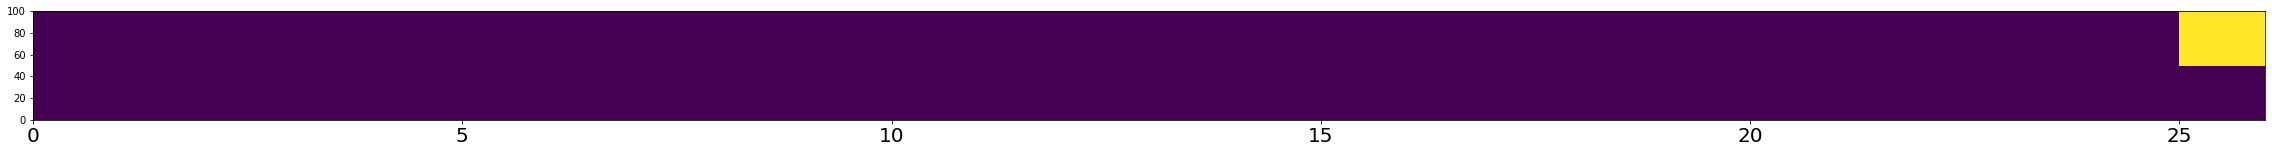

A,P,R:  0.9615384615384616 0.9615384615384616 1.0
Num frames:  (26, 1)
Accuracy:  0.9615384615384616
Person:  116
Transitions:  [1, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


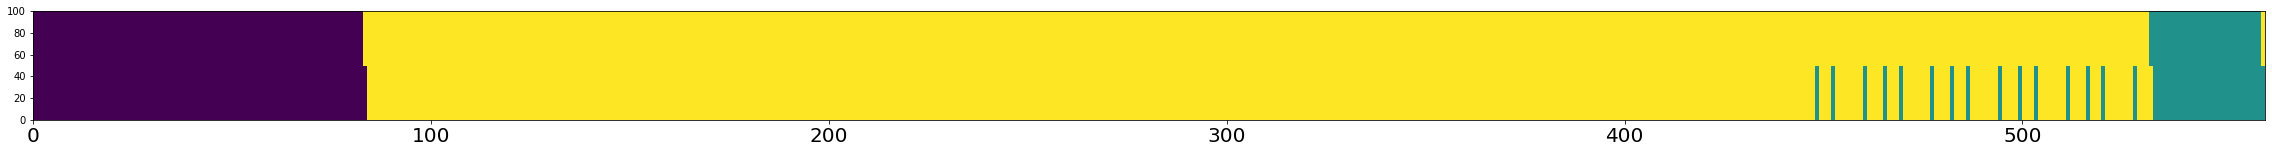

A,P,R:  0.9679144385026738 0.8661417322834646 0.990990990990991
Num frames:  (127, 17)
Accuracy:  0.9679144385026738
Person:  117
Transitions:  [1, 3]
GT transitions:  0
Transitions captured:  0



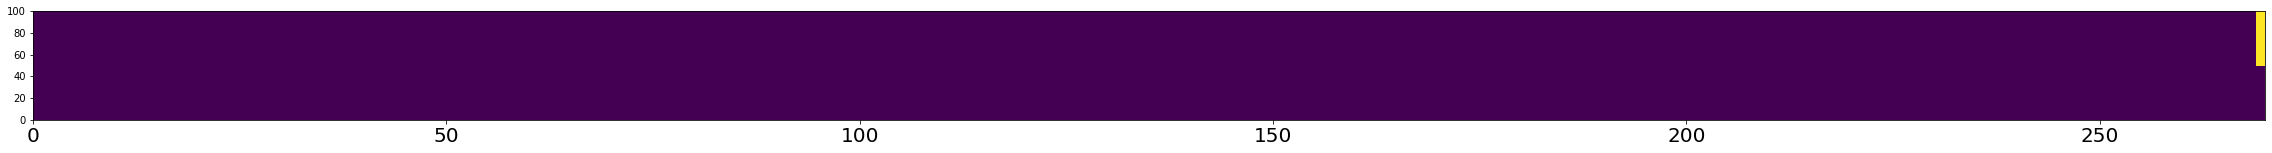

A,P,R:  0.9962962962962963 0.9962962962962963 1.0
Num frames:  (270, 1)
Accuracy:  0.9962962962962963
Person:  118
Transitions:  [1, 3]
GT transitions:  0
Transitions captured:  0



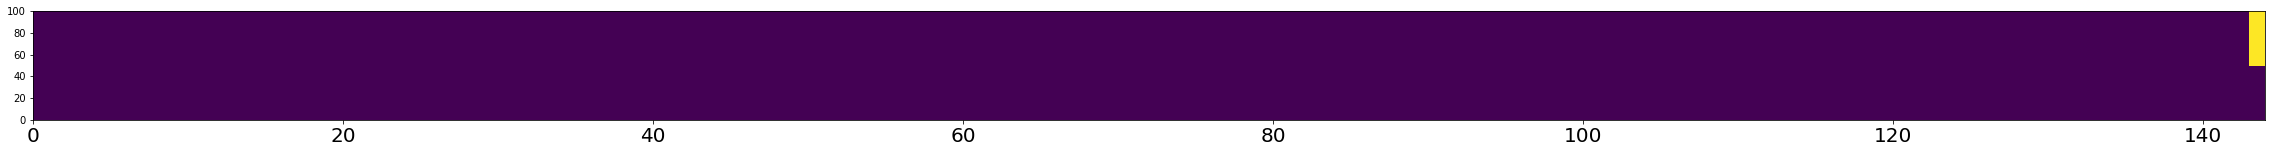

A,P,R:  0.9930555555555556 0.9930555555555556 1.0
Num frames:  (144, 1)
Accuracy:  0.9930555555555556
Person:  119
Transitions:  [1, 3]
GT transitions:  0
Transitions captured:  0



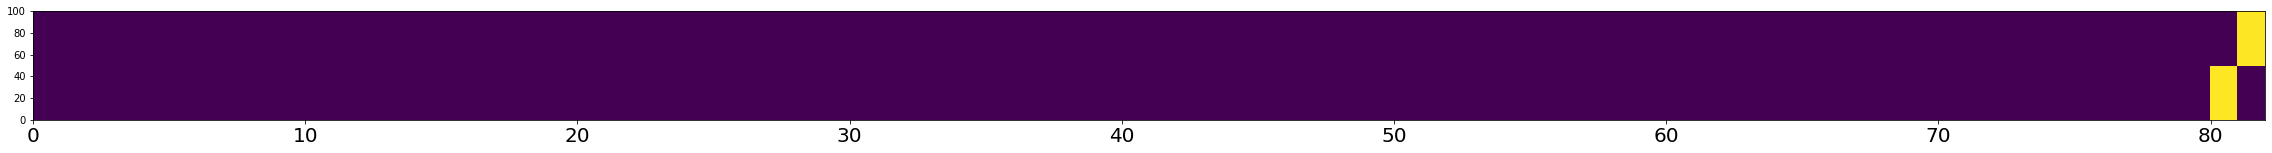

A,P,R:  0.975609756097561 0.9876543209876543 0.9876543209876543
Num frames:  (81, 1)
Accuracy:  0.975609756097561
Person:  120
Transitions:  [1, 3]
GT transitions:  0
Transitions captured:  0



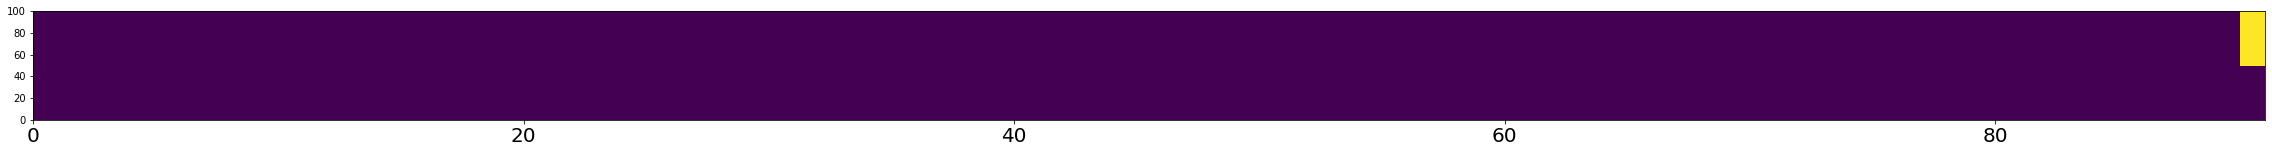

A,P,R:  0.989010989010989 0.989010989010989 1.0
Num frames:  (91, 1)
Accuracy:  0.989010989010989
Person:  121
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



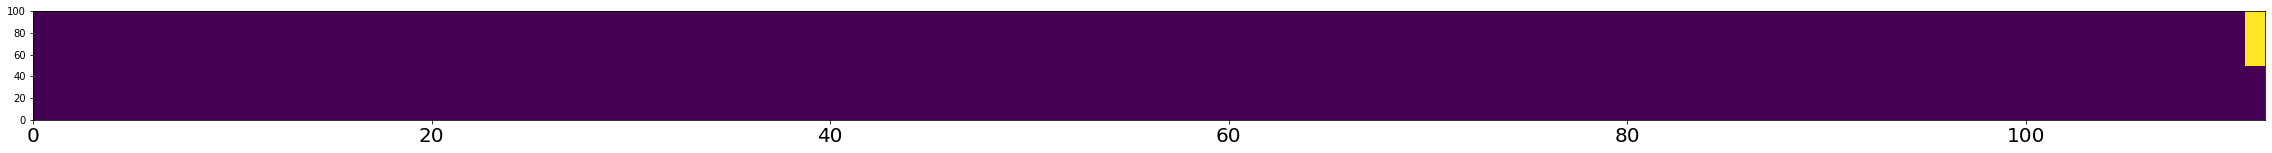

A,P,R:  0.9910714285714286 0.9910714285714286 1.0
Num frames:  (112, 1)
Accuracy:  0.9910714285714286
Person:  122
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



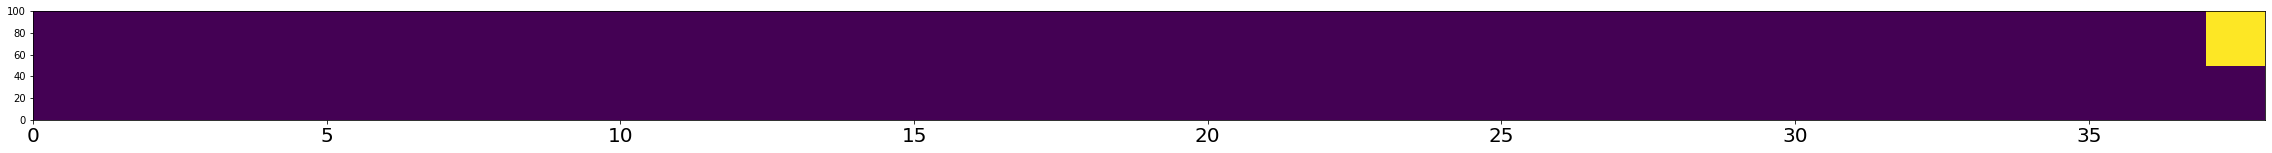

A,P,R:  0.9736842105263158 0.9736842105263158 1.0
Num frames:  (38, 1)
Accuracy:  0.9736842105263158
Person:  123
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



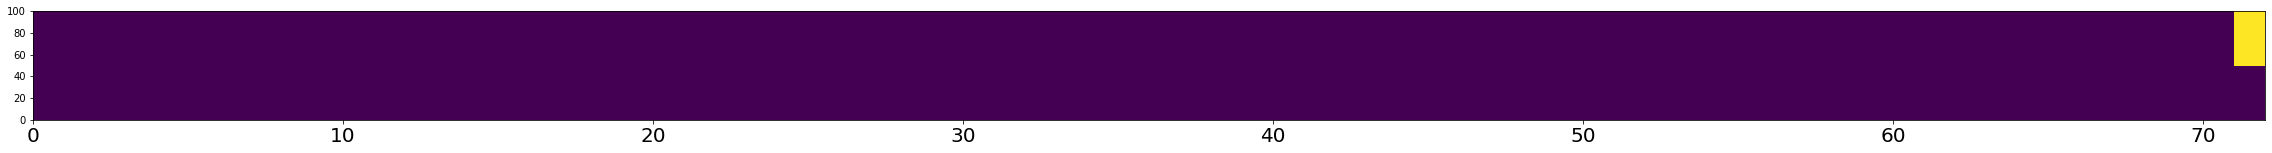

A,P,R:  0.9861111111111112 0.9861111111111112 1.0
Num frames:  (72, 1)
Accuracy:  0.9861111111111112
Person:  124
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



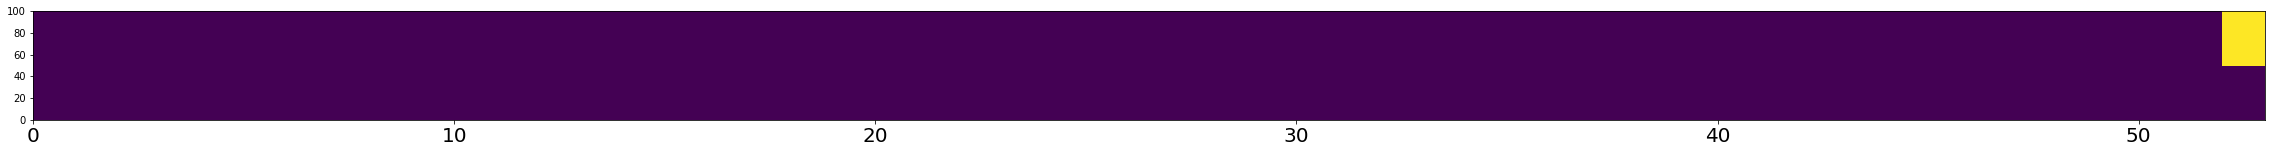

A,P,R:  0.9811320754716981 0.9811320754716981 1.0
Num frames:  (53, 1)
Accuracy:  0.9811320754716981
Person:  125
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



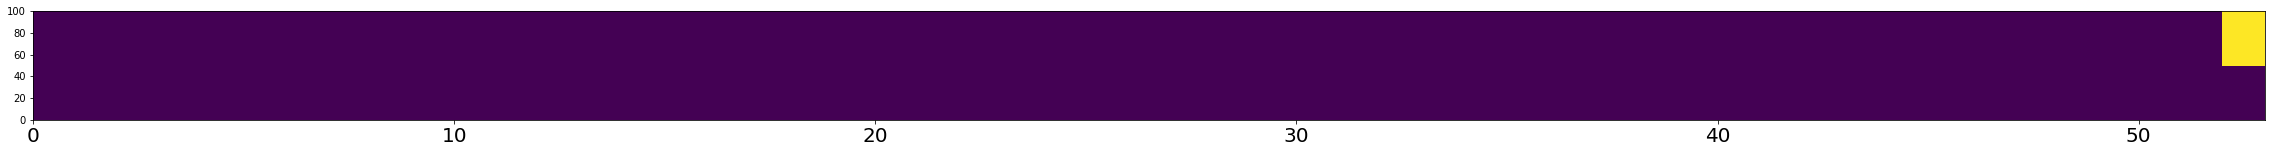

A,P,R:  0.9811320754716981 0.9811320754716981 1.0
Num frames:  (53, 1)
Accuracy:  0.9811320754716981
Person:  126
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



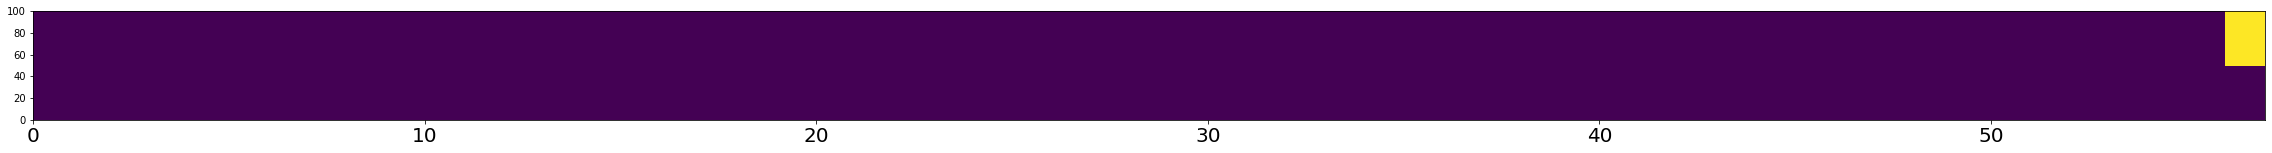

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  127
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



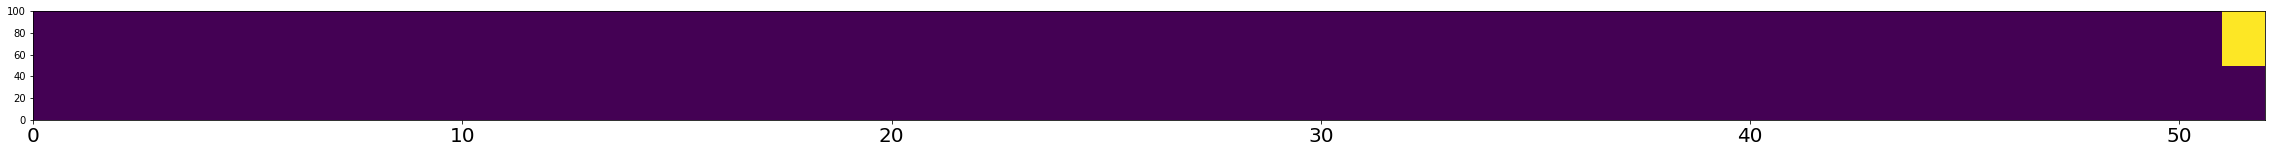

A,P,R:  0.9807692307692307 0.9807692307692307 1.0
Num frames:  (52, 1)
Accuracy:  0.9807692307692307
Person:  128
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



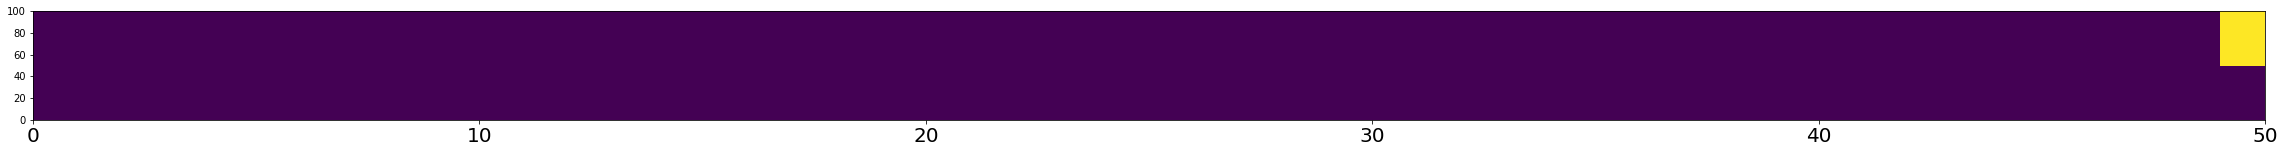

A,P,R:  0.98 0.98 1.0
Num frames:  (50, 1)
Accuracy:  0.98
Person:  129
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



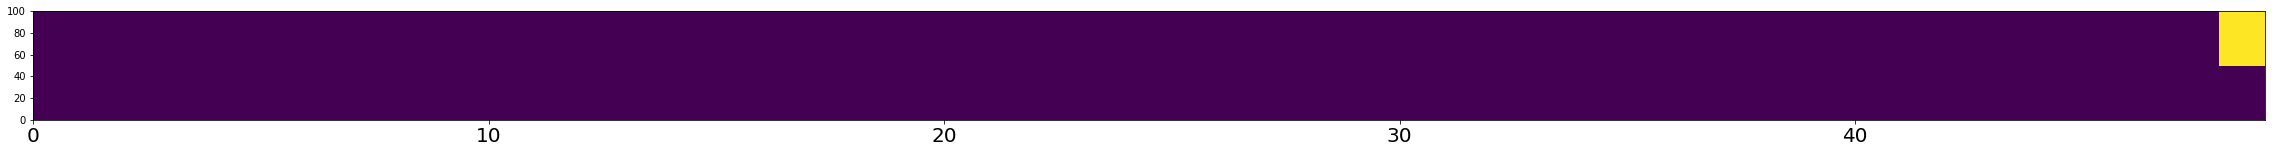

A,P,R:  0.9795918367346939 0.9795918367346939 1.0
Num frames:  (49, 1)
Accuracy:  0.9795918367346939
Person:  130
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



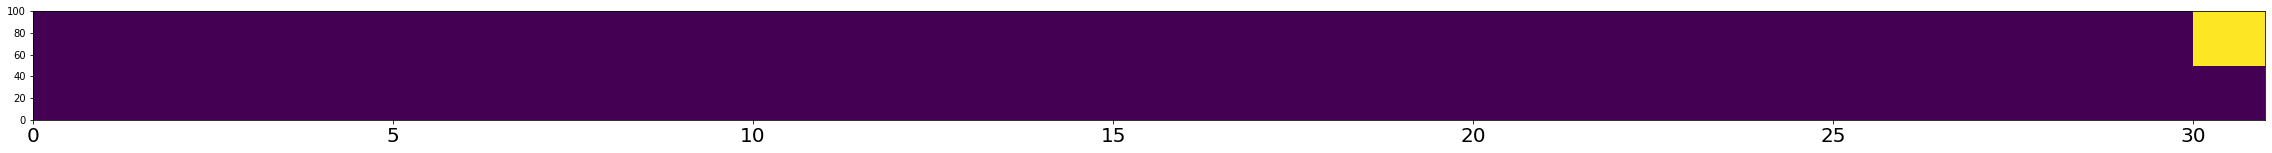

A,P,R:  0.967741935483871 0.967741935483871 1.0
Num frames:  (31, 1)
Accuracy:  0.967741935483871
Person:  131
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


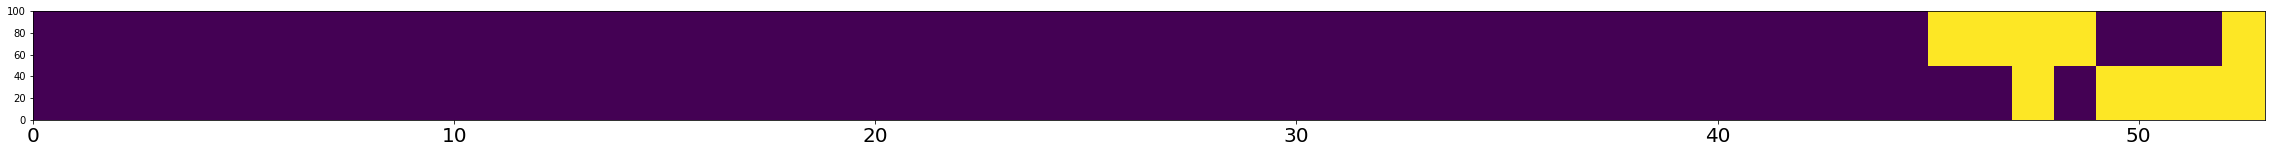

A,P,R:  0.8867924528301887 0.9375 0.9375
Num frames:  (48, 3)
Accuracy:  0.8867924528301887
Person:  132
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  7
Transitions captured:  3


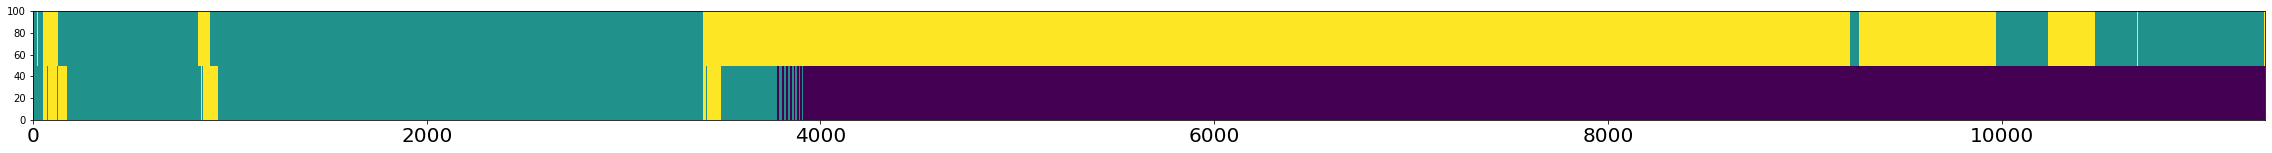

A,P,R:  0.2971161478084487 0.2873667088378818 0.7181571815718157
Num frames:  (11066, 6722)
Accuracy:  0.2971161478084487
Person:  133
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



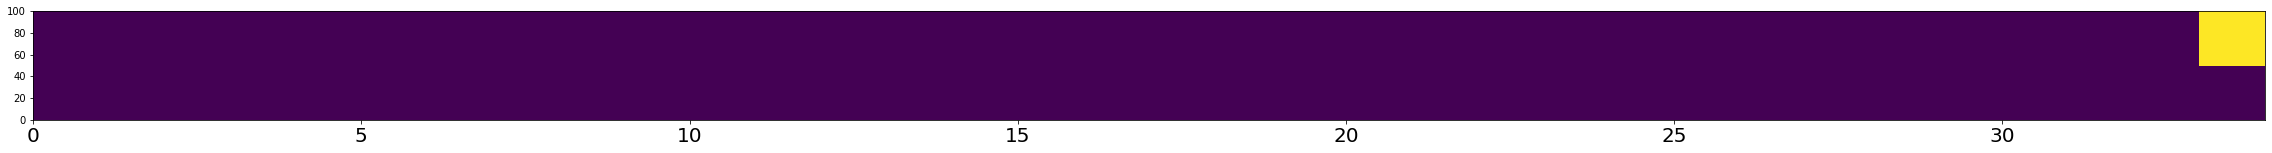

A,P,R:  0.9705882352941176 0.9705882352941176 1.0
Num frames:  (34, 1)
Accuracy:  0.9705882352941176
Person:  134
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


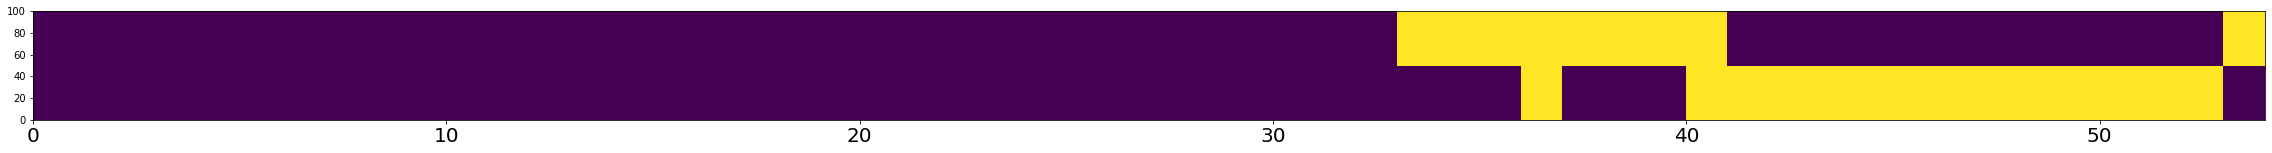

A,P,R:  0.6481481481481481 0.825 0.7333333333333333
Num frames:  (40, 7)
Accuracy:  0.6481481481481481
Person:  135
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


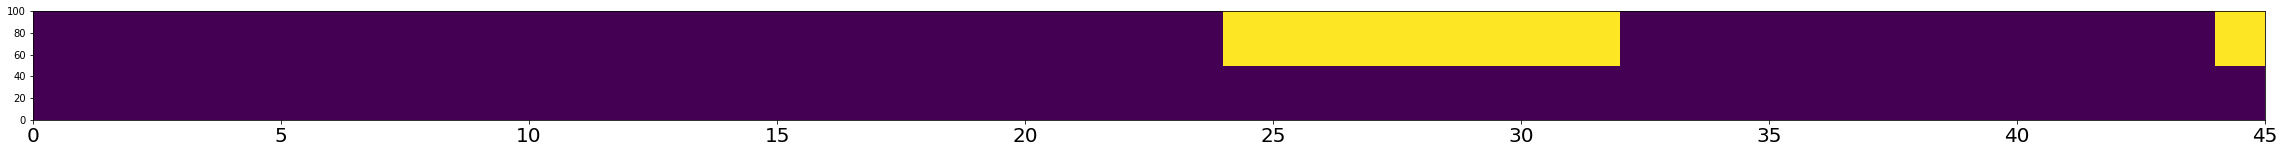

A,P,R:  0.8 0.8 1.0
Num frames:  (45, 9)
Accuracy:  0.8
Person:  136
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



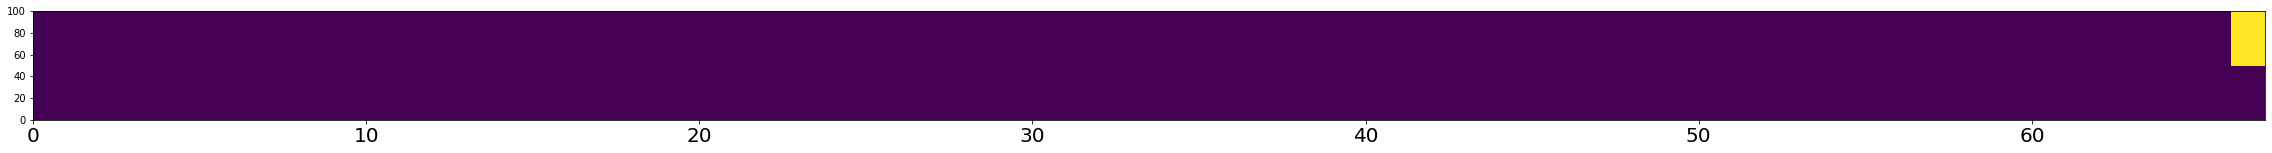

A,P,R:  0.9850746268656716 0.9850746268656716 1.0
Num frames:  (67, 1)
Accuracy:  0.9850746268656716
Person:  137
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



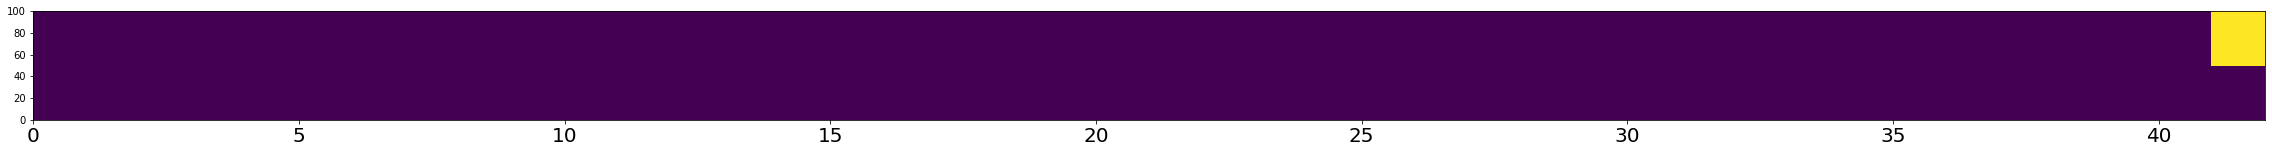

A,P,R:  0.9761904761904762 0.9761904761904762 1.0
Num frames:  (42, 1)
Accuracy:  0.9761904761904762
Person:  138
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



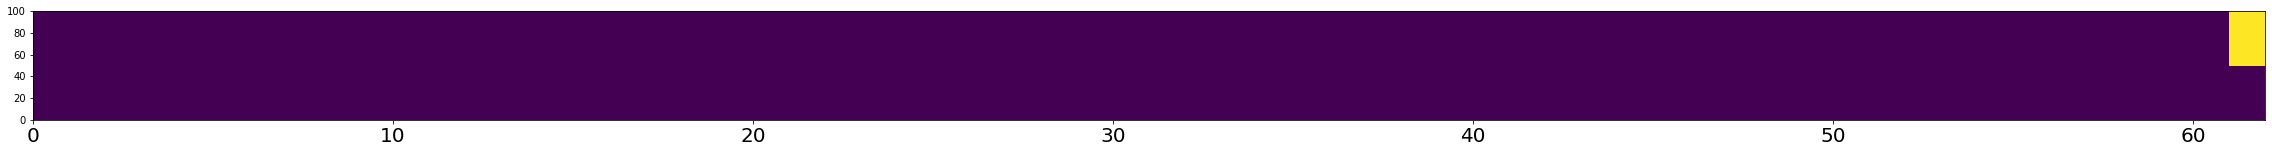

A,P,R:  0.9838709677419355 0.9838709677419355 1.0
Num frames:  (62, 1)
Accuracy:  0.9838709677419355
Person:  139
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



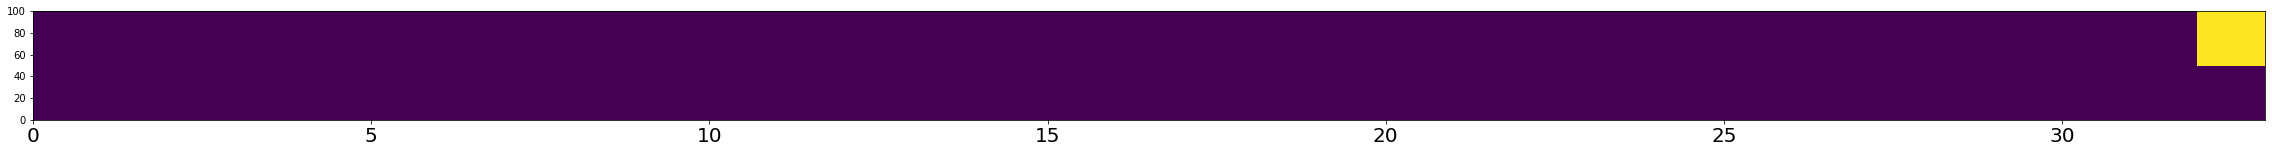

A,P,R:  0.9696969696969697 0.9696969696969697 1.0
Num frames:  (33, 1)
Accuracy:  0.9696969696969697
Person:  140
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



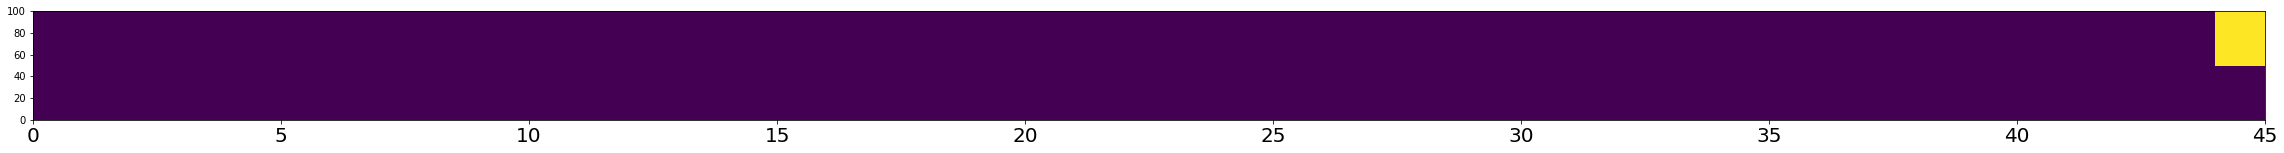

A,P,R:  0.9777777777777777 0.9777777777777777 1.0
Num frames:  (45, 1)
Accuracy:  0.9777777777777777
Person:  141
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



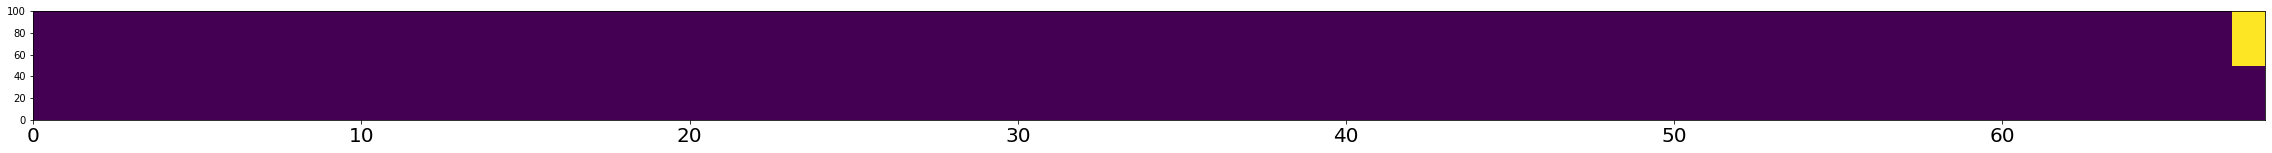

A,P,R:  0.9852941176470589 0.9852941176470589 1.0
Num frames:  (68, 1)
Accuracy:  0.9852941176470589
Person:  142
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  8
Transitions captured:  6


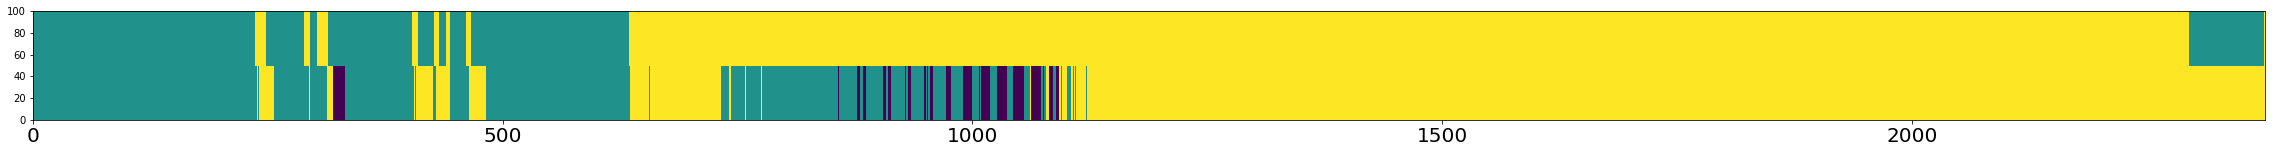

A,P,R:  0.7756734006734006 0.5636561479869423 0.7824773413897281
Num frames:  (919, 389)
Accuracy:  0.7756734006734006
Person:  143
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



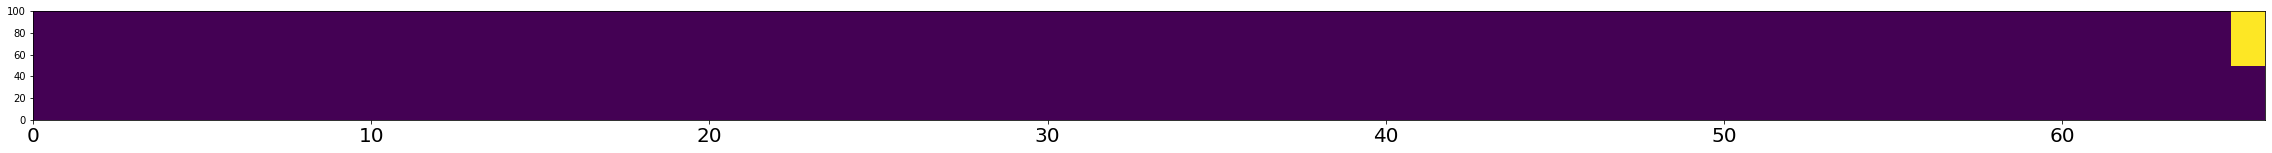

A,P,R:  0.9848484848484849 0.9848484848484849 1.0
Num frames:  (66, 1)
Accuracy:  0.9848484848484849
Person:  144
Transitions:  [2, 3, 2, 3, 2, 3]
GT transitions:  2
Transitions captured:  1


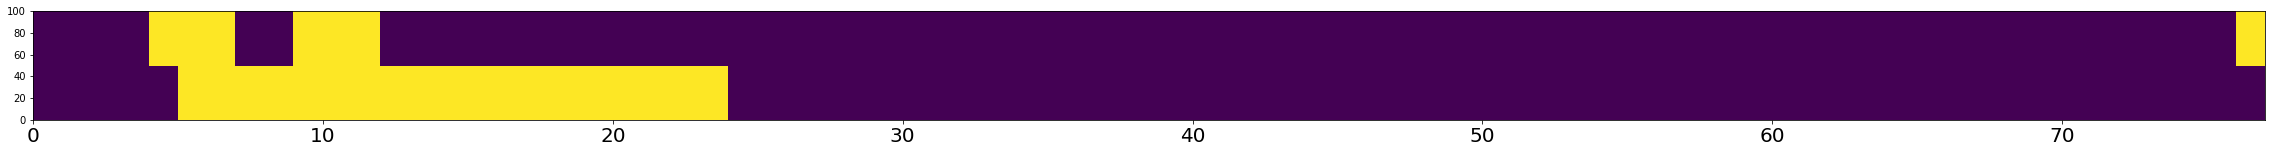

A,P,R:  0.7922077922077922 0.9655172413793104 0.8
Num frames:  (58, 2)
Accuracy:  0.7922077922077922
Person:  145
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  4
Transitions captured:  3


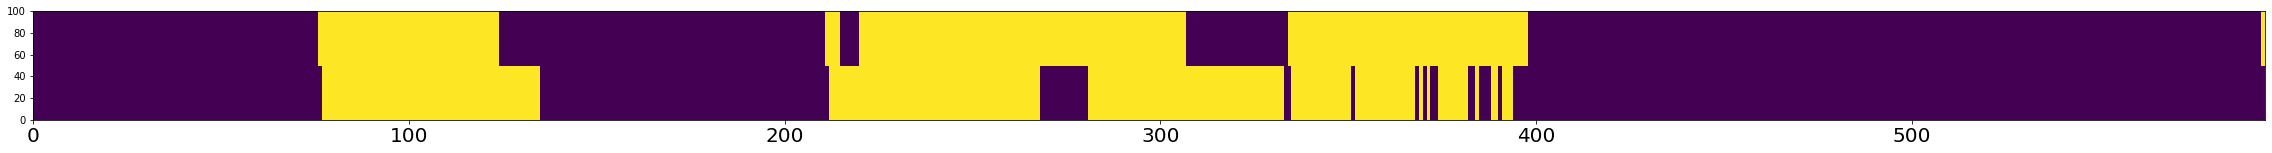

A,P,R:  0.8754208754208754 0.9157894736842105 0.8923076923076924
Num frames:  (380, 32)
Accuracy:  0.8754208754208754
Person:  146
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



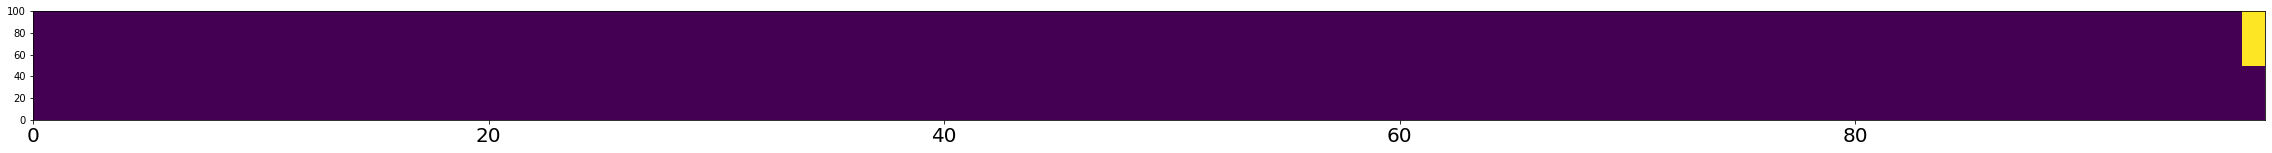

A,P,R:  0.9897959183673469 0.9897959183673469 1.0
Num frames:  (98, 1)
Accuracy:  0.9897959183673469
Person:  147
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



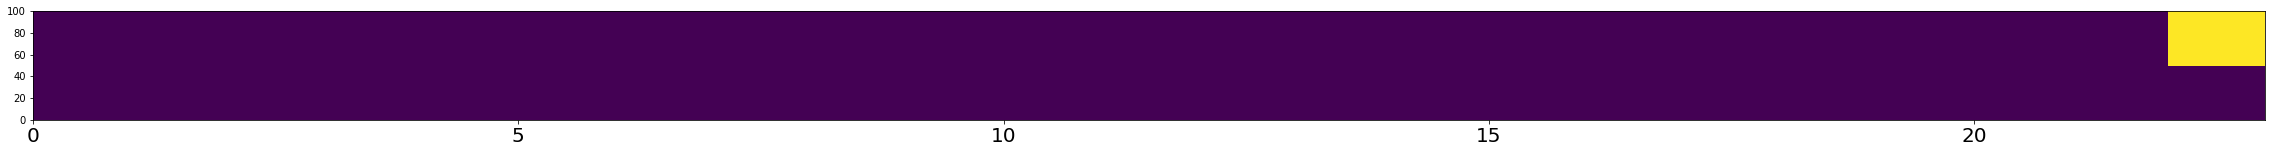

A,P,R:  0.9565217391304348 0.9565217391304348 1.0
Num frames:  (23, 1)
Accuracy:  0.9565217391304348
Person:  148
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



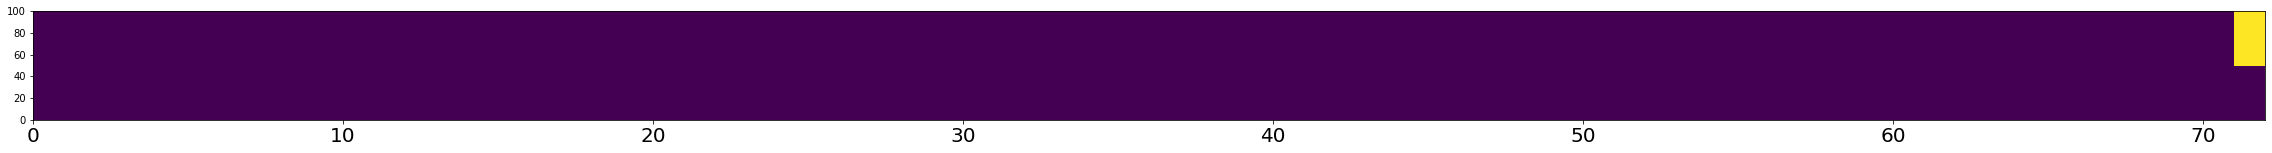

A,P,R:  0.9861111111111112 0.9861111111111112 1.0
Num frames:  (72, 1)
Accuracy:  0.9861111111111112
Person:  149
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


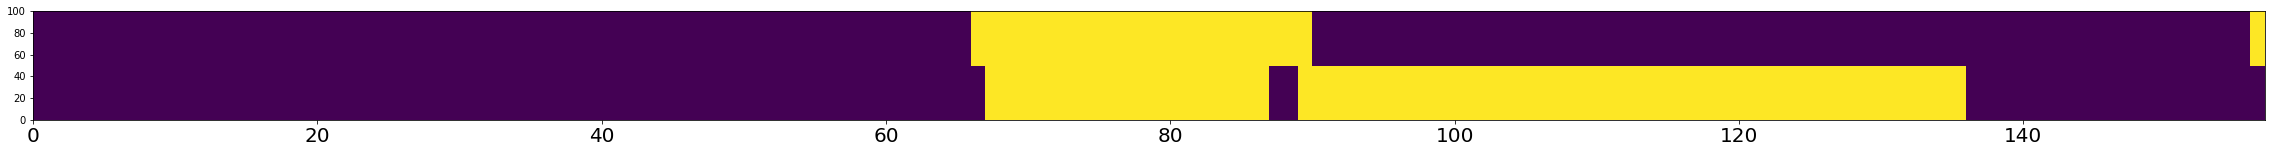

A,P,R:  0.6815286624203821 0.9555555555555556 0.6515151515151515
Num frames:  (90, 4)
Accuracy:  0.6815286624203821
Person:  150
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


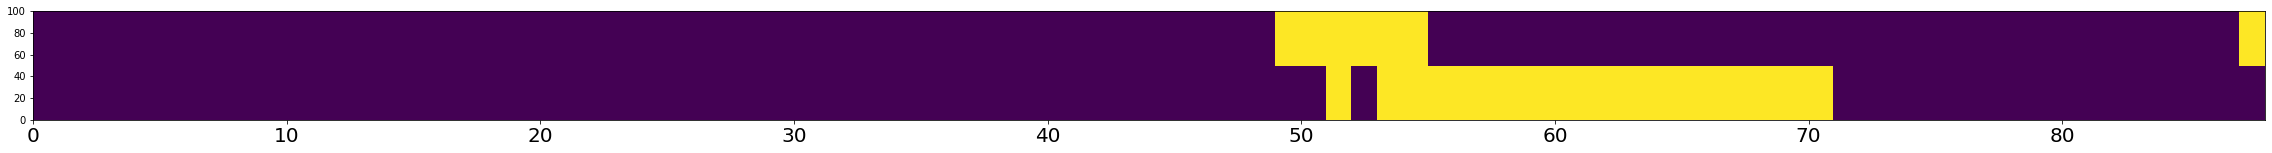

A,P,R:  0.7727272727272727 0.9420289855072463 0.8024691358024691
Num frames:  (69, 4)
Accuracy:  0.7727272727272727
Person:  151
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



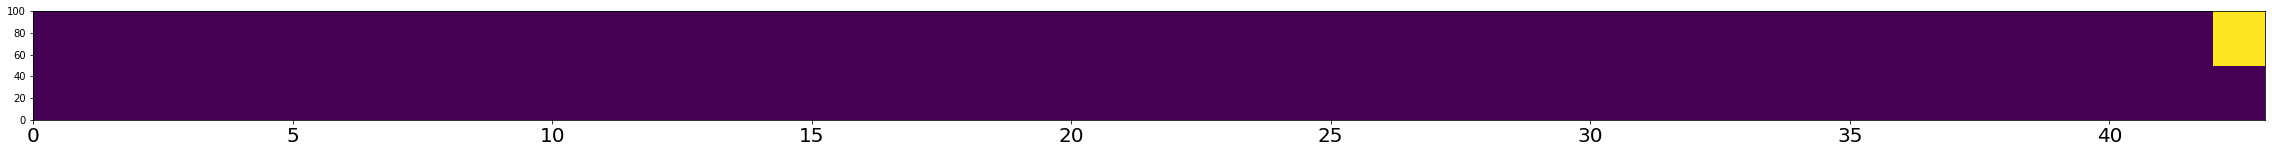

A,P,R:  0.9767441860465116 0.9767441860465116 1.0
Num frames:  (43, 1)
Accuracy:  0.9767441860465116
Person:  152
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


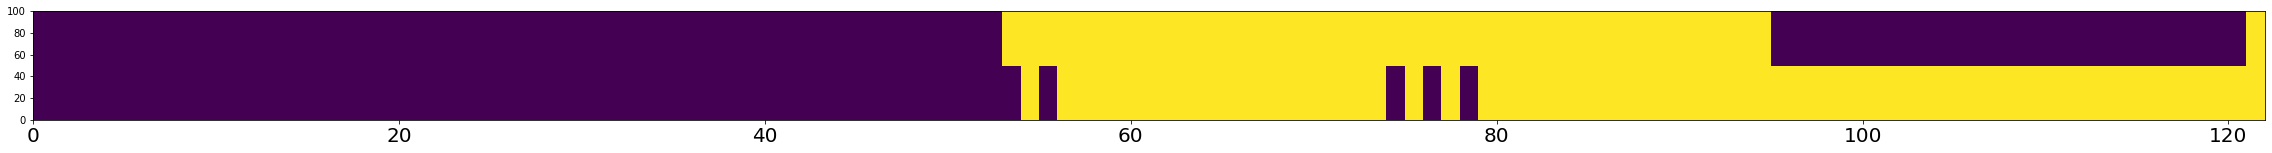

A,P,R:  0.7459016393442623 0.9137931034482759 0.6708860759493671
Num frames:  (58, 5)
Accuracy:  0.7459016393442623
Person:  153
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  1


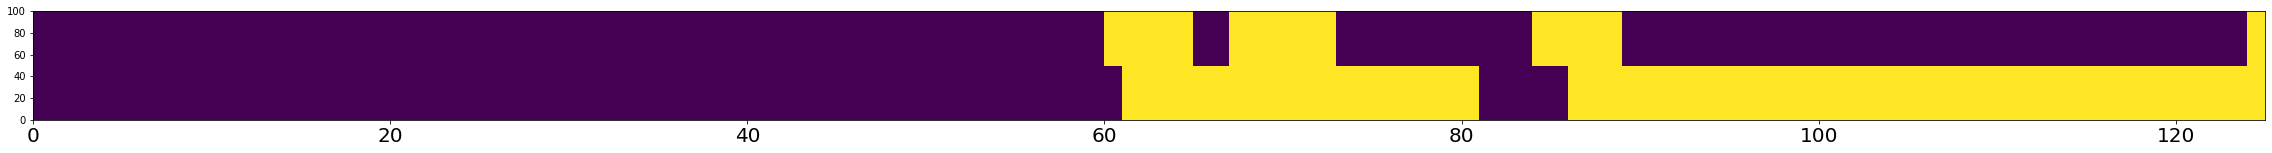

A,P,R:  0.616 0.9545454545454546 0.5833333333333334
Num frames:  (66, 3)
Accuracy:  0.616
Person:  154
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



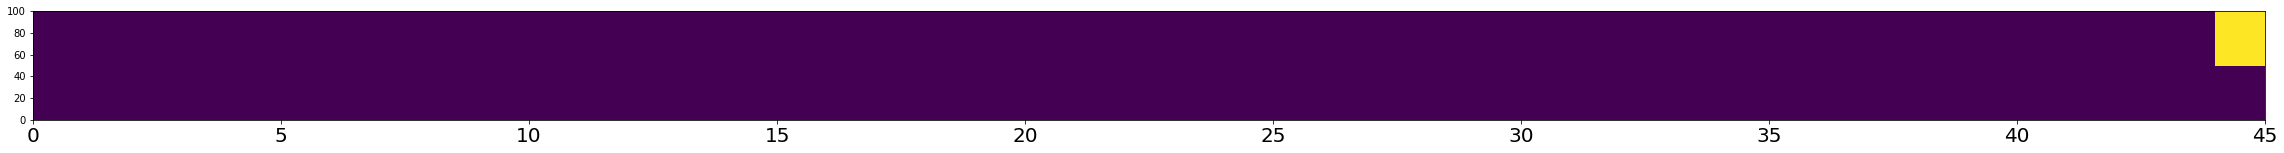

A,P,R:  0.9777777777777777 0.9777777777777777 1.0
Num frames:  (45, 1)
Accuracy:  0.9777777777777777
Person:  155
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


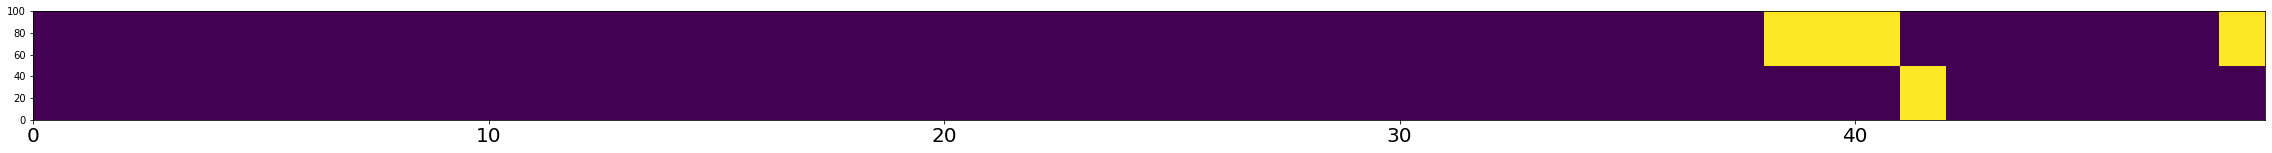

A,P,R:  0.8979591836734694 0.9166666666666666 0.9777777777777777
Num frames:  (48, 4)
Accuracy:  0.8979591836734694
Person:  156
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


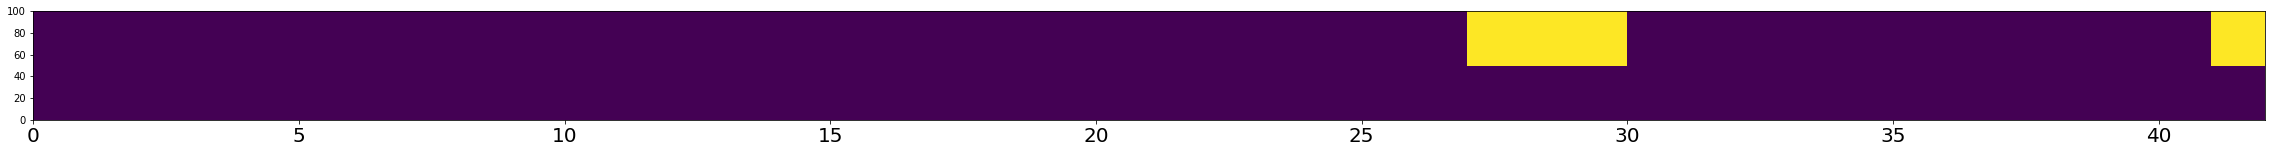

A,P,R:  0.9047619047619048 0.9047619047619048 1.0
Num frames:  (42, 4)
Accuracy:  0.9047619047619048
Person:  157
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



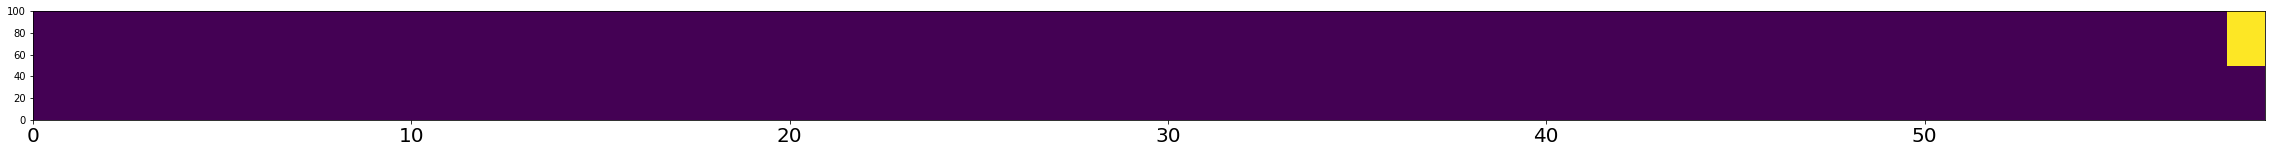

A,P,R:  0.9830508474576272 0.9830508474576272 1.0
Num frames:  (59, 1)
Accuracy:  0.9830508474576272
Person:  158
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



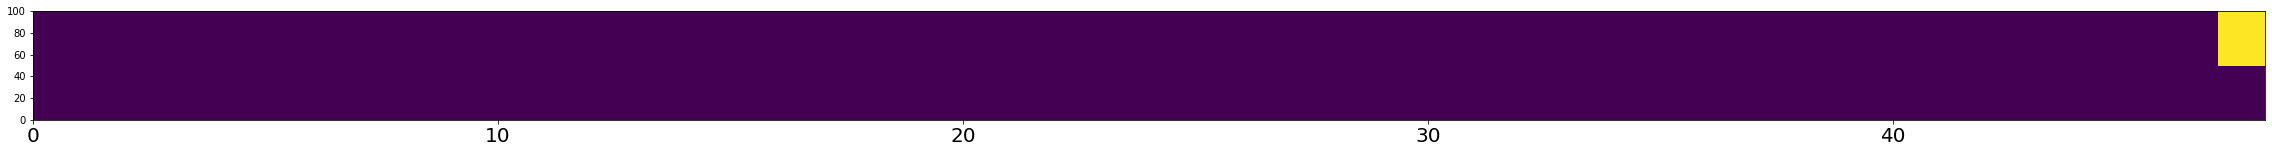

A,P,R:  0.9791666666666666 0.9791666666666666 1.0
Num frames:  (48, 1)
Accuracy:  0.9791666666666666
Person:  159
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



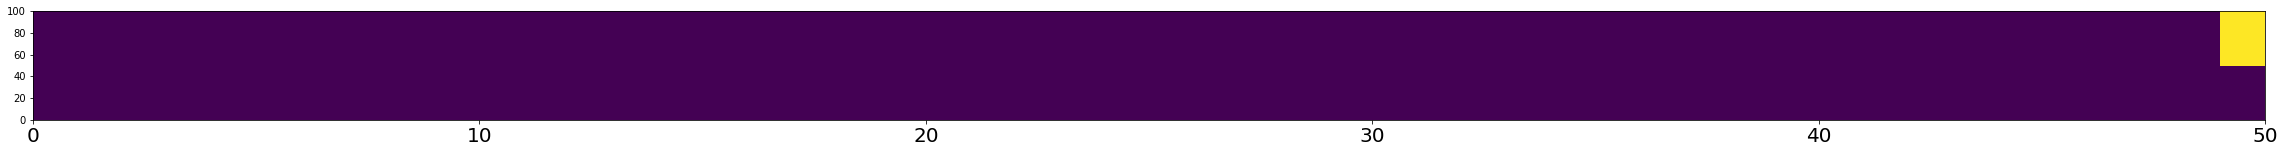

A,P,R:  0.98 0.98 1.0
Num frames:  (50, 1)
Accuracy:  0.98
Person:  160
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



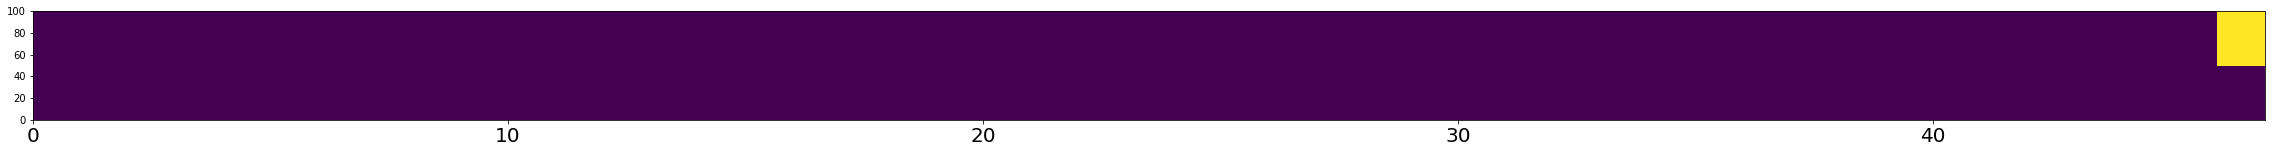

A,P,R:  0.9787234042553191 0.9787234042553191 1.0
Num frames:  (47, 1)
Accuracy:  0.9787234042553191
Person:  161
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



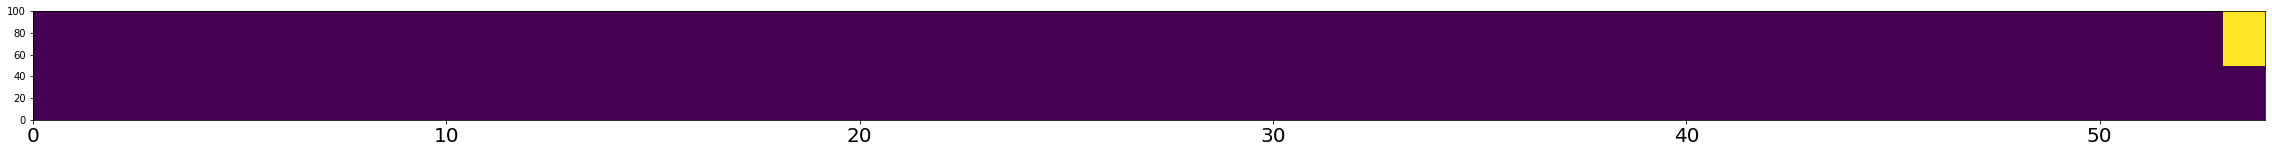

A,P,R:  0.9814814814814815 0.9814814814814815 1.0
Num frames:  (54, 1)
Accuracy:  0.9814814814814815
Person:  162
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



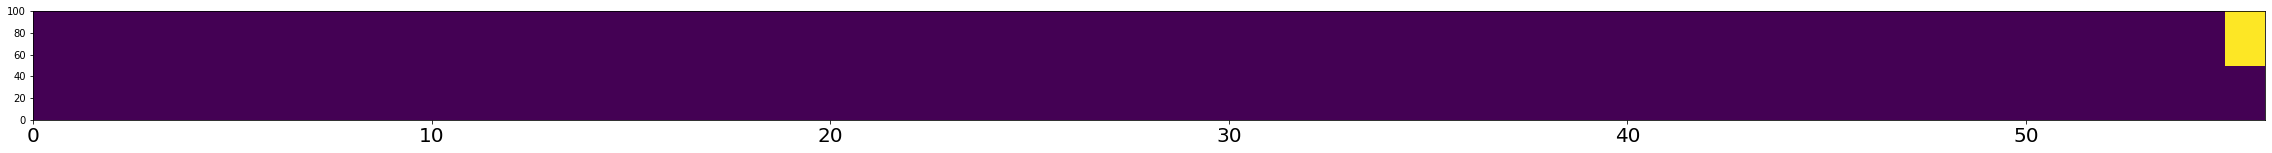

A,P,R:  0.9821428571428571 0.9821428571428571 1.0
Num frames:  (56, 1)
Accuracy:  0.9821428571428571
Person:  163
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



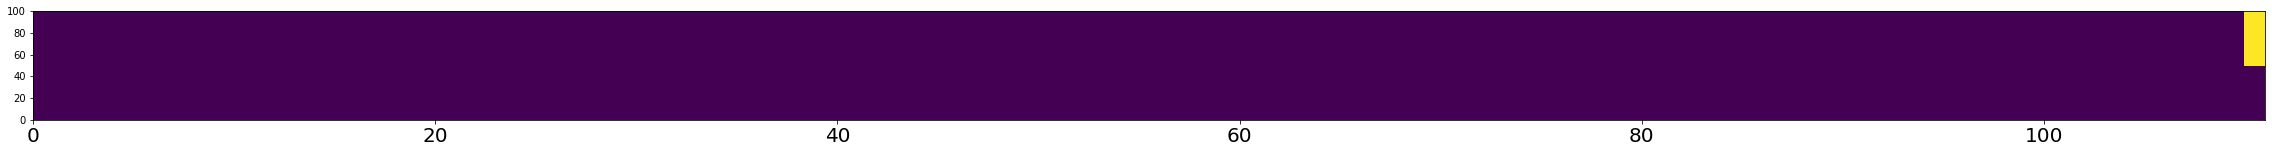

A,P,R:  0.990990990990991 0.990990990990991 1.0
Num frames:  (111, 1)
Accuracy:  0.990990990990991
Person:  164
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


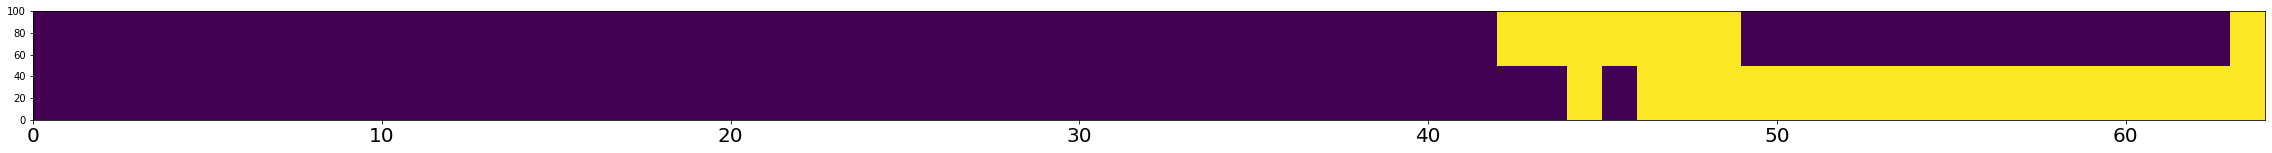

A,P,R:  0.734375 0.9333333333333333 0.75
Num frames:  (45, 3)
Accuracy:  0.734375
Person:  165
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



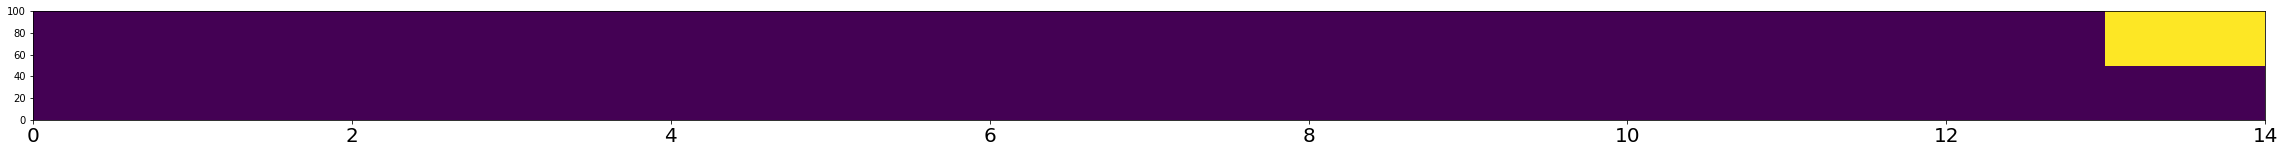

A,P,R:  0.9285714285714286 0.9285714285714286 1.0
Num frames:  (14, 1)
Accuracy:  0.9285714285714286
Person:  166
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


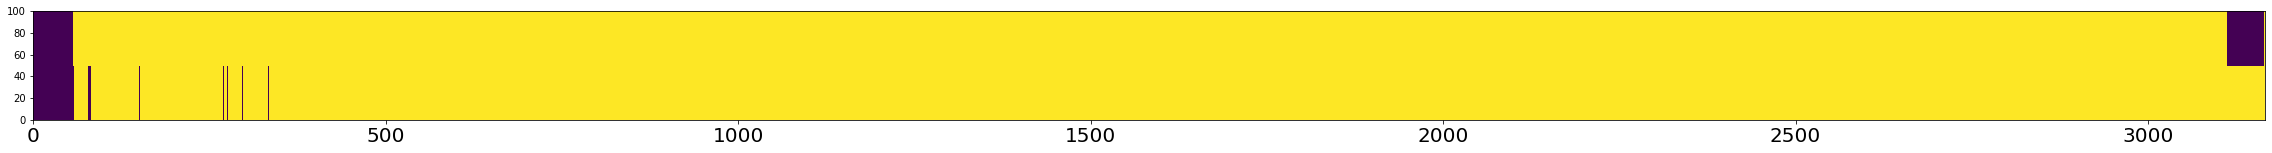

A,P,R:  0.9791535060012634 0.8169014084507042 0.5225225225225225
Num frames:  (71, 13)
Accuracy:  0.9791535060012634
Person:  167
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



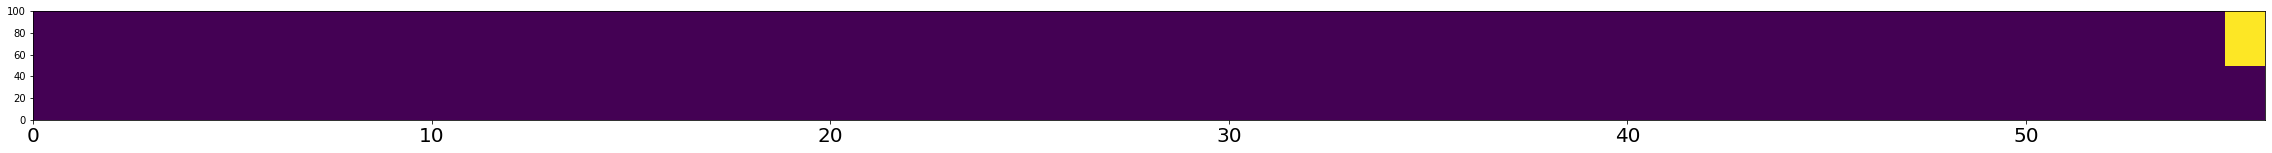

A,P,R:  0.9821428571428571 0.9821428571428571 1.0
Num frames:  (56, 1)
Accuracy:  0.9821428571428571
Person:  168
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


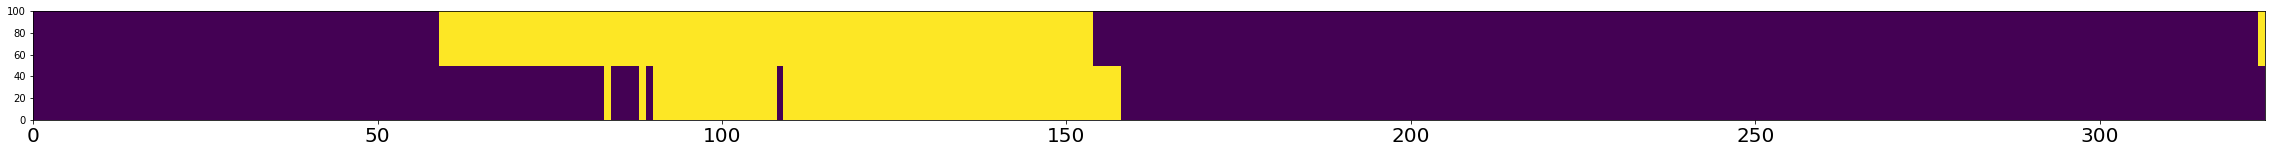

A,P,R:  0.8919753086419753 0.8784313725490196 0.9824561403508771
Num frames:  (255, 31)
Accuracy:  0.8919753086419753
Person:  169
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



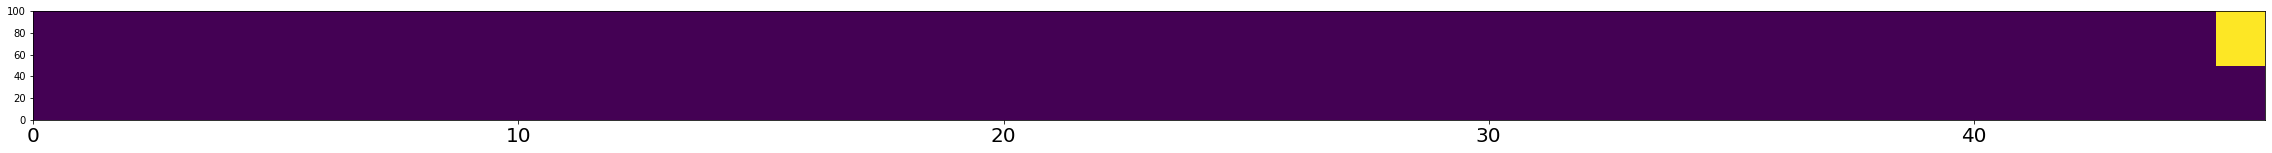

A,P,R:  0.9782608695652174 0.9782608695652174 1.0
Num frames:  (46, 1)
Accuracy:  0.9782608695652174
Person:  170
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



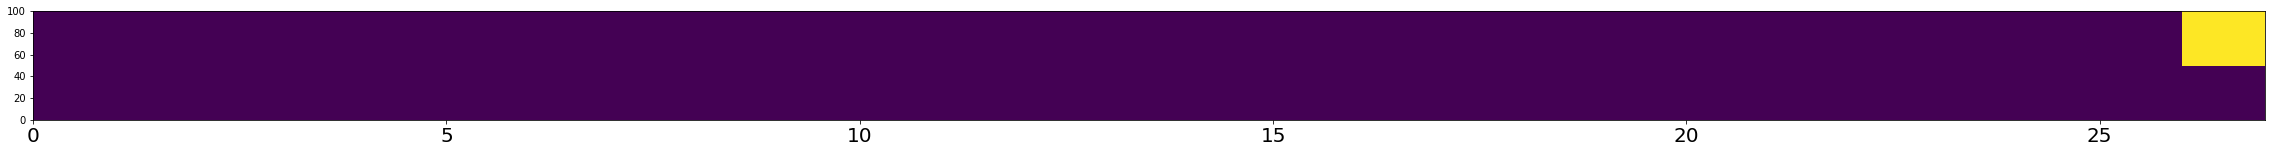

A,P,R:  0.9629629629629629 0.9629629629629629 1.0
Num frames:  (27, 1)
Accuracy:  0.9629629629629629
Person:  171
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


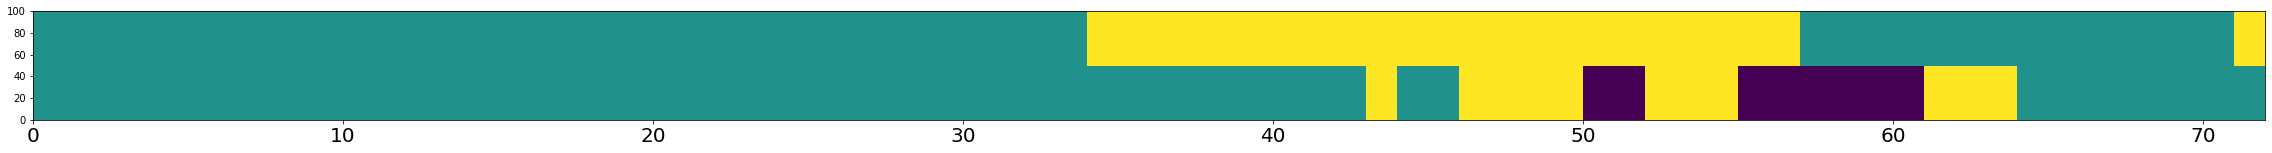

A,P,R:  0.6805555555555556 0.6721311475409836 0.8541666666666666
Num frames:  (61, 16)
Accuracy:  0.6805555555555556
Person:  172
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


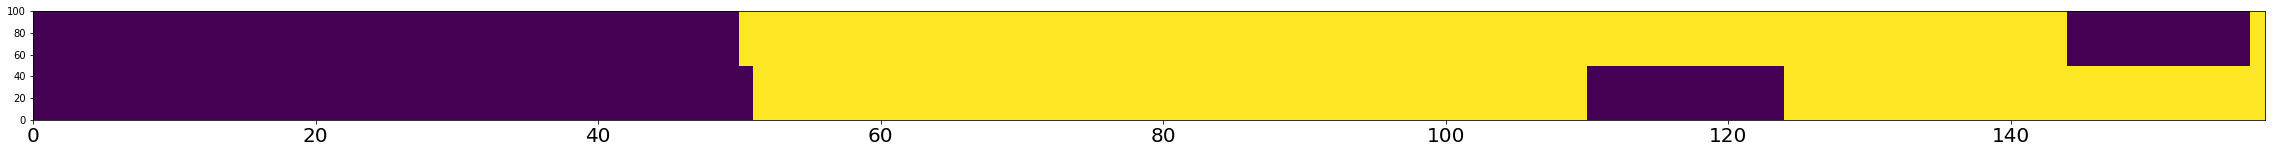

A,P,R:  0.8227848101265823 0.7692307692307693 0.7936507936507936
Num frames:  (65, 15)
Accuracy:  0.8227848101265823
Person:  173
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



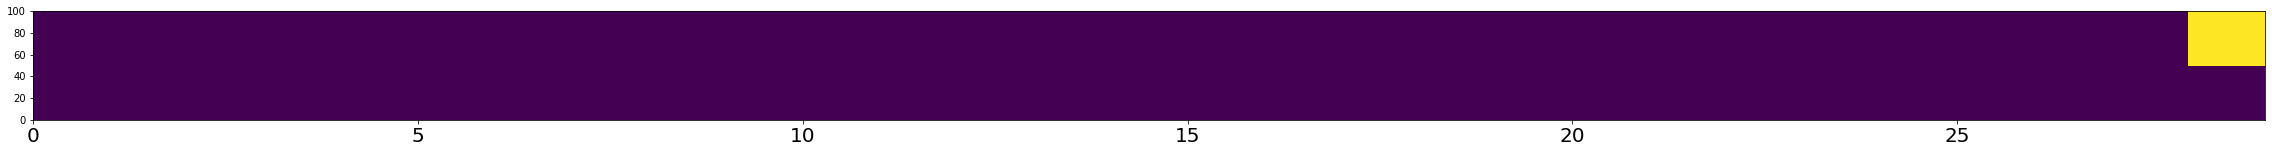

A,P,R:  0.9655172413793104 0.9655172413793104 1.0
Num frames:  (29, 1)
Accuracy:  0.9655172413793104
Person:  174
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



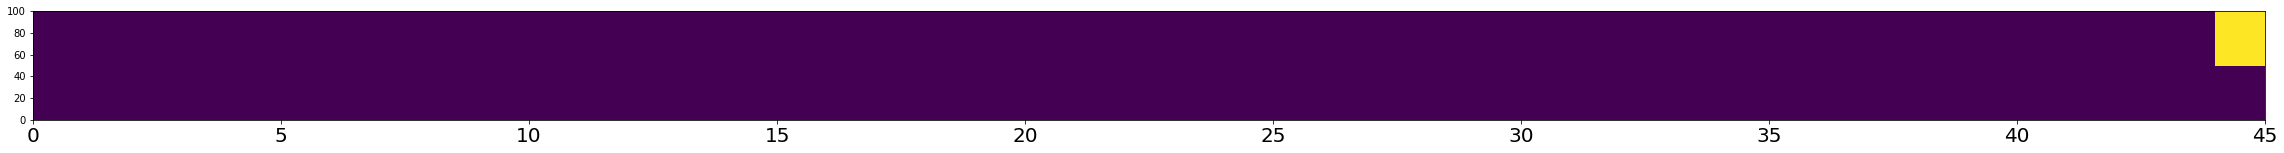

A,P,R:  0.9777777777777777 0.9777777777777777 1.0
Num frames:  (45, 1)
Accuracy:  0.9777777777777777
Person:  175
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



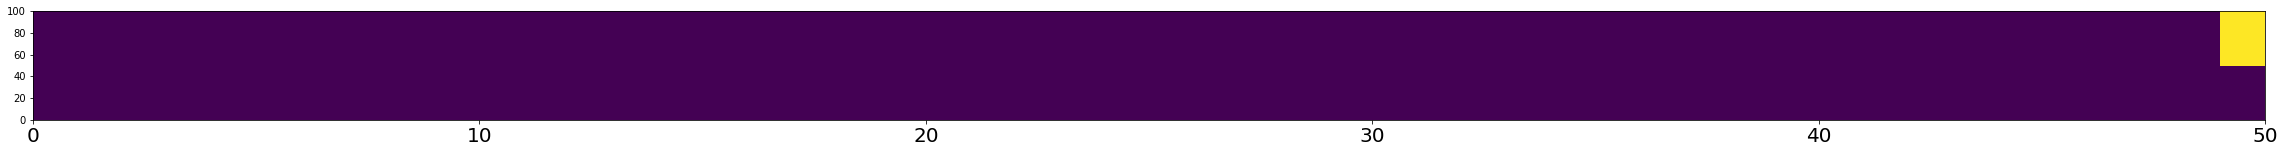

A,P,R:  0.98 0.98 1.0
Num frames:  (50, 1)
Accuracy:  0.98
Person:  176
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



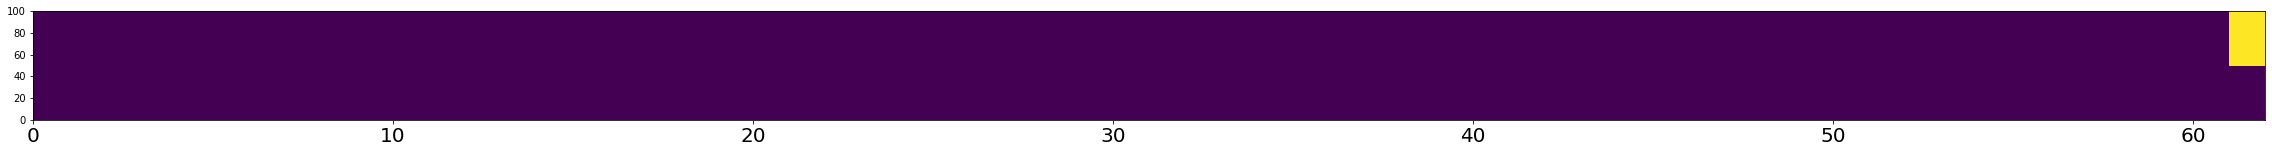

A,P,R:  0.9838709677419355 0.9838709677419355 1.0
Num frames:  (62, 1)
Accuracy:  0.9838709677419355
Person:  177
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



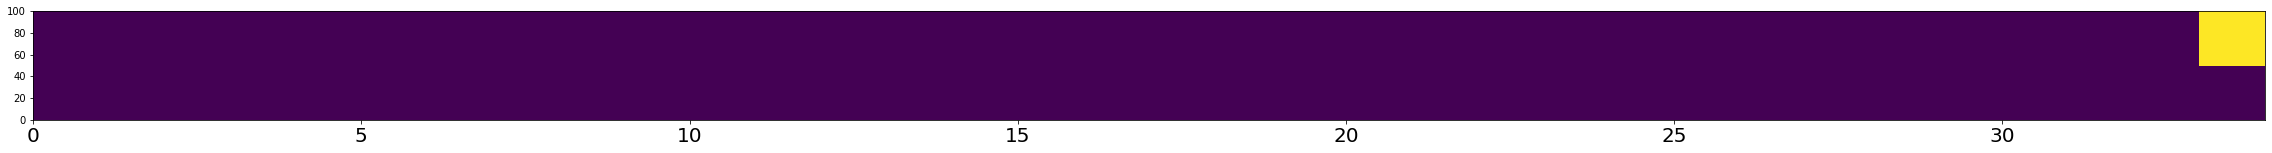

A,P,R:  0.9705882352941176 0.9705882352941176 1.0
Num frames:  (34, 1)
Accuracy:  0.9705882352941176
Person:  178
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



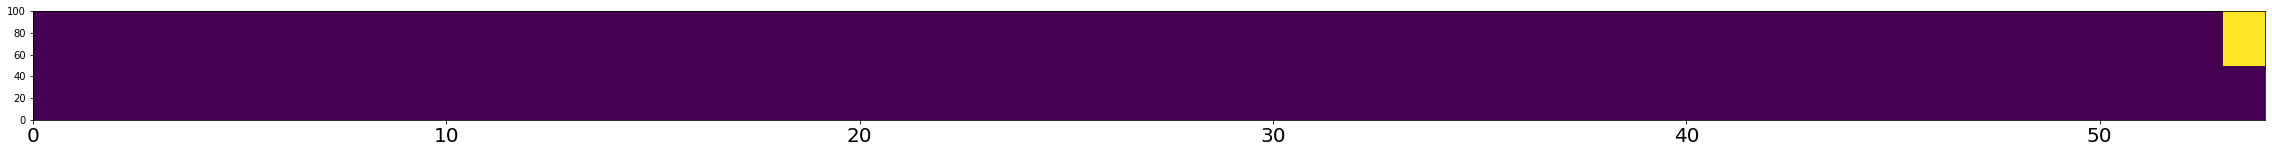

A,P,R:  0.9814814814814815 0.9814814814814815 1.0
Num frames:  (54, 1)
Accuracy:  0.9814814814814815
Person:  179
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



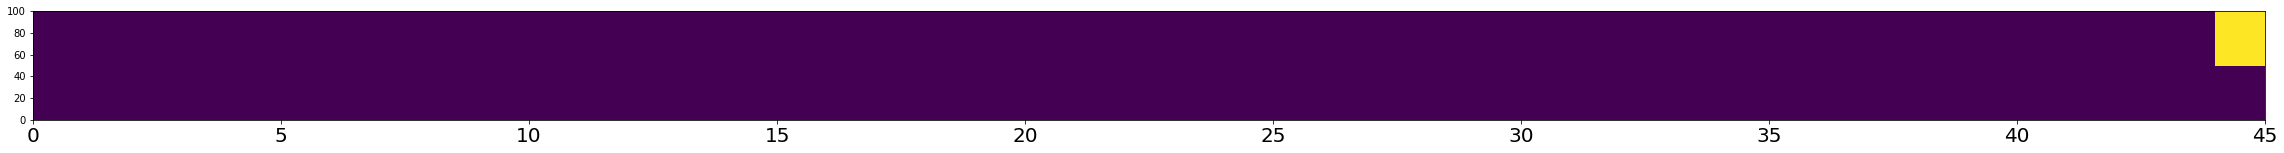

A,P,R:  0.9777777777777777 0.9777777777777777 1.0
Num frames:  (45, 1)
Accuracy:  0.9777777777777777
Person:  180
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



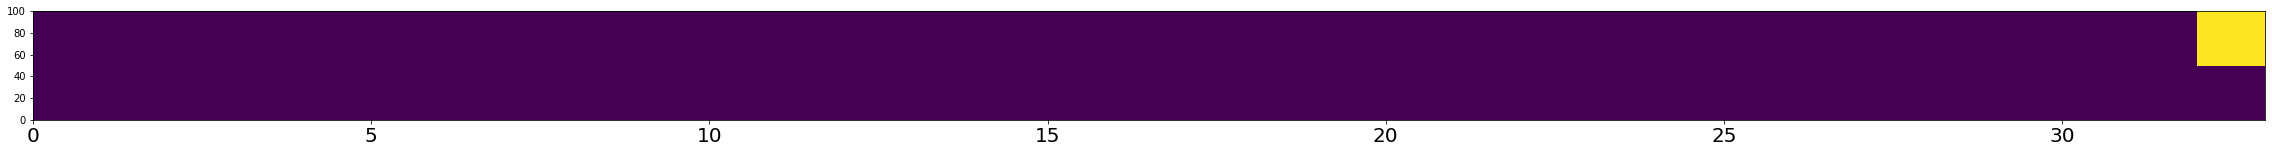

A,P,R:  0.9696969696969697 0.9696969696969697 1.0
Num frames:  (33, 1)
Accuracy:  0.9696969696969697
Person:  181
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



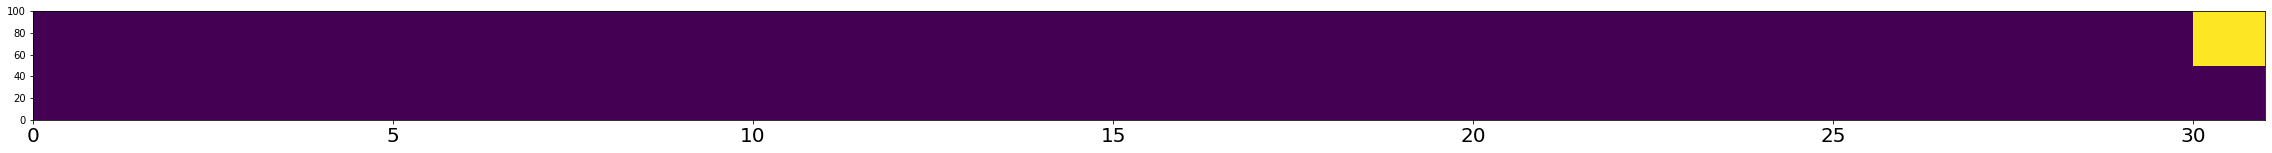

A,P,R:  0.967741935483871 0.967741935483871 1.0
Num frames:  (31, 1)
Accuracy:  0.967741935483871
Person:  182
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



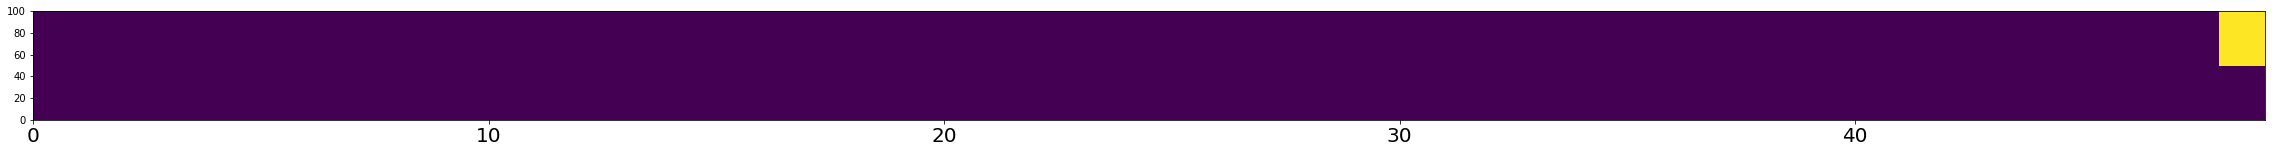

A,P,R:  0.9795918367346939 0.9795918367346939 1.0
Num frames:  (49, 1)
Accuracy:  0.9795918367346939
Person:  183
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


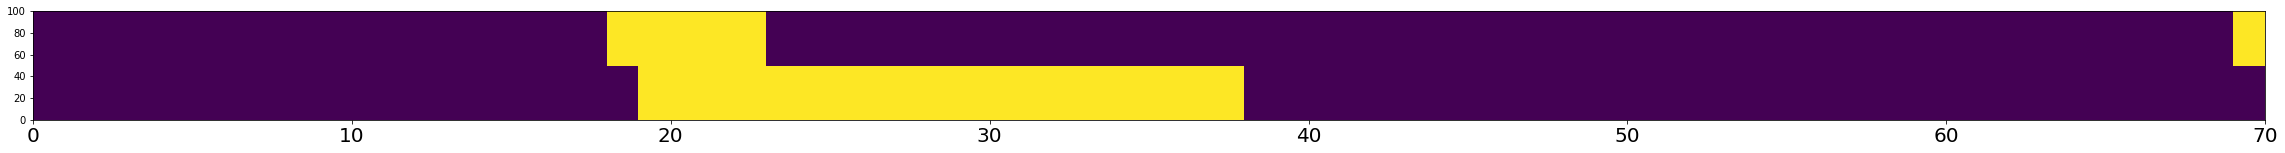

A,P,R:  0.7571428571428571 0.9607843137254902 0.765625
Num frames:  (51, 2)
Accuracy:  0.7571428571428571
Person:  184
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


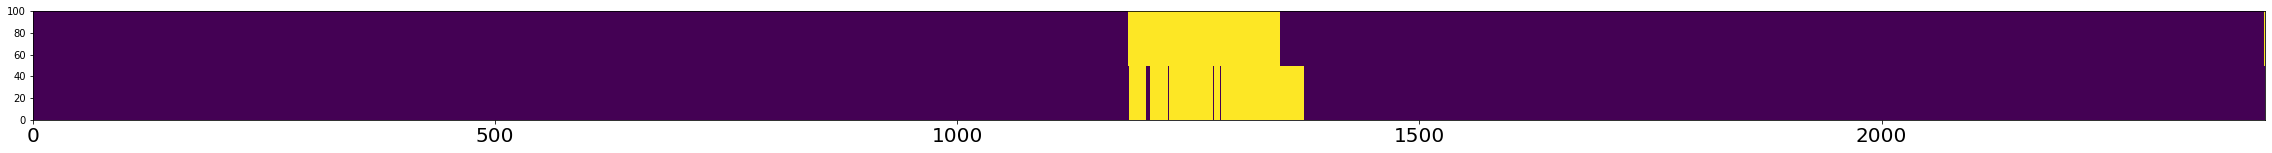

A,P,R:  0.9855072463768116 0.9959677419354839 0.9884393063583815
Num frames:  (2232, 9)
Accuracy:  0.9855072463768116
Person:  185
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  0


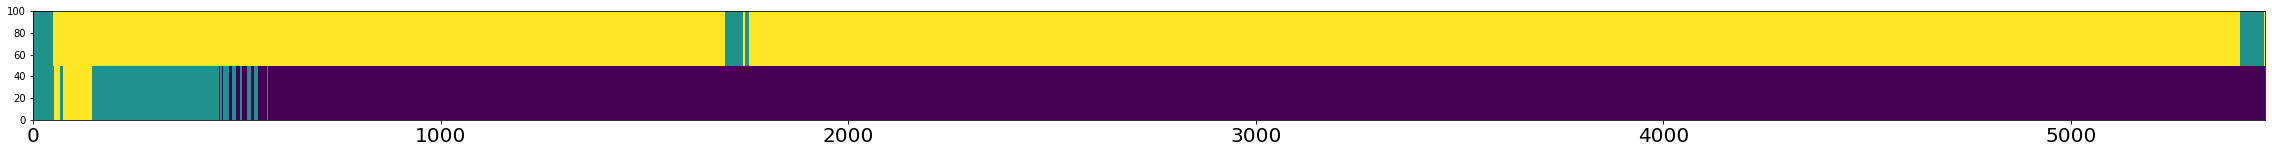

A,P,R:  0.02574872169466764 0.009468993687337541 0.3072289156626506
Num frames:  (5386, 5220)
Accuracy:  0.02574872169466764
Person:  186
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


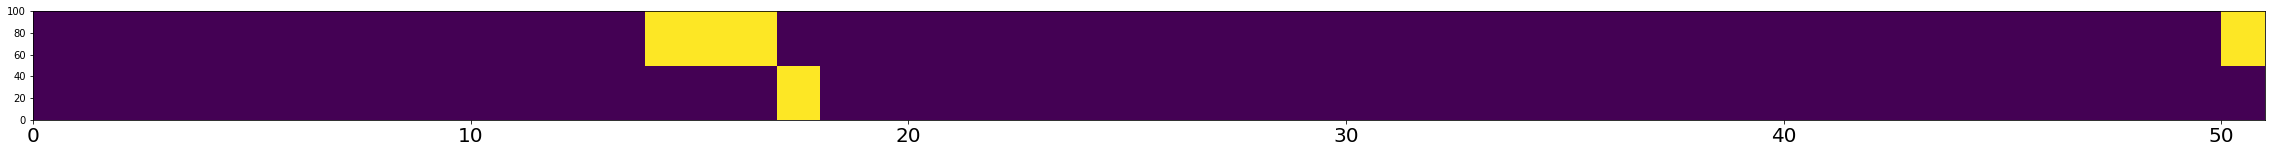

A,P,R:  0.9019607843137255 0.92 0.9787234042553191
Num frames:  (50, 4)
Accuracy:  0.9019607843137255
Person:  187
Transitions:  [2, 3, 2, 3, 2, 3]
GT transitions:  2
Transitions captured:  2


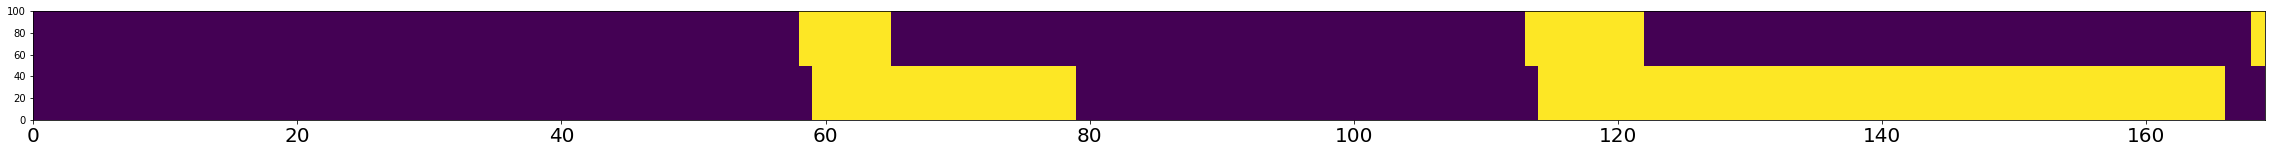

A,P,R:  0.6390532544378699 0.9690721649484536 0.618421052631579
Num frames:  (97, 3)
Accuracy:  0.6390532544378699
Person:  188
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



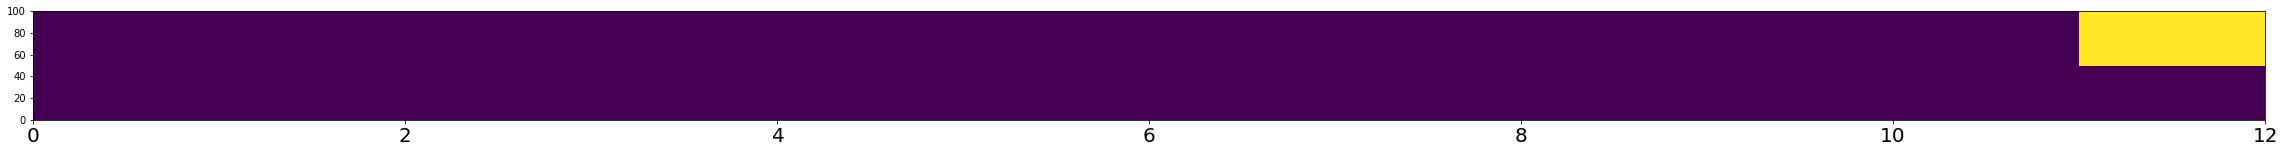

A,P,R:  0.9166666666666666 0.9166666666666666 1.0
Num frames:  (12, 1)
Accuracy:  0.9166666666666666
Person:  189
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


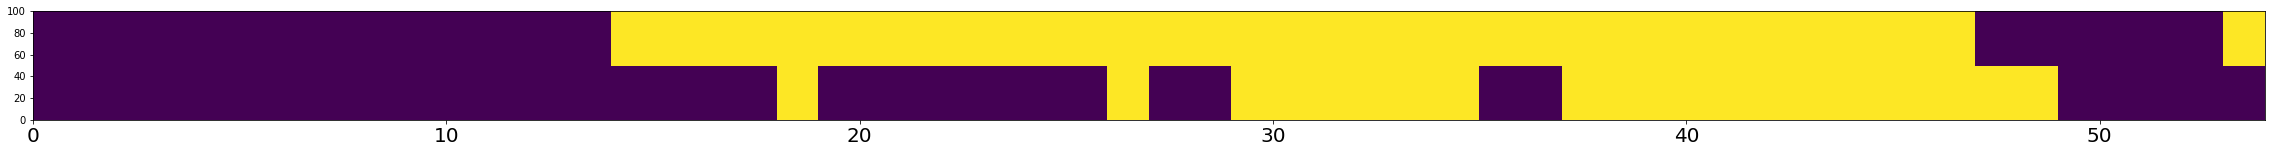

A,P,R:  0.6666666666666666 0.5294117647058824 0.9
Num frames:  (34, 16)
Accuracy:  0.6666666666666666
Person:  190
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



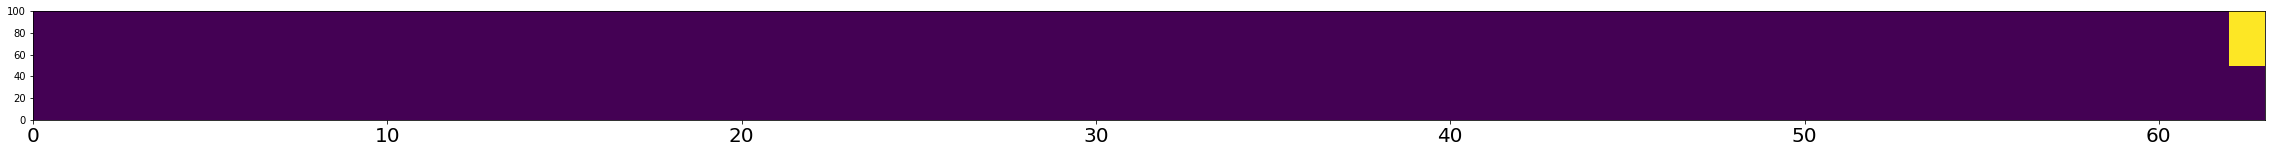

A,P,R:  0.9841269841269841 0.9841269841269841 1.0
Num frames:  (63, 1)
Accuracy:  0.9841269841269841
Person:  191
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



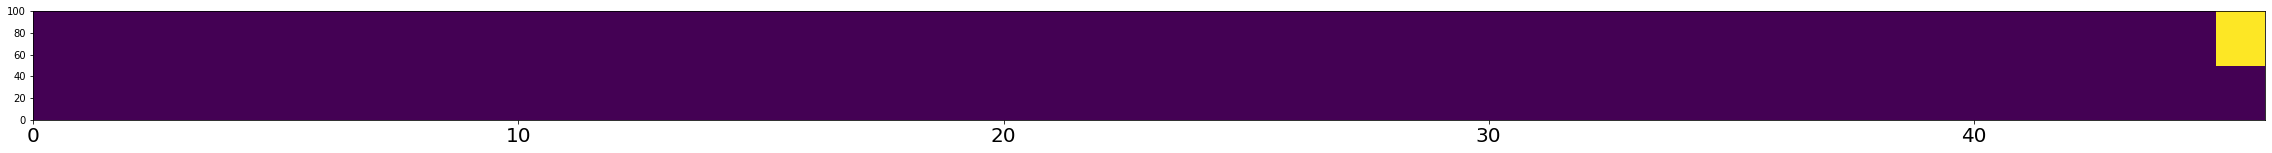

A,P,R:  0.9782608695652174 0.9782608695652174 1.0
Num frames:  (46, 1)
Accuracy:  0.9782608695652174
Person:  192
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



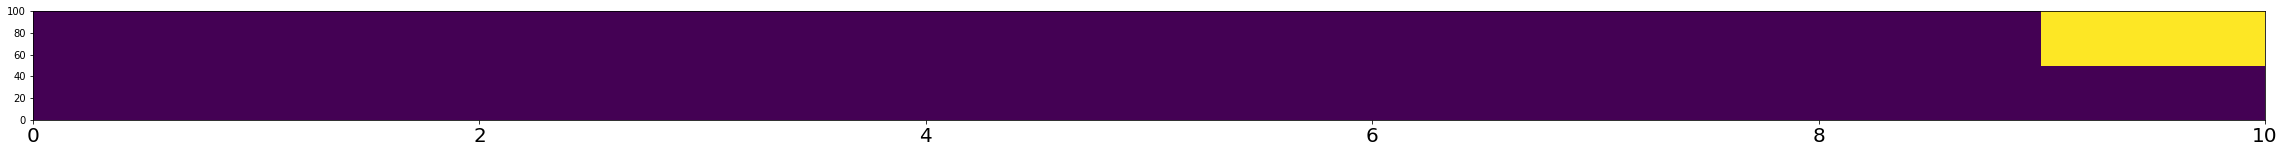

A,P,R:  0.9 0.9 1.0
Num frames:  (10, 1)
Accuracy:  0.9
Person:  193
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



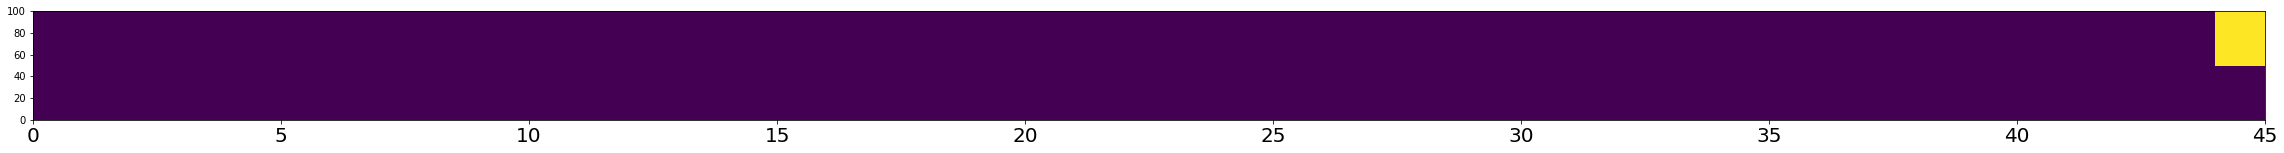

A,P,R:  0.9777777777777777 0.9777777777777777 1.0
Num frames:  (45, 1)
Accuracy:  0.9777777777777777
Person:  194
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



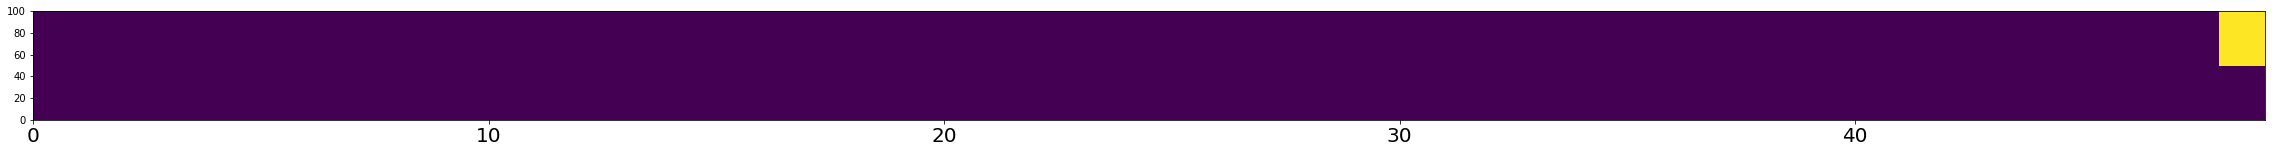

A,P,R:  0.9795918367346939 0.9795918367346939 1.0
Num frames:  (49, 1)
Accuracy:  0.9795918367346939
Person:  195
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



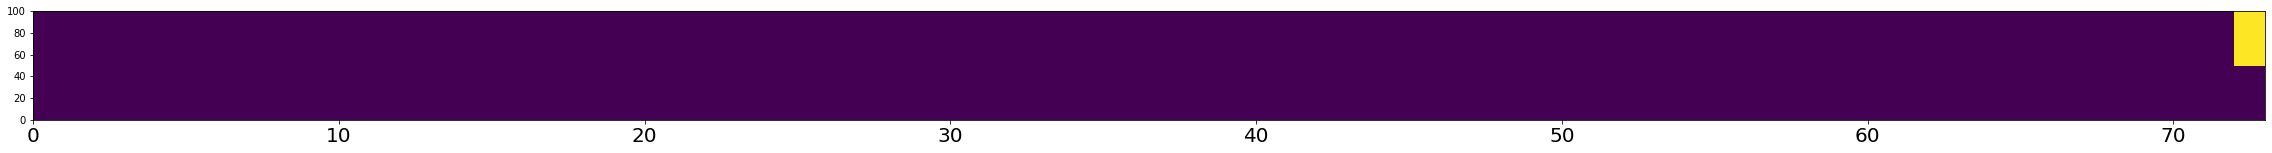

A,P,R:  0.9863013698630136 0.9863013698630136 1.0
Num frames:  (73, 1)
Accuracy:  0.9863013698630136
Person:  196
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



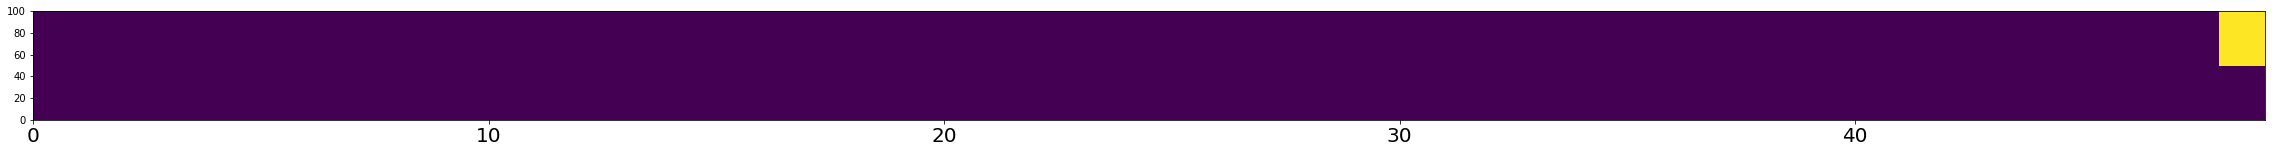

A,P,R:  0.9795918367346939 0.9795918367346939 1.0
Num frames:  (49, 1)
Accuracy:  0.9795918367346939
Person:  197
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


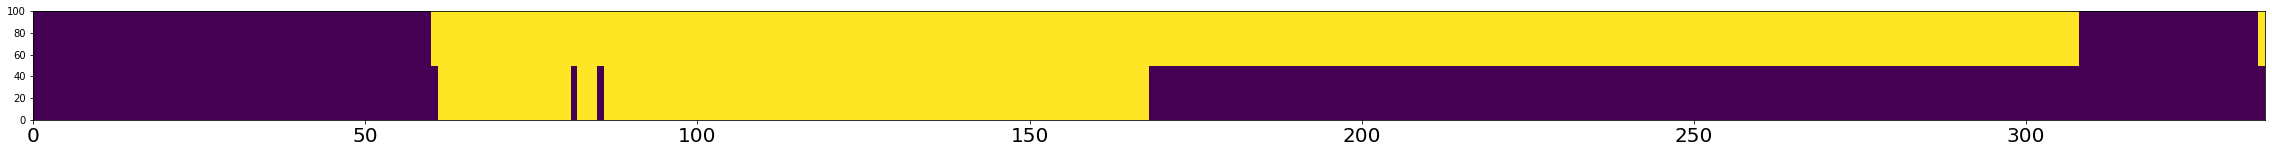

A,P,R:  0.5714285714285714 0.37662337662337664 1.0
Num frames:  (231, 144)
Accuracy:  0.5714285714285714
Person:  198
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



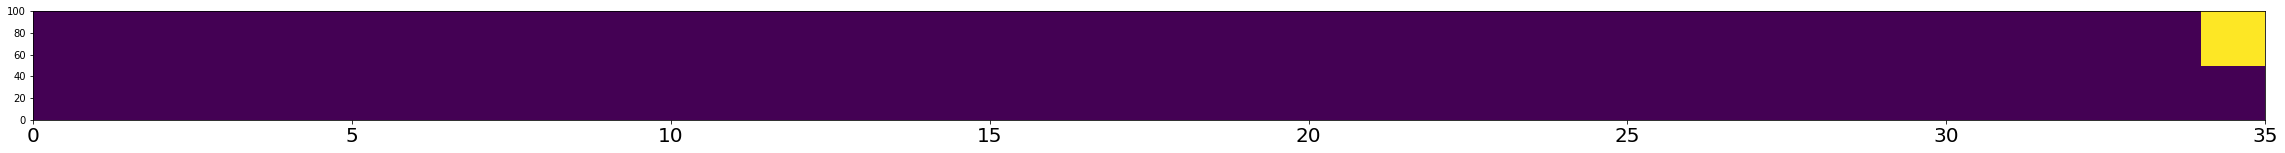

A,P,R:  0.9714285714285714 0.9714285714285714 1.0
Num frames:  (35, 1)
Accuracy:  0.9714285714285714
Person:  199
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  3


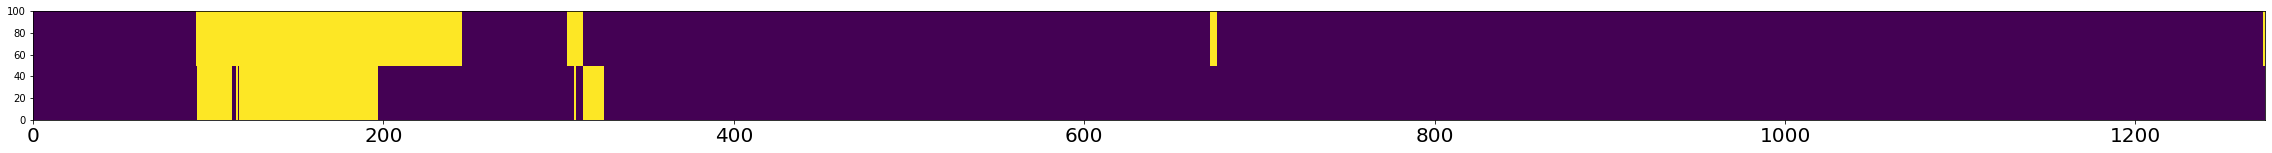

A,P,R:  0.9395604395604396 0.9440137812230835 0.9891696750902527
Num frames:  (1161, 65)
Accuracy:  0.9395604395604396
Person:  200
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



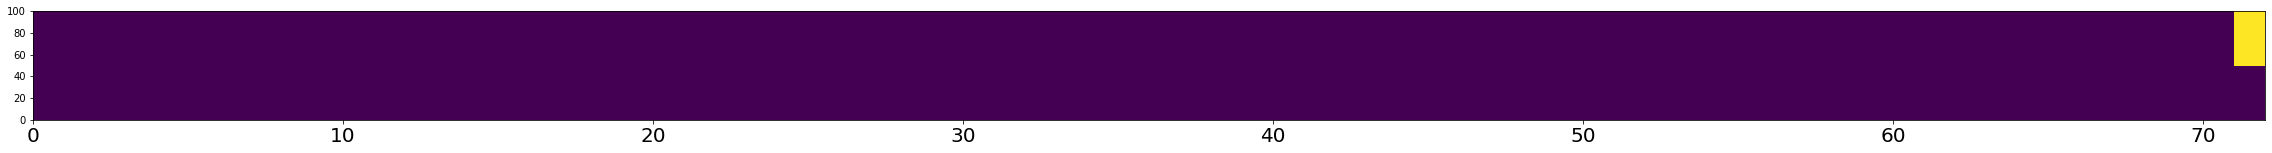

A,P,R:  0.9861111111111112 0.9861111111111112 1.0
Num frames:  (72, 1)
Accuracy:  0.9861111111111112
Person:  201
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



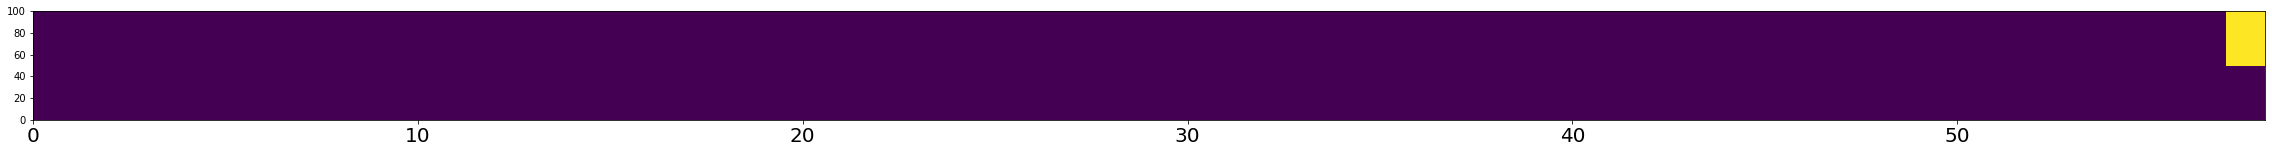

A,P,R:  0.9827586206896551 0.9827586206896551 1.0
Num frames:  (58, 1)
Accuracy:  0.9827586206896551
Person:  202
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



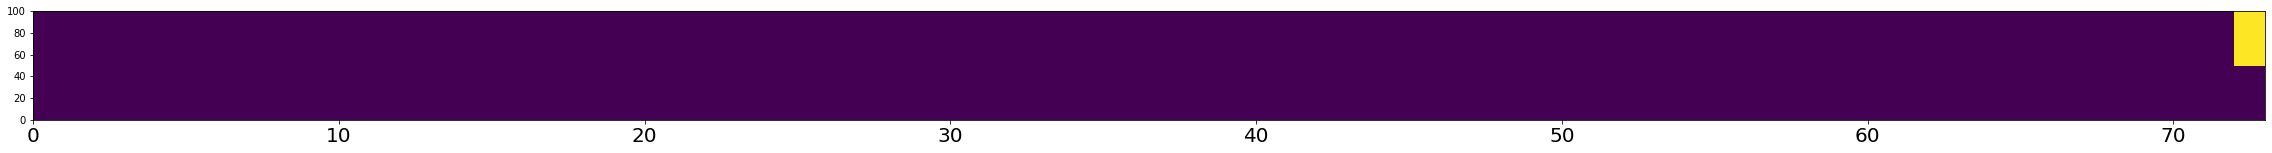

A,P,R:  0.9863013698630136 0.9863013698630136 1.0
Num frames:  (73, 1)
Accuracy:  0.9863013698630136
Person:  203
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



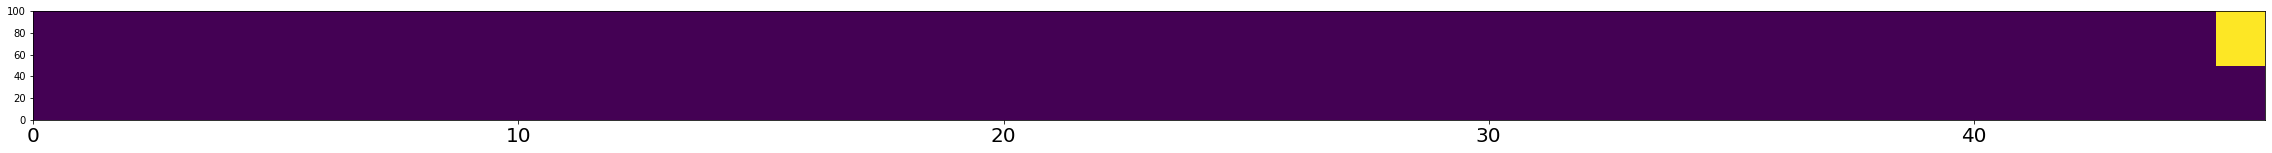

A,P,R:  0.9782608695652174 0.9782608695652174 1.0
Num frames:  (46, 1)
Accuracy:  0.9782608695652174
Person:  204
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



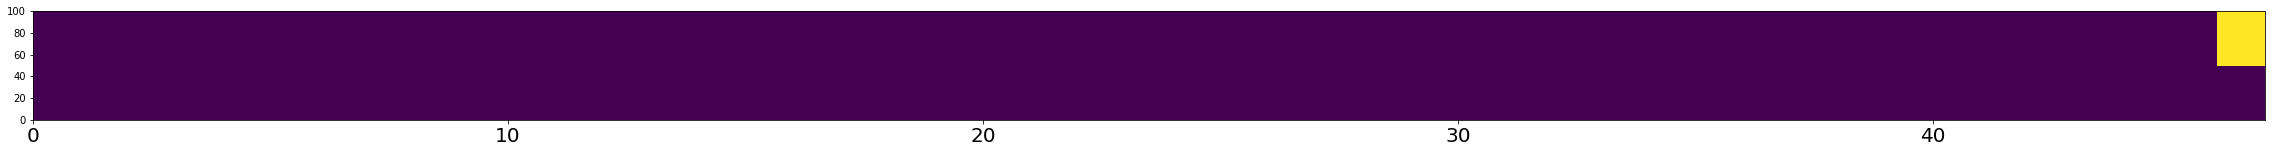

A,P,R:  0.9787234042553191 0.9787234042553191 1.0
Num frames:  (47, 1)
Accuracy:  0.9787234042553191
Person:  205
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



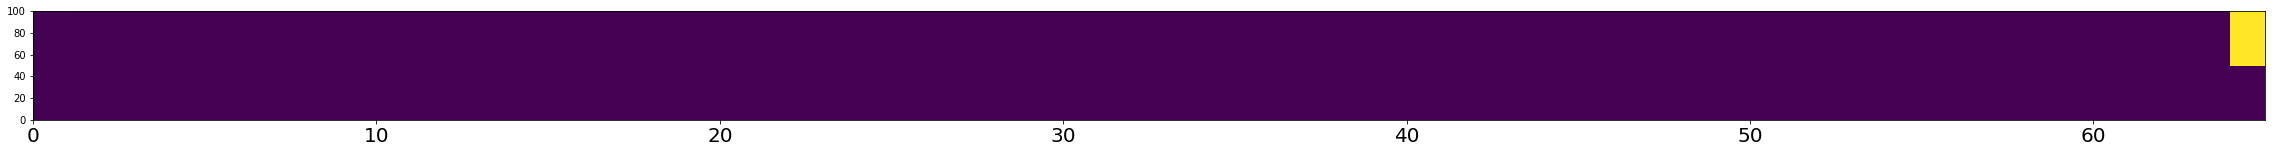

A,P,R:  0.9846153846153847 0.9846153846153847 1.0
Num frames:  (65, 1)
Accuracy:  0.9846153846153847
Person:  206
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



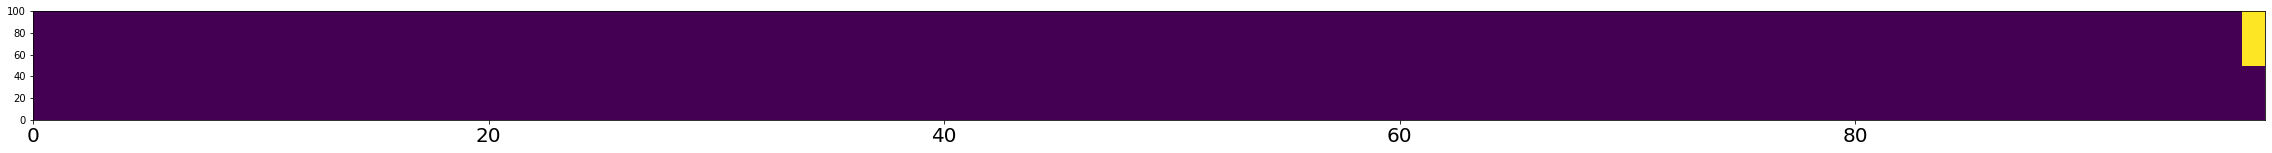

A,P,R:  0.9897959183673469 0.9897959183673469 1.0
Num frames:  (98, 1)
Accuracy:  0.9897959183673469
Person:  207
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


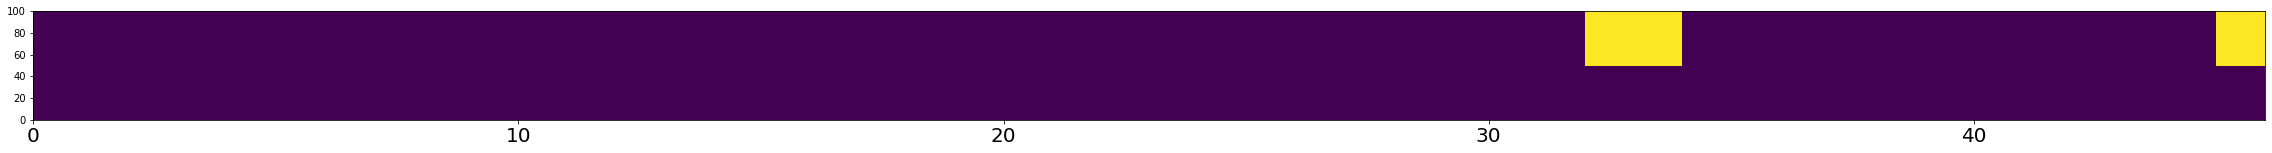

A,P,R:  0.9347826086956522 0.9347826086956522 1.0
Num frames:  (46, 3)
Accuracy:  0.9347826086956522
Person:  208
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



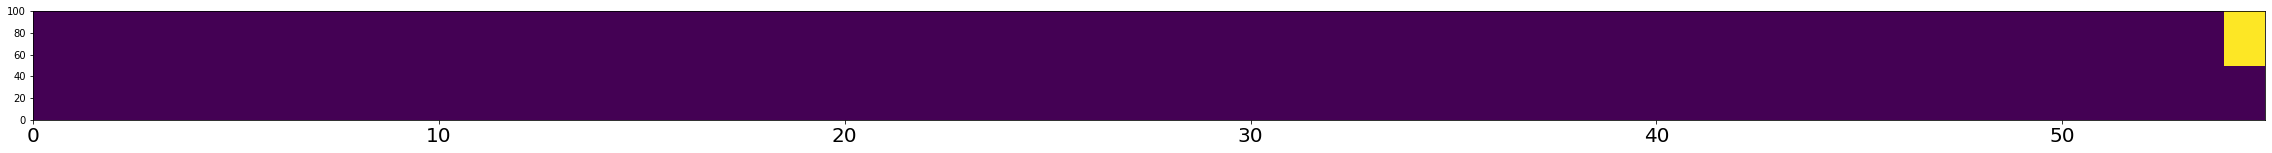

A,P,R:  0.9818181818181818 0.9818181818181818 1.0
Num frames:  (55, 1)
Accuracy:  0.9818181818181818
Person:  209
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



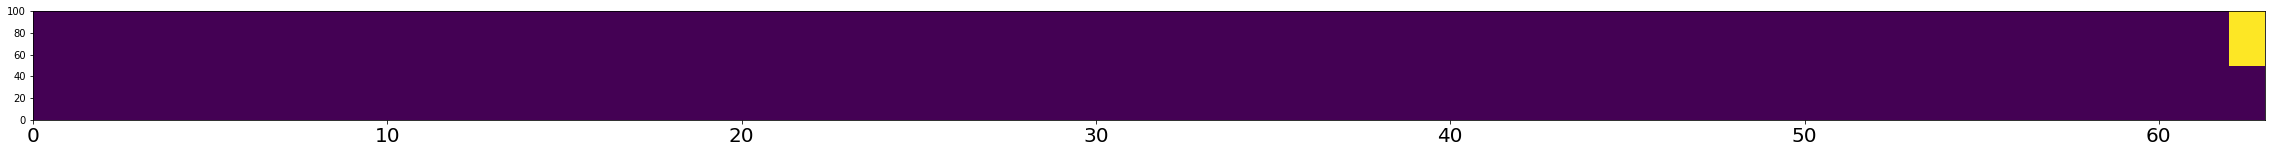

A,P,R:  0.9841269841269841 0.9841269841269841 1.0
Num frames:  (63, 1)
Accuracy:  0.9841269841269841
Person:  210
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



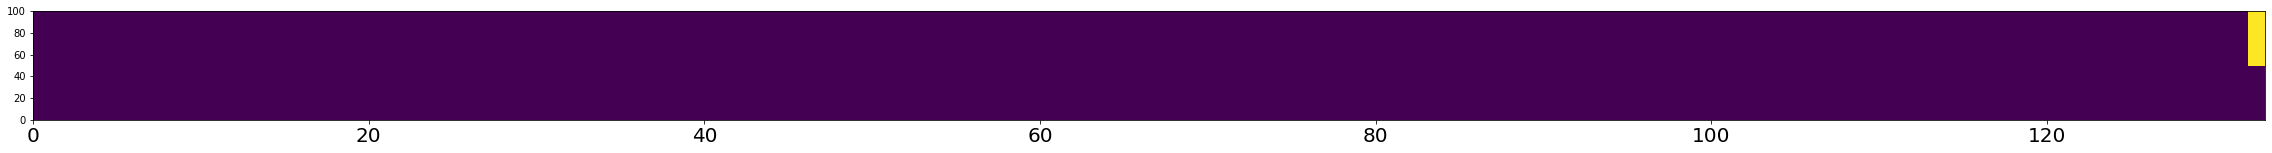

A,P,R:  0.9924812030075187 0.9924812030075187 1.0
Num frames:  (133, 1)
Accuracy:  0.9924812030075187
Person:  211
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  3


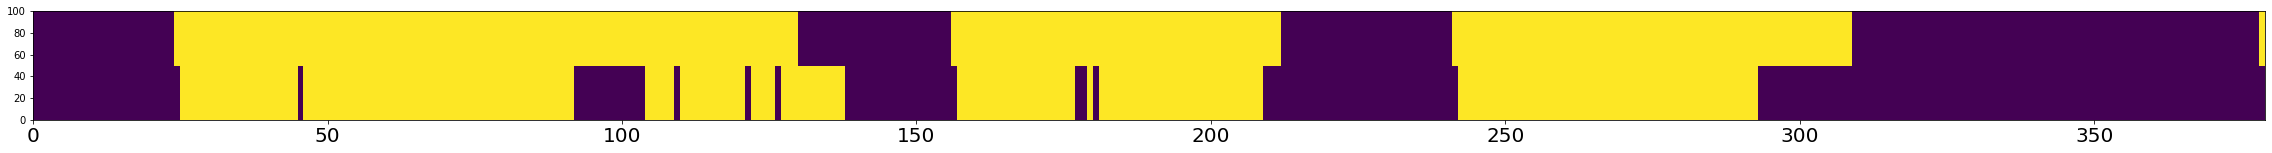

A,P,R:  0.8680738786279684 0.7692307692307693 0.9459459459459459
Num frames:  (182, 42)
Accuracy:  0.8680738786279684
Person:  212
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



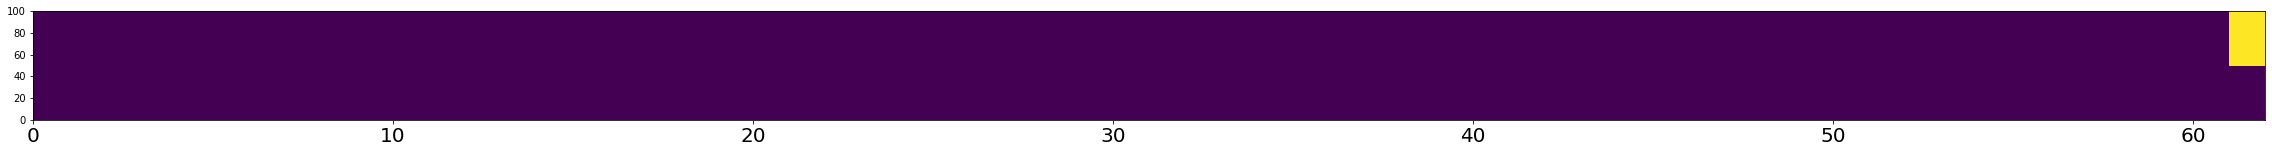

A,P,R:  0.9838709677419355 0.9838709677419355 1.0
Num frames:  (62, 1)
Accuracy:  0.9838709677419355
Person:  213
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



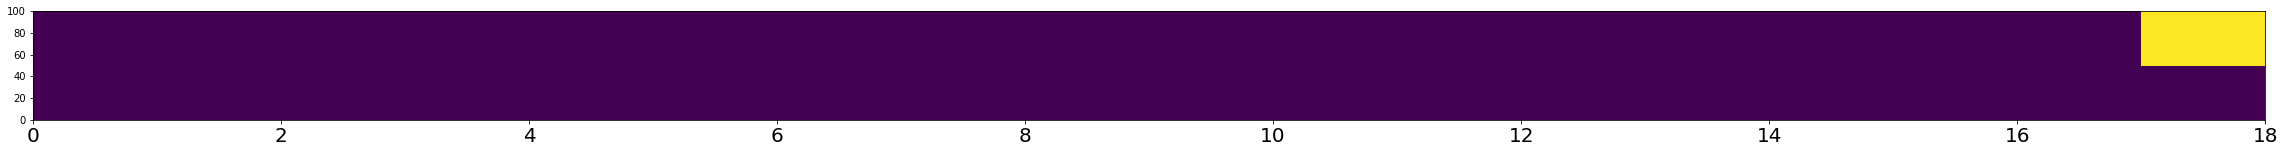

A,P,R:  0.9444444444444444 0.9444444444444444 1.0
Num frames:  (18, 1)
Accuracy:  0.9444444444444444
Person:  214
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


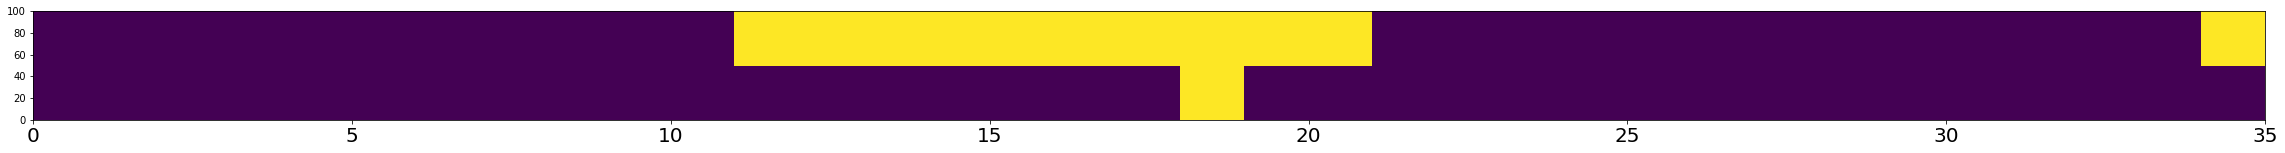

A,P,R:  0.7142857142857143 0.7058823529411765 1.0
Num frames:  (34, 10)
Accuracy:  0.7142857142857143
Person:  215
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



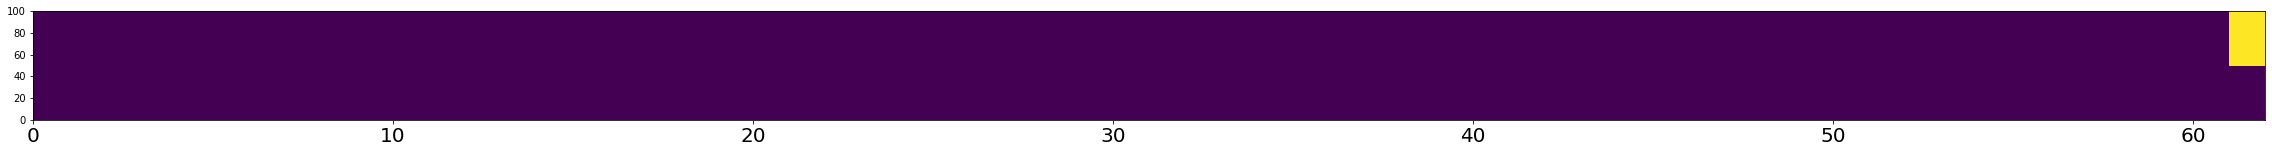

A,P,R:  0.9838709677419355 0.9838709677419355 1.0
Num frames:  (62, 1)
Accuracy:  0.9838709677419355
Person:  216
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



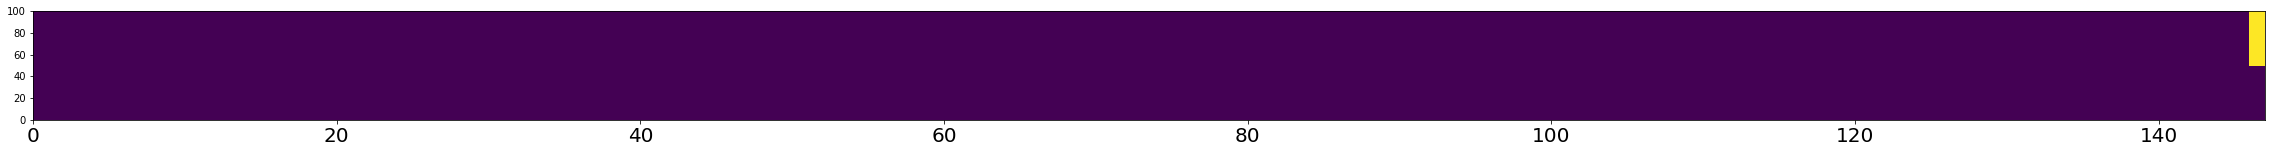

A,P,R:  0.9931972789115646 0.9931972789115646 1.0
Num frames:  (147, 1)
Accuracy:  0.9931972789115646
Person:  217
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



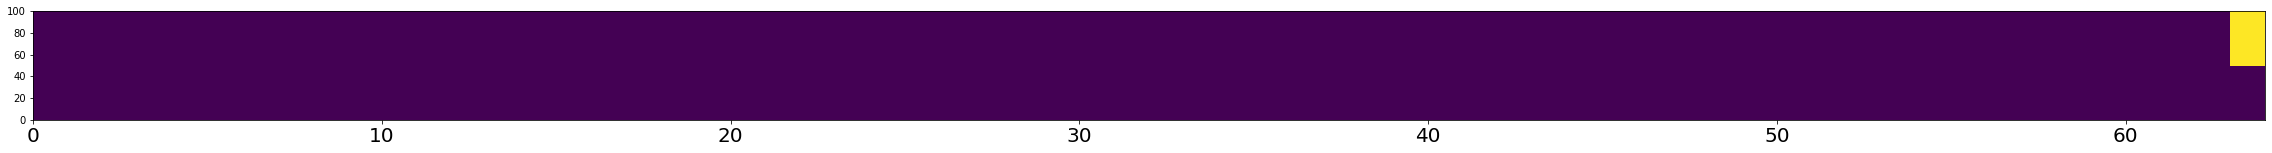

A,P,R:  0.984375 0.984375 1.0
Num frames:  (64, 1)
Accuracy:  0.984375
Person:  218
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



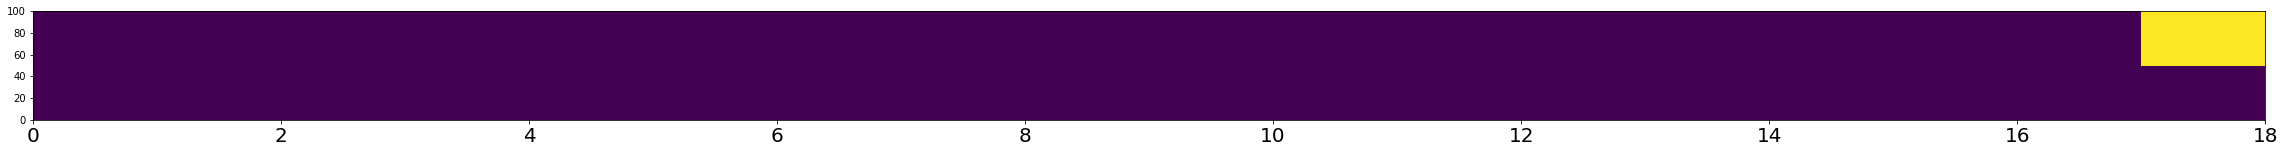

A,P,R:  0.9444444444444444 0.9444444444444444 1.0
Num frames:  (18, 1)
Accuracy:  0.9444444444444444
Person:  219
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



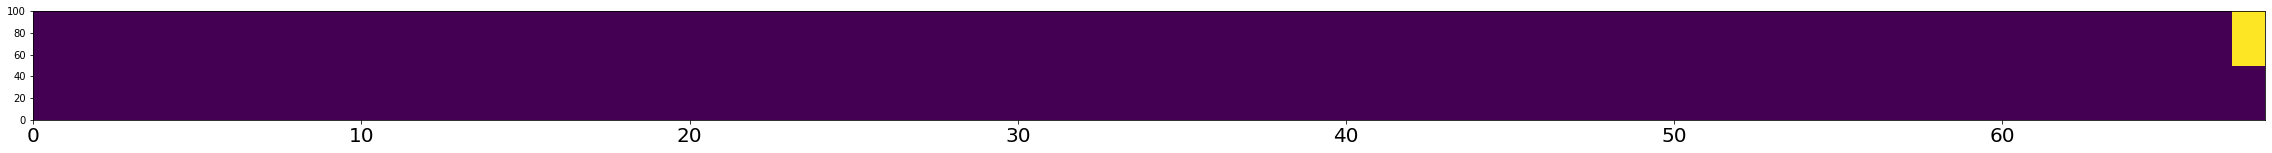

A,P,R:  0.9852941176470589 0.9852941176470589 1.0
Num frames:  (68, 1)
Accuracy:  0.9852941176470589
Person:  220
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



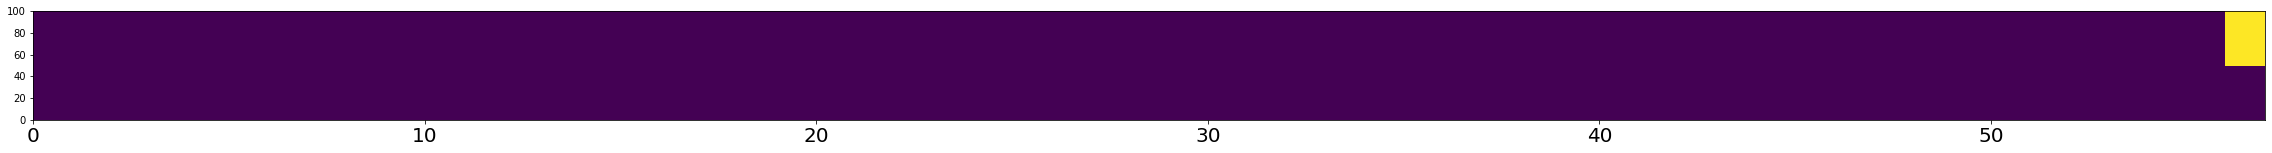

A,P,R:  0.9824561403508771 0.9824561403508771 1.0
Num frames:  (57, 1)
Accuracy:  0.9824561403508771
Person:  221
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


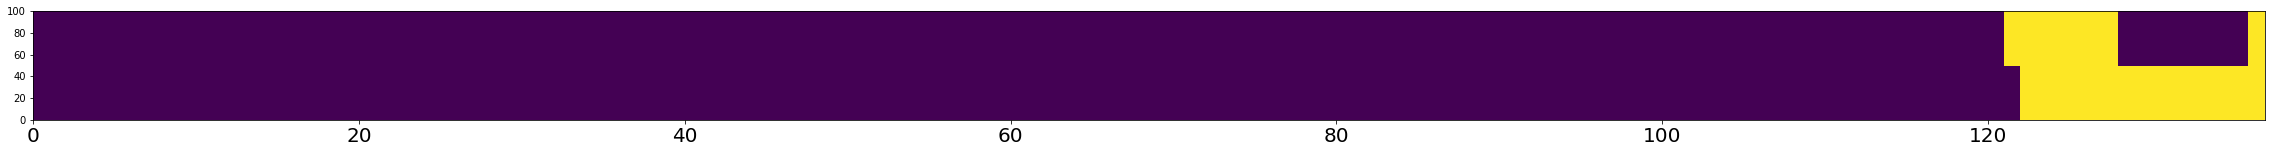

A,P,R:  0.9343065693430657 0.9918032786885246 0.937984496124031
Num frames:  (122, 1)
Accuracy:  0.9343065693430657
Person:  222
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



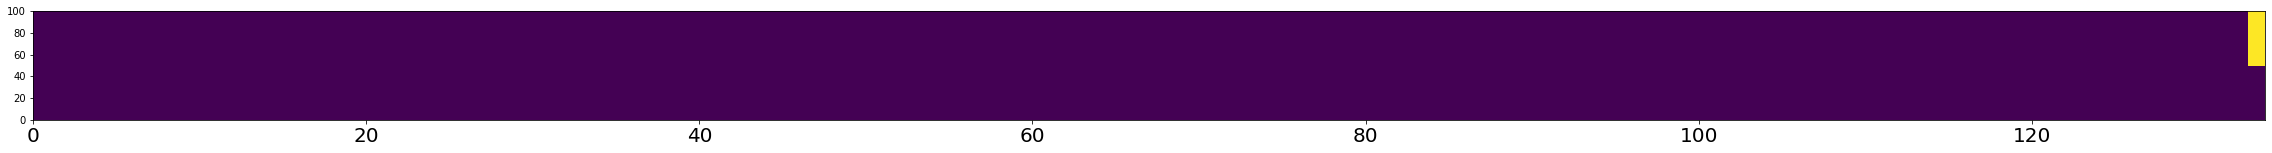

A,P,R:  0.9925373134328358 0.9925373134328358 1.0
Num frames:  (134, 1)
Accuracy:  0.9925373134328358
Person:  223
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



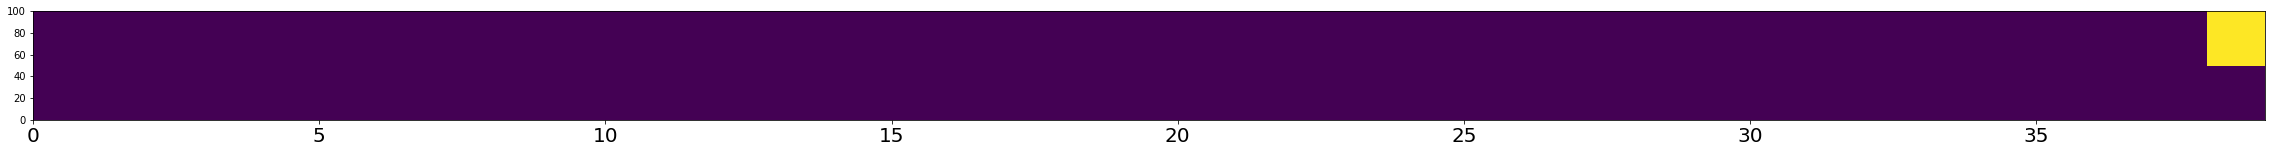

A,P,R:  0.9743589743589743 0.9743589743589743 1.0
Num frames:  (39, 1)
Accuracy:  0.9743589743589743
Person:  224
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



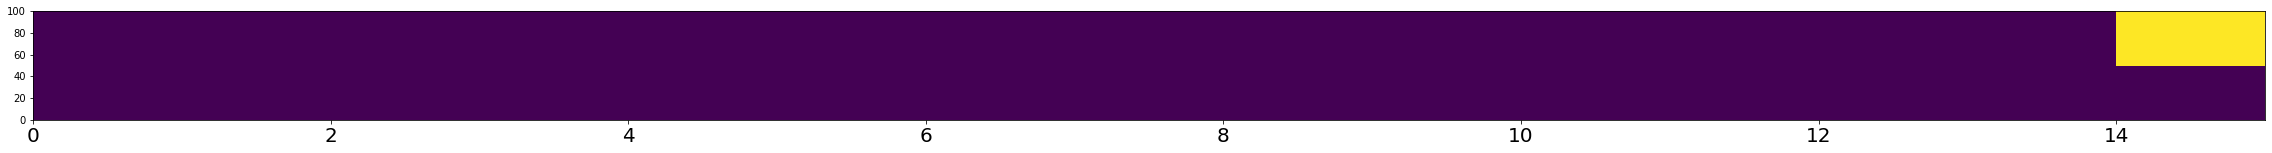

A,P,R:  0.9333333333333333 0.9333333333333333 1.0
Num frames:  (15, 1)
Accuracy:  0.9333333333333333
Person:  225
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



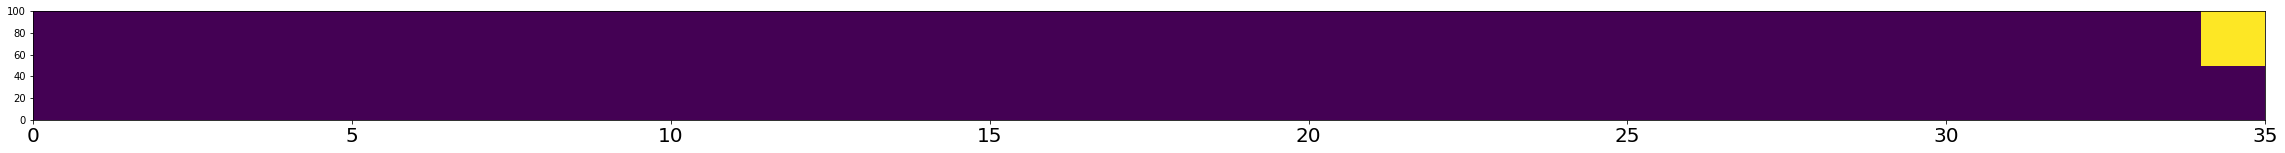

A,P,R:  0.9714285714285714 0.9714285714285714 1.0
Num frames:  (35, 1)
Accuracy:  0.9714285714285714
Person:  226
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


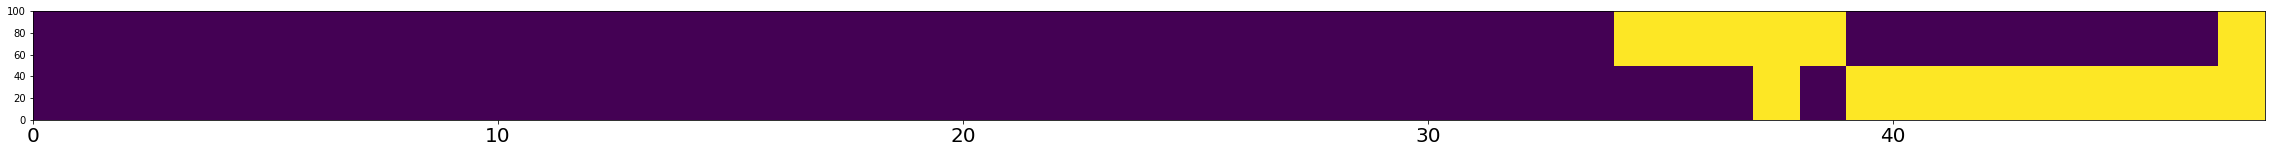

A,P,R:  0.75 0.8947368421052632 0.8095238095238095
Num frames:  (38, 4)
Accuracy:  0.75
Person:  227
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



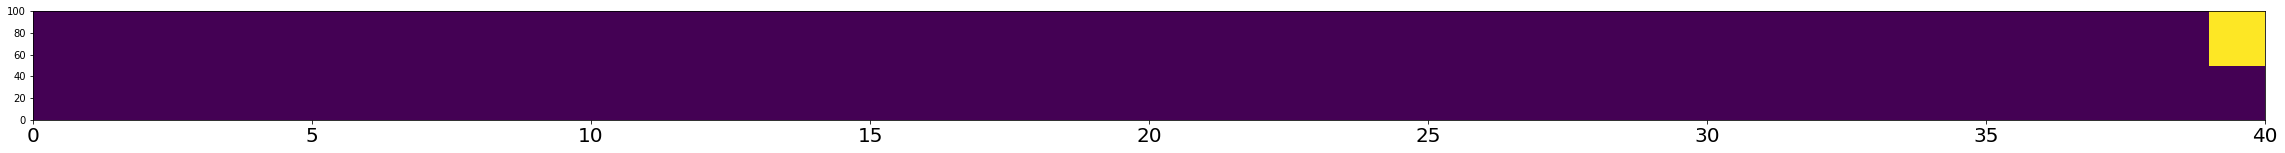

A,P,R:  0.975 0.975 1.0
Num frames:  (40, 1)
Accuracy:  0.975
Person:  228
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



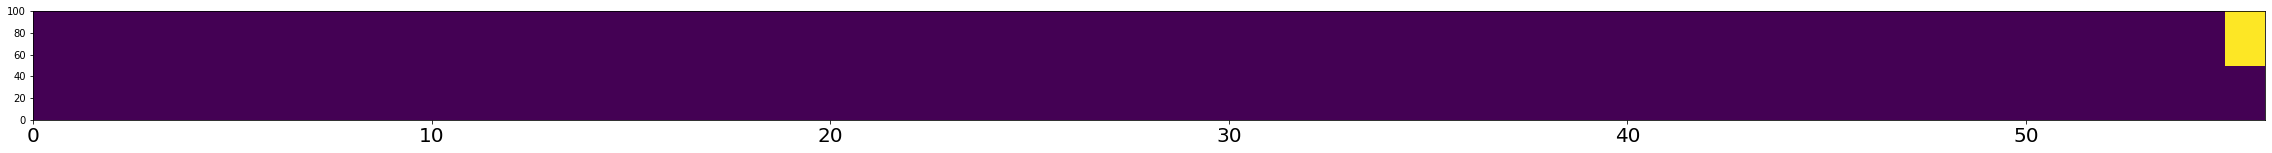

A,P,R:  0.9821428571428571 0.9821428571428571 1.0
Num frames:  (56, 1)
Accuracy:  0.9821428571428571
Person:  229
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



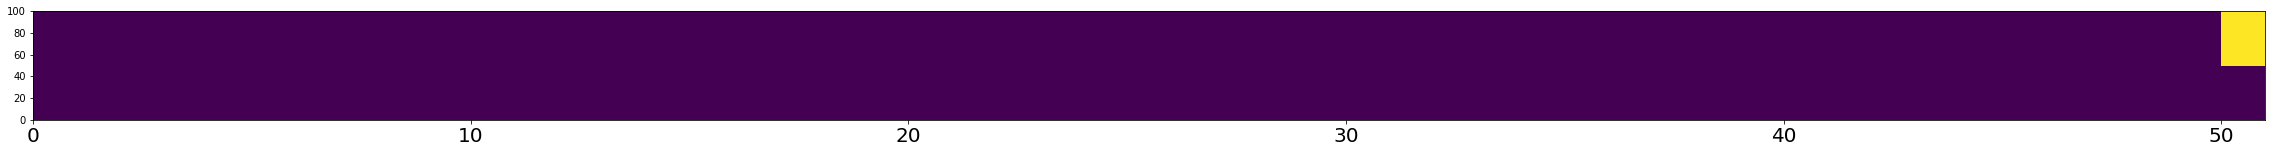

A,P,R:  0.9803921568627451 0.9803921568627451 1.0
Num frames:  (51, 1)
Accuracy:  0.9803921568627451
Person:  230
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


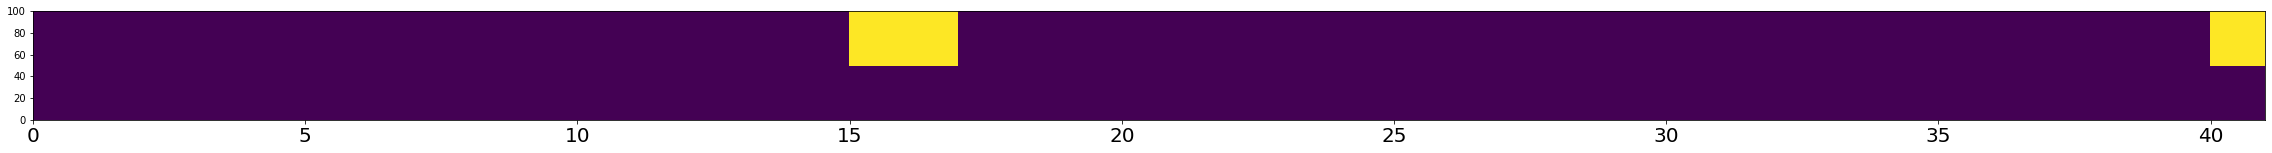

A,P,R:  0.926829268292683 0.926829268292683 1.0
Num frames:  (41, 3)
Accuracy:  0.926829268292683
Person:  231
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



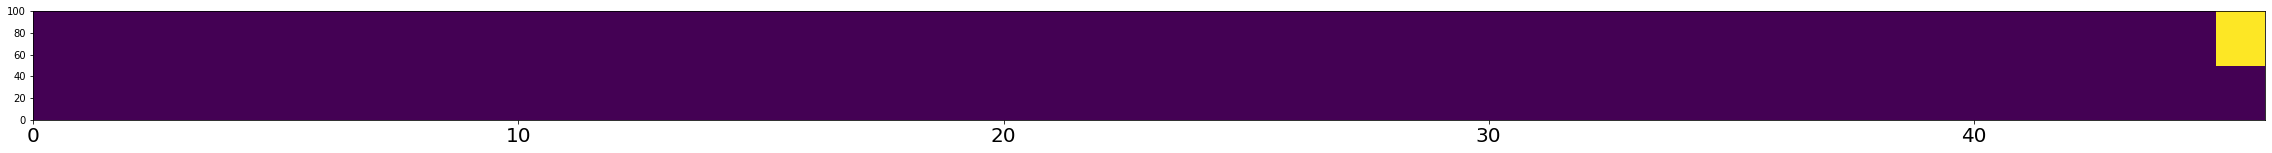

A,P,R:  0.9782608695652174 0.9782608695652174 1.0
Num frames:  (46, 1)
Accuracy:  0.9782608695652174
Person:  232
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


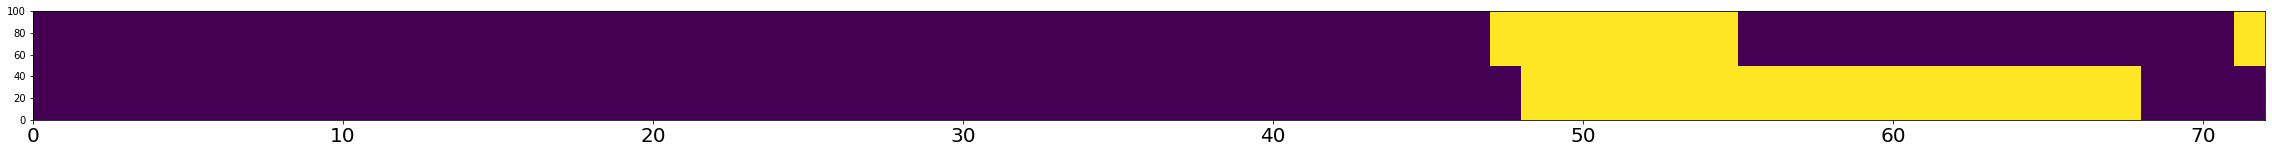

A,P,R:  0.7916666666666666 0.9615384615384616 0.7936507936507936
Num frames:  (52, 2)
Accuracy:  0.7916666666666666
Person:  233
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



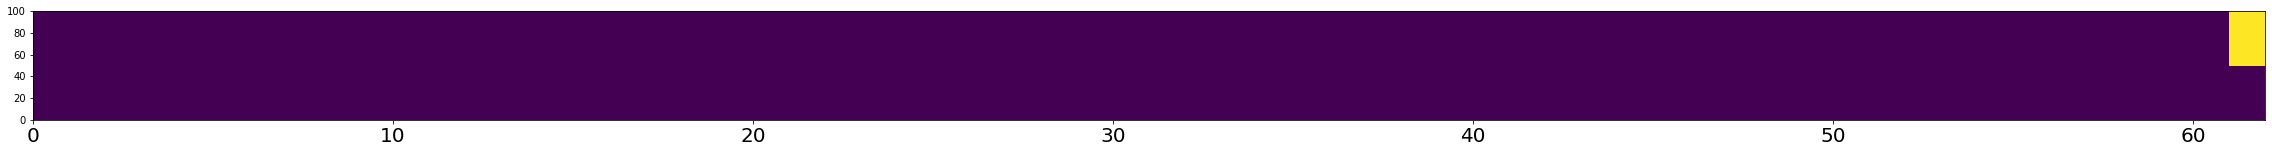

A,P,R:  0.9838709677419355 0.9838709677419355 1.0
Num frames:  (62, 1)
Accuracy:  0.9838709677419355
Person:  234
Transitions:  [2, 3, 2, 3, 2, 3]
GT transitions:  2
Transitions captured:  1


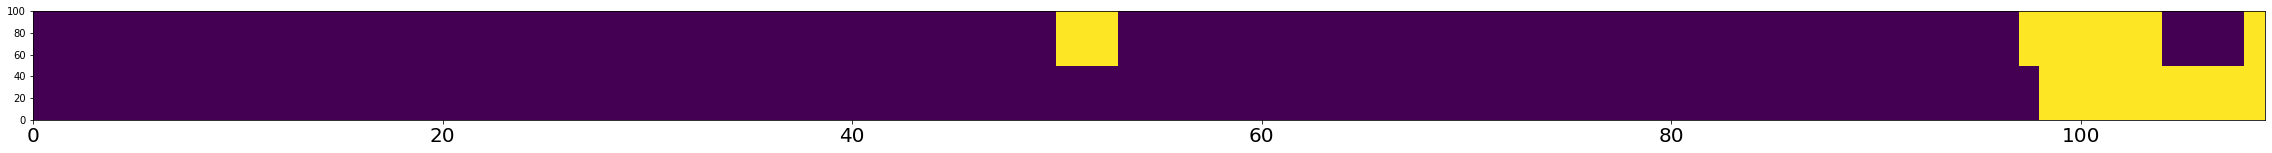

A,P,R:  0.926605504587156 0.9591836734693877 0.9591836734693877
Num frames:  (98, 4)
Accuracy:  0.926605504587156
Person:  235
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


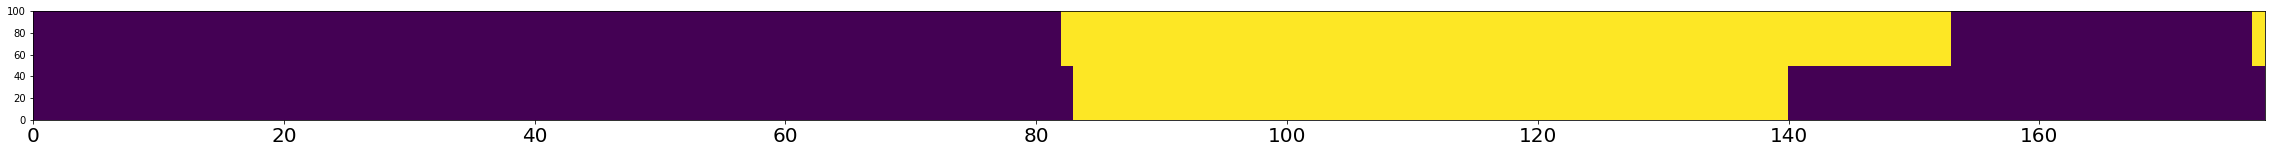

A,P,R:  0.9157303370786517 0.8760330578512396 1.0
Num frames:  (121, 15)
Accuracy:  0.9157303370786517
Person:  236
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



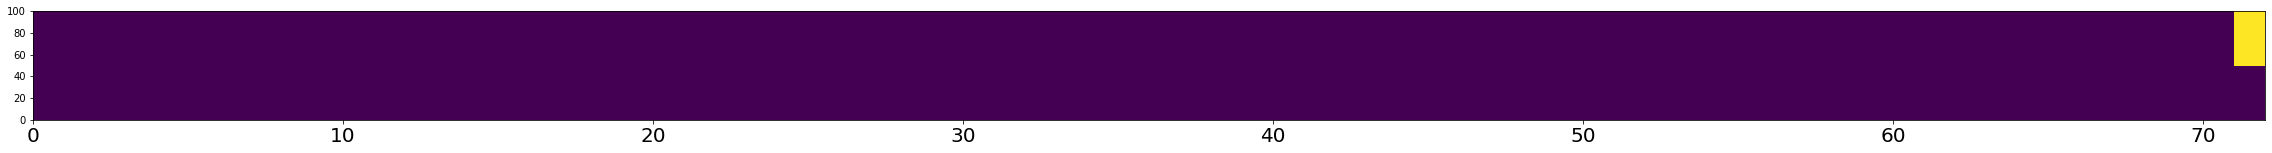

A,P,R:  0.9861111111111112 0.9861111111111112 1.0
Num frames:  (72, 1)
Accuracy:  0.9861111111111112
Person:  237
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


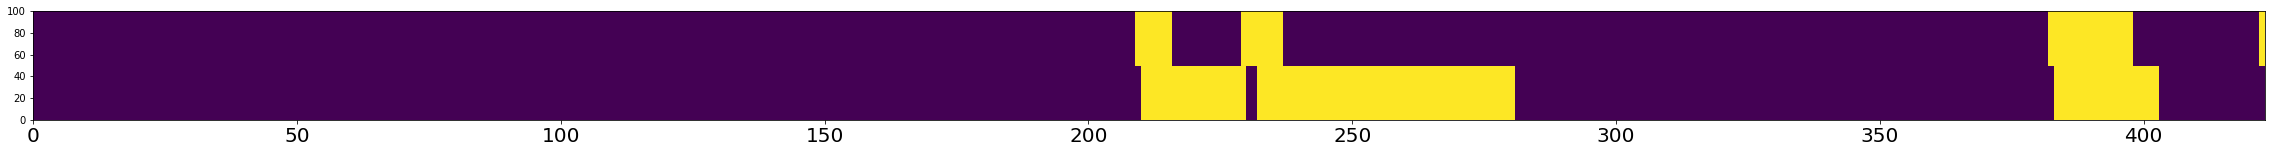

A,P,R:  0.8416075650118203 0.9850299401197605 0.8414322250639387
Num frames:  (334, 5)
Accuracy:  0.8416075650118203
Person:  238
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


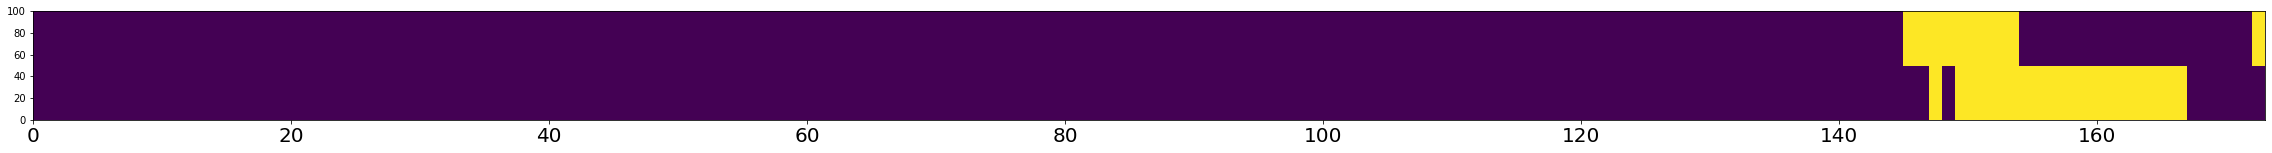

A,P,R:  0.9017341040462428 0.974025974025974 0.9202453987730062
Num frames:  (154, 4)
Accuracy:  0.9017341040462428
Person:  239
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


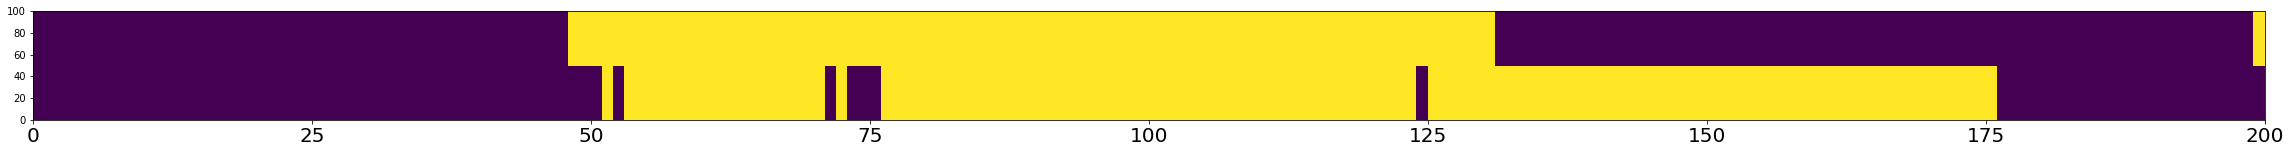

A,P,R:  0.725 0.8765432098765432 0.6120689655172413
Num frames:  (81, 10)
Accuracy:  0.725
Person:  240
Transitions:  [2, 3, 2, 3, 2, 3]
GT transitions:  2
Transitions captured:  1


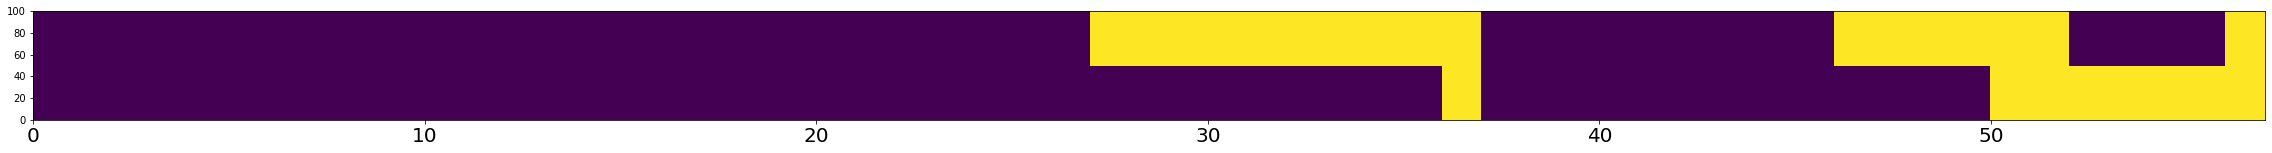

A,P,R:  0.7017543859649122 0.7346938775510204 0.9
Num frames:  (49, 13)
Accuracy:  0.7017543859649122
Person:  241
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  4
Transitions captured:  1


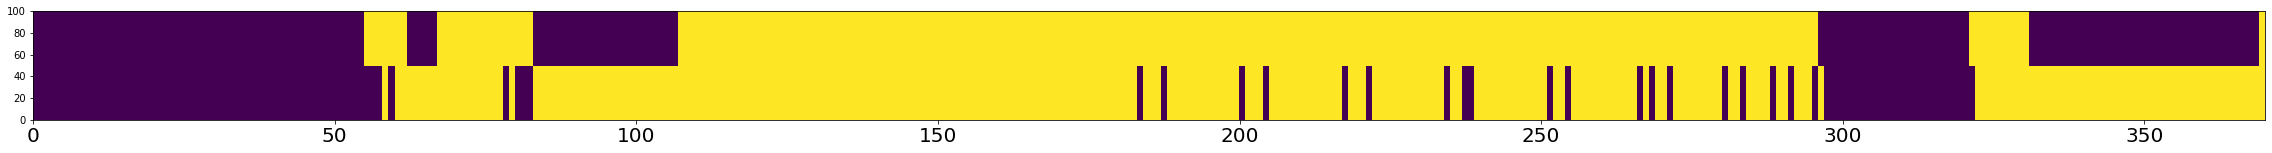

A,P,R:  0.7405405405405405 0.7383177570093458 0.5374149659863946
Num frames:  (107, 28)
Accuracy:  0.7405405405405405
Person:  242
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


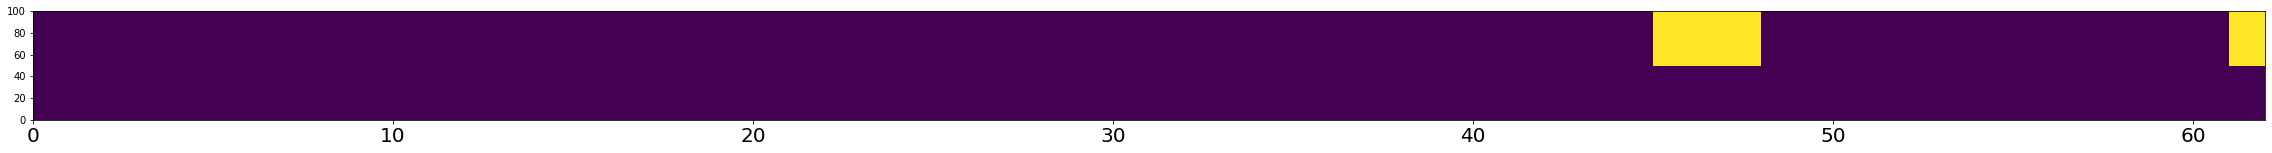

A,P,R:  0.9354838709677419 0.9354838709677419 1.0
Num frames:  (62, 4)
Accuracy:  0.9354838709677419
Person:  243
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


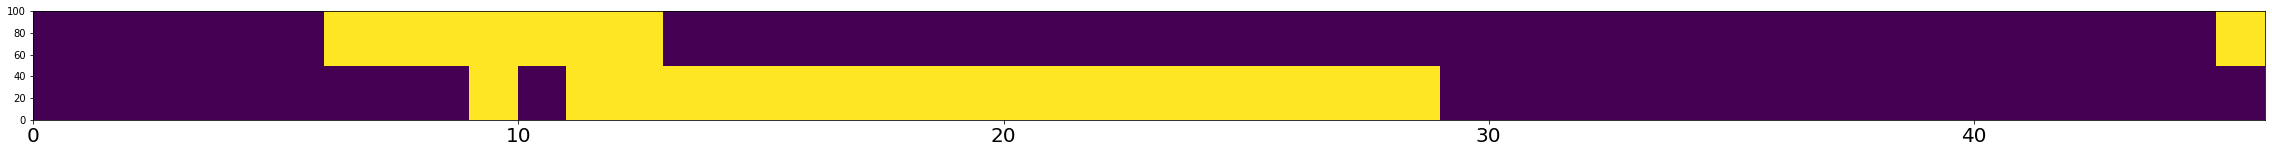

A,P,R:  0.5434782608695652 0.8148148148148148 0.5789473684210527
Num frames:  (27, 5)
Accuracy:  0.5434782608695652
Person:  244
Transitions:  [2, 3, 2, 3, 2, 3, 2, 3]
GT transitions:  3
Transitions captured:  2


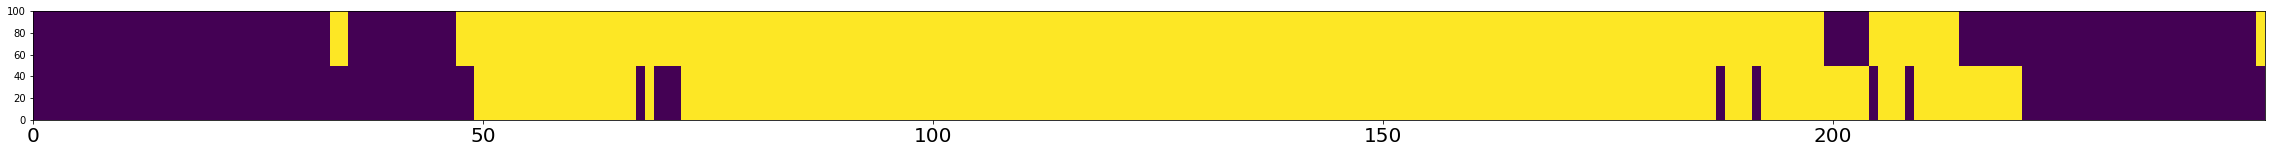

A,P,R:  0.8991935483870968 0.8452380952380952 0.8554216867469879
Num frames:  (84, 13)
Accuracy:  0.8991935483870968
Person:  245
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


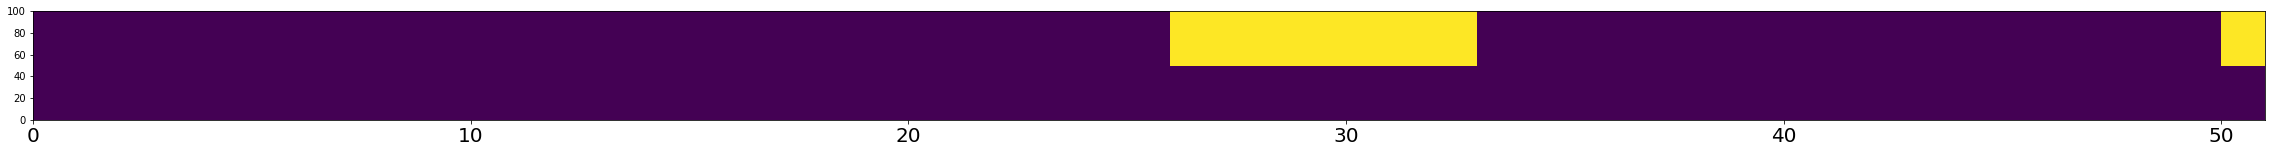

A,P,R:  0.8431372549019608 0.8431372549019608 1.0
Num frames:  (51, 8)
Accuracy:  0.8431372549019608
Person:  246
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  0


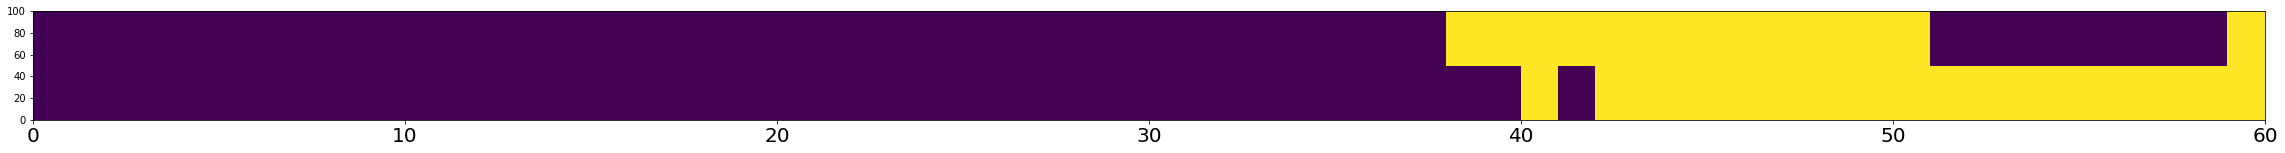

A,P,R:  0.8166666666666667 0.926829268292683 0.8260869565217391
Num frames:  (41, 3)
Accuracy:  0.8166666666666667
Person:  247
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



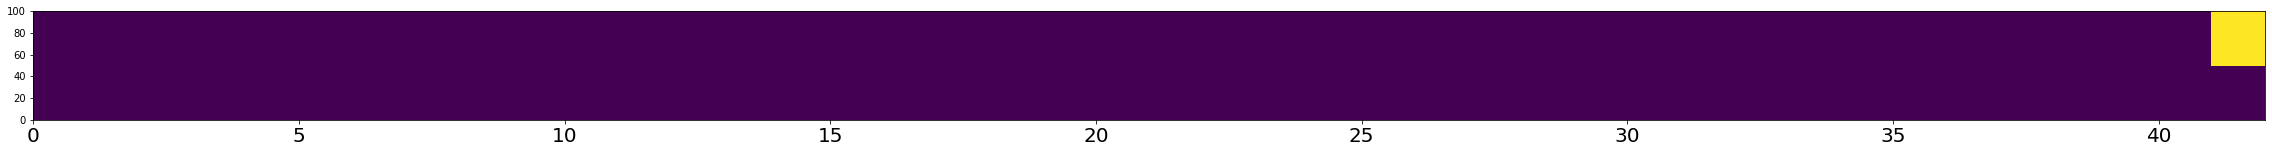

A,P,R:  0.9761904761904762 0.9761904761904762 1.0
Num frames:  (42, 1)
Accuracy:  0.9761904761904762
Person:  248
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


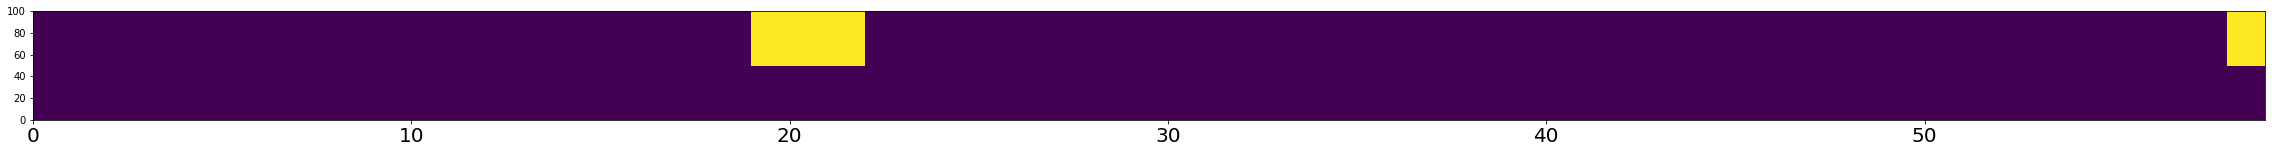

A,P,R:  0.9322033898305084 0.9322033898305084 1.0
Num frames:  (59, 4)
Accuracy:  0.9322033898305084
Person:  249
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


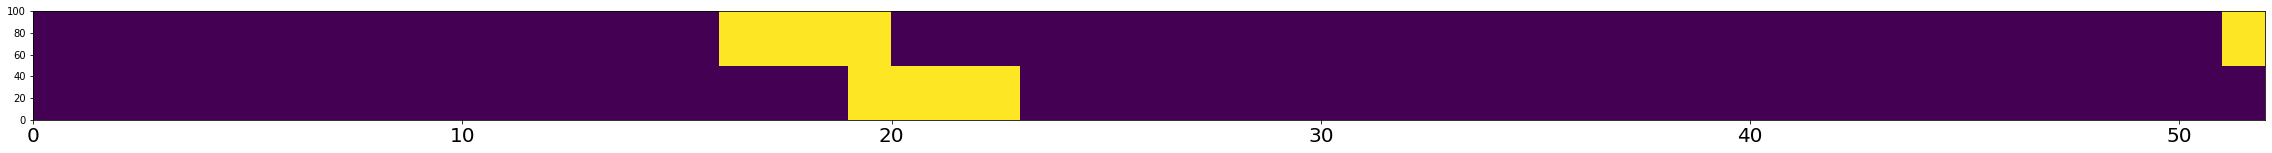

A,P,R:  0.8653846153846154 0.9166666666666666 0.9361702127659575
Num frames:  (48, 4)
Accuracy:  0.8653846153846154
Person:  250
Transitions:  [2, 3, 2, 3]
GT transitions:  1
Transitions captured:  1


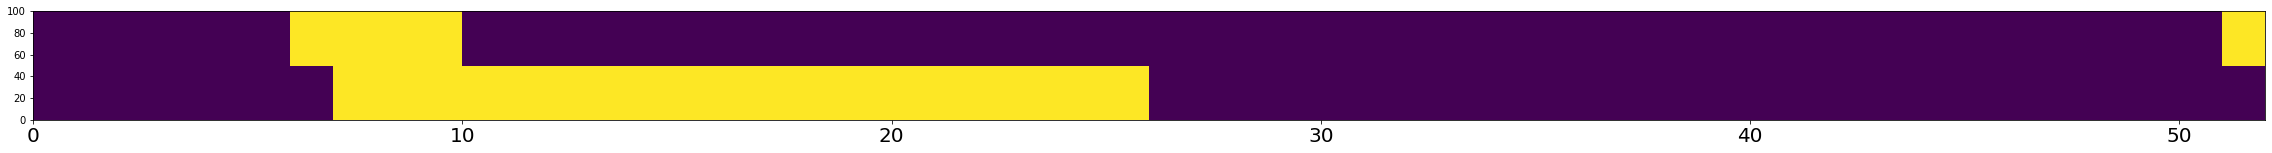

A,P,R:  0.6538461538461539 0.9393939393939394 0.6595744680851063
Num frames:  (33, 2)
Accuracy:  0.6538461538461539
Person:  251
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



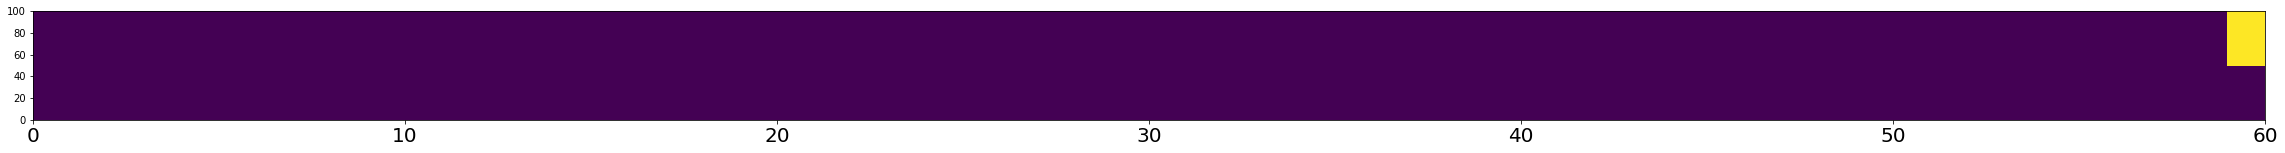

A,P,R:  0.9833333333333333 0.9833333333333333 1.0
Num frames:  (60, 1)
Accuracy:  0.9833333333333333
Person:  252
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



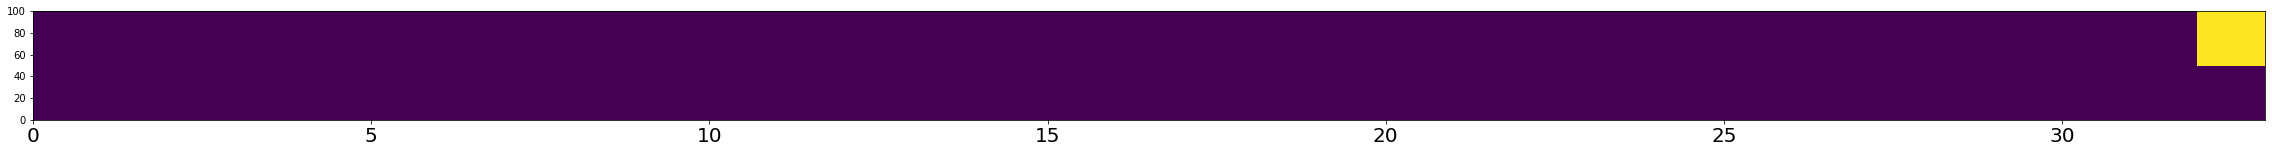

A,P,R:  0.9696969696969697 0.9696969696969697 1.0
Num frames:  (33, 1)
Accuracy:  0.9696969696969697
Person:  253
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



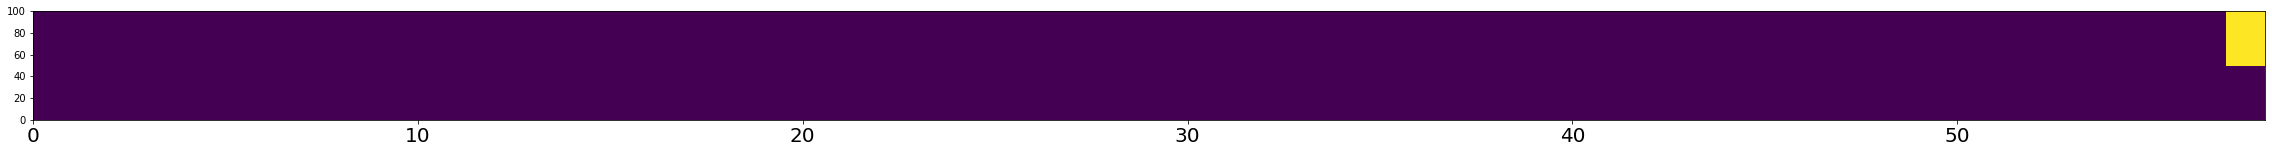

A,P,R:  0.9827586206896551 0.9827586206896551 1.0
Num frames:  (58, 1)
Accuracy:  0.9827586206896551
Person:  254
Transitions:  [2, 3]
GT transitions:  0
Transitions captured:  0



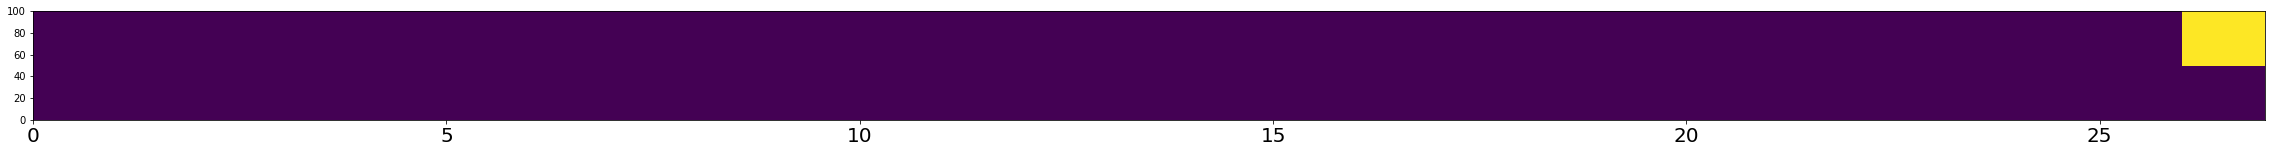

A,P,R:  0.9629629629629629 0.9629629629629629 1.0
Num frames:  (27, 1)
Accuracy:  0.9629629629629629
0.9295954317250532
Average (only transitions) A,P,R 0.8983972036920862 0.8743667701468435 0.9170107648755152
Average (all targets) A,P,R,F, ttr 0.9295954317250531 0.9150359311971215 0.9495071485360491 68.92156862745098 [5, 5, 5, 3, 5, 1, 1, 3, 3, 3, 5, 3, 3, 1, 3, 3, 5, 5, 5, 5, 3, 5, 3, 3, 3, 5, 7, 5, 5, 5, 5, 3, 5, 5, 5, 3, 7, 5, 3, 3, 9, 7, 5, 5, 3, 3, 5, 3, 5, 5, 5, 5, 3, 5, 3, 5, 3, 5, 3, 5, 7, 7, 3, 3, 5, 5, 3, 3, 7, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 5, 3, 5, 7, 3, 3, 5, 7, 3, 3, 5, 3, 3, 3, 5, 3, 5, 7, 3, 3, 3, 5, 3, 5, 5, 5, 5, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 15, 1, 3, 3, 1, 1, 1, 1, 1, 1, 17, 1, 5, 9, 1, 1, 1, 3, 3, 1, 3, 7, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 7, 3, 5, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 7, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 7, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,

In [25]:
# compute performance metric values
render = False
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [26]:
# Perceptage transitions captured (avg of all targets/ avg transitions)
a = np.stack(avg_tr_captured)
avgTrPerTarget = np.mean(a[:,0]/a[:,1])
print (avgTrPerTarget)
avgTr = sum(a[:,0])/sum(a[:,1])
print (avgTr)
totalTr = sum(a[:,1])

0.8791090629800307
0.8443579766536965


In [27]:
resMat['avgTr'] = avgTr
resMat['totalTr'] = totalTr

spio.savemat(saveFilePath, resMat)
print ('results saved in ', saveFilePath)test

results saved in  ./results/results_MM_db2_exp2_gt.mat


## Old Functions

In [ ]:
policy_net.eval()
req_inc = 0
render = False
_,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [34]:
a = np.stack(avg_tr_captured)
print (np.mean(a[:,0]/a[:,1]))
print (sum(a[:,0])/sum(a[:,1]))

0.46708570932173415
0.52
